In [1]:
# Install keras-tuner
!pip install keras-tuner --quiet

# Import Libraries

In [2]:
#Import libraries
import pytz
import numpy as np
import keras
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, concatenate, GlobalAveragePooling1D
from tensorflow.keras import Input
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
import keras_tuner as kt
from keras_tuner import BayesianOptimization

In [3]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [4]:
import os
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    tf.config.experimental.enable_op_determinism()

set_seed(42)

# Load Data and Plot Data

In [5]:
print("="*100)
print("LOADING DATASETS")
print("="*100)

df_BBRI = pd.read_csv('BBRI.JK_OHLC_Data_Technical.csv')
df_BBRI_Full = pd.read_csv('BBRI_merged_stock_and_sentiment_Full.csv')

print("\nBBRI Dataset Preview:")
print(df_BBRI.head())
print("\nBBRI + Sentiment Dataset Preview:")
print(df_BBRI_Full.head())

LOADING DATASETS

BBRI Dataset Preview:
                    Datetime   Close    High     Low    Open    Volume  \
0  2023-10-09 09:00:00+07:00  5200.0  5225.0  5175.0  5200.0  15199300   
1  2023-10-09 10:00:00+07:00  5175.0  5200.0  5125.0  5200.0  33701800   
2  2023-10-09 11:00:00+07:00  5150.0  5175.0  5150.0  5150.0   7039400   
3  2023-10-09 13:00:00+07:00  5175.0  5175.0  5150.0  5175.0   7545900   
4  2023-10-09 14:00:00+07:00  5125.0  5175.0  5125.0  5175.0  29913600   

   EMA_12  EMA_26    RSI_14  
0     NaN     NaN       NaN  
1     NaN     NaN  0.000000  
2     NaN     NaN  0.000000  
3     NaN     NaN  7.142857  
4     NaN     NaN  6.190476  

BBRI + Sentiment Dataset Preview:
                    Datetime   Close    High     Low    Open    Volume  \
0  2023-10-09 09:00:00+07:00  5200.0  5225.0  5175.0  5200.0  15199300   
1  2023-10-09 10:00:00+07:00  5175.0  5200.0  5125.0  5200.0  33701800   
2  2023-10-09 11:00:00+07:00  5150.0  5175.0  5150.0  5150.0   7039400   
3  2

In [6]:
df_BBRI['Datetime'] = pd.to_datetime(df_BBRI['Datetime'])
df_BBRI_Full['Datetime'] = pd.to_datetime(df_BBRI_Full['Datetime'])


DATA VISUALIZATION


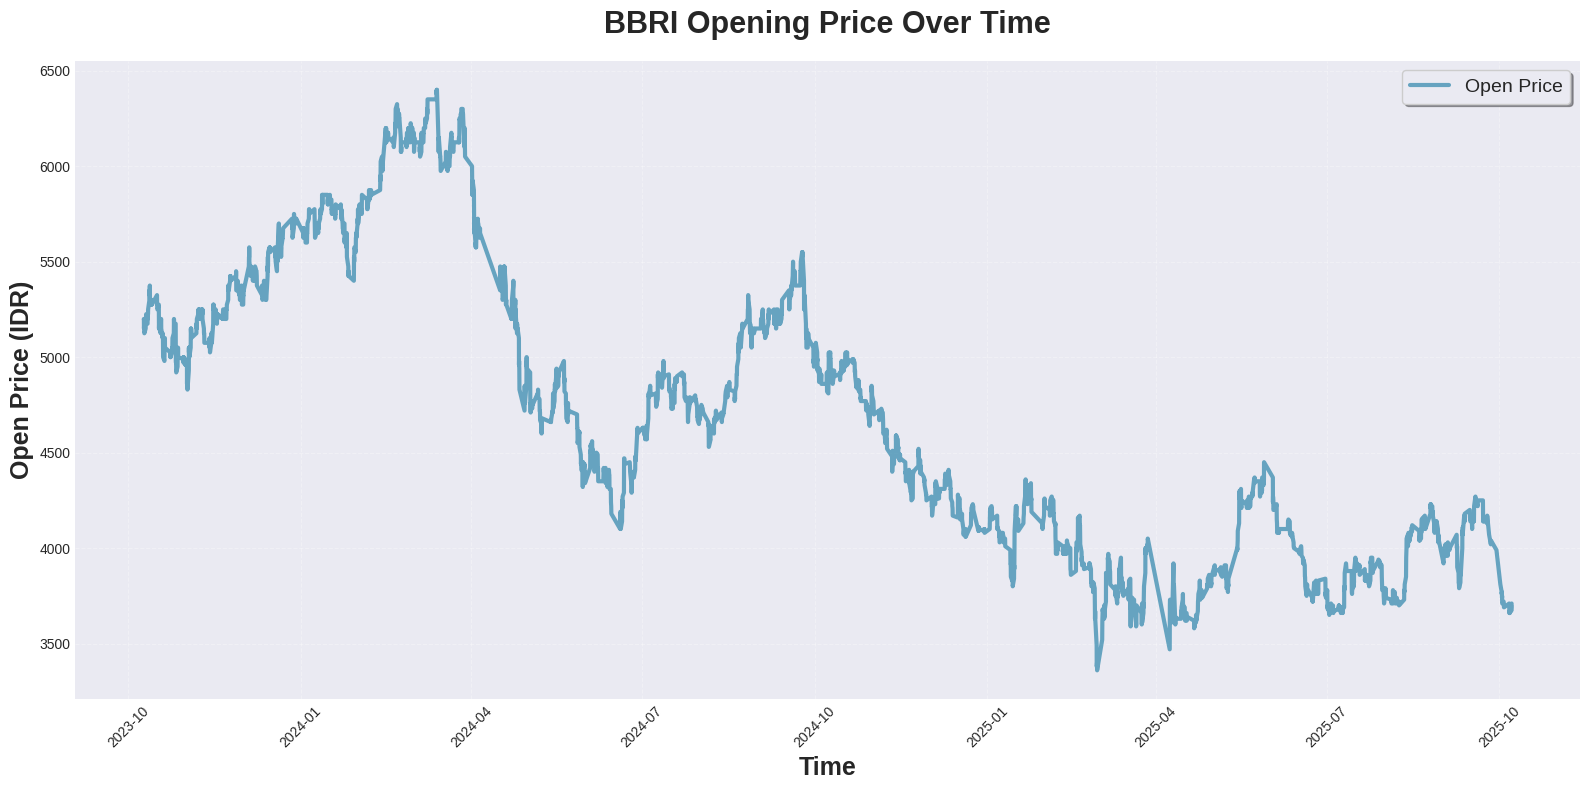

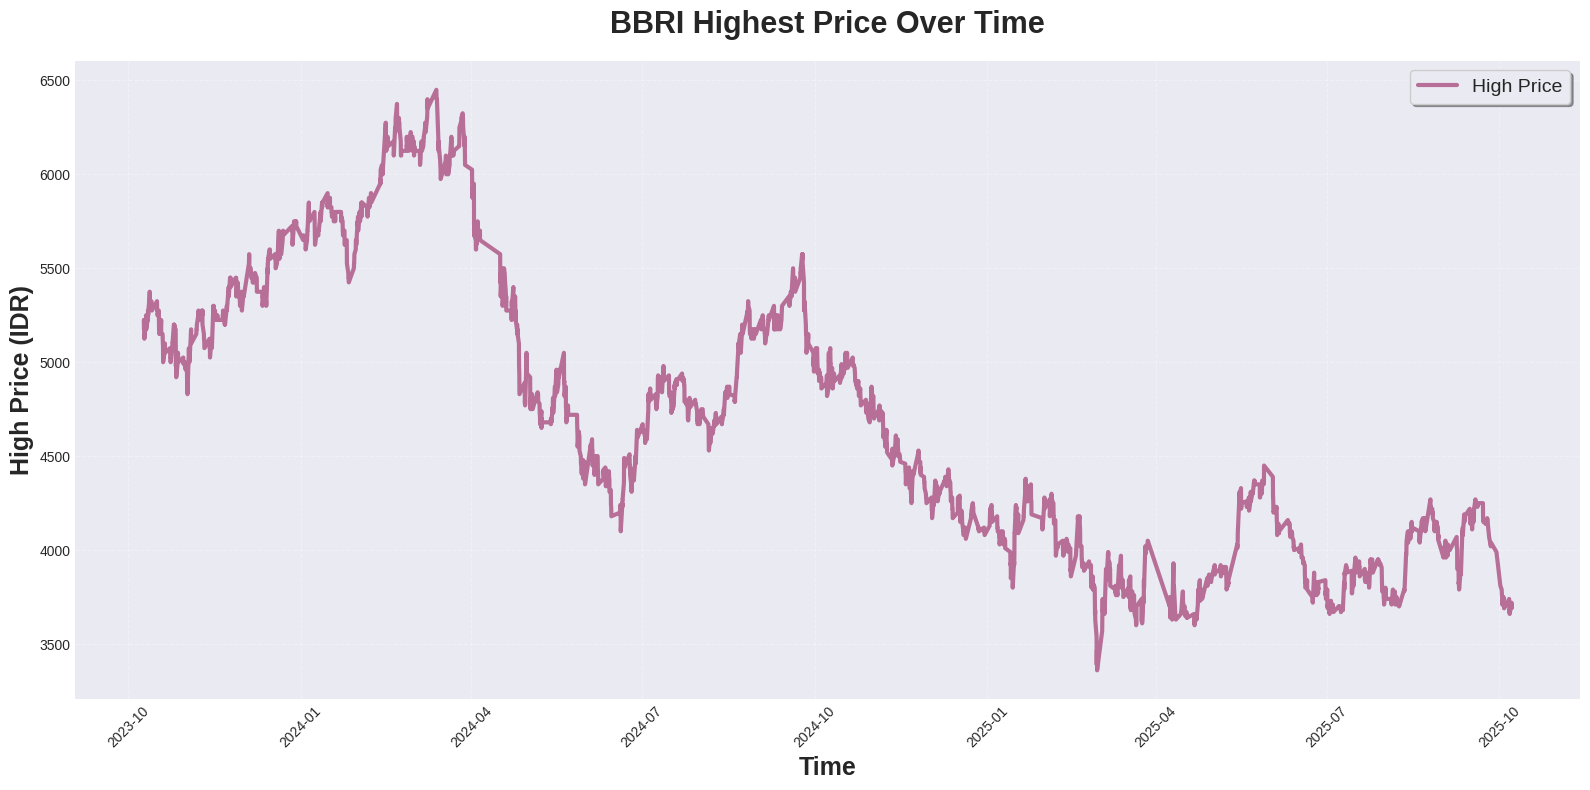

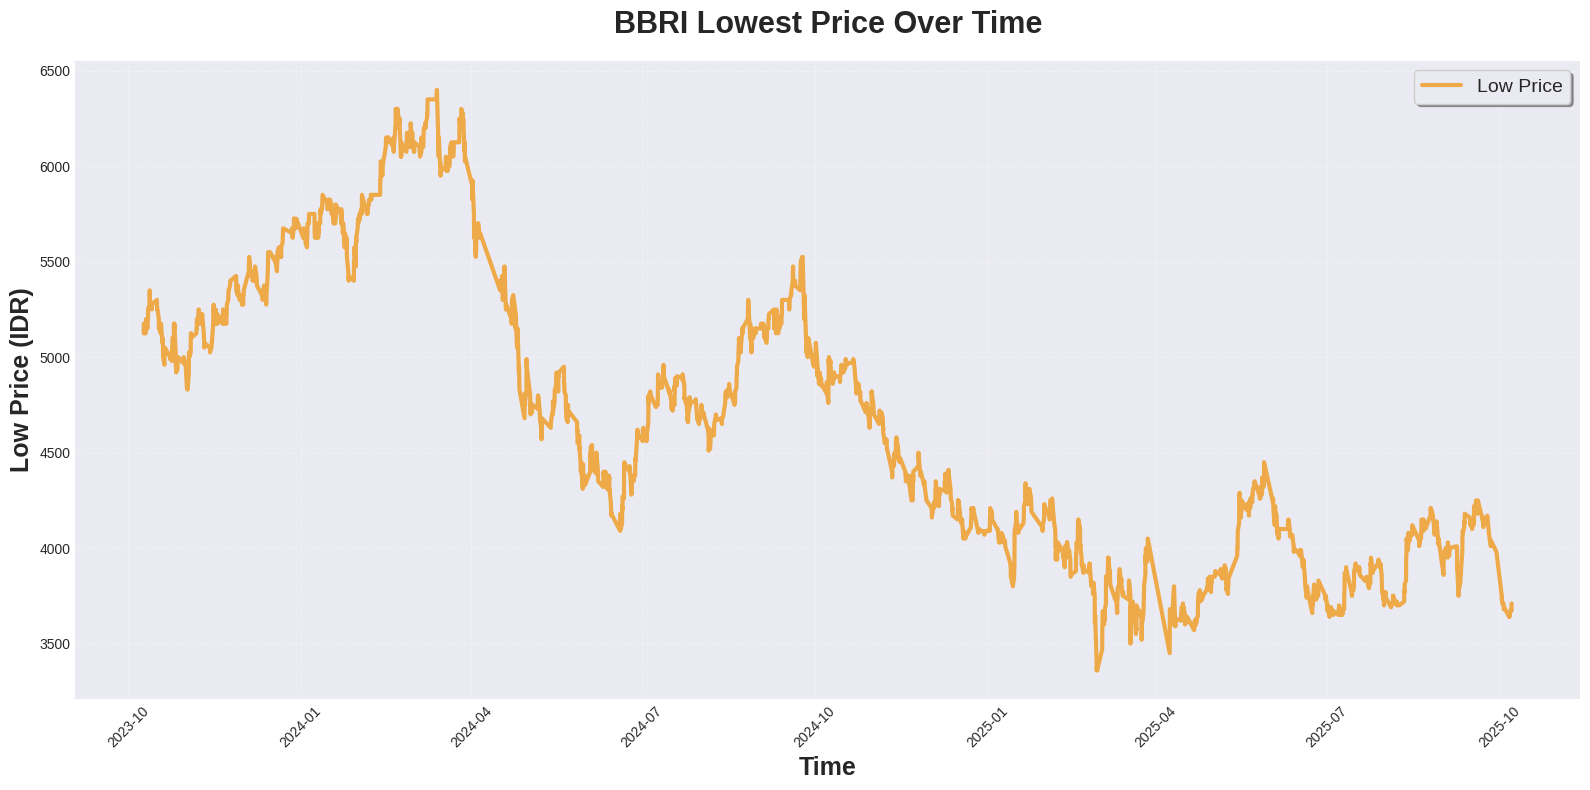

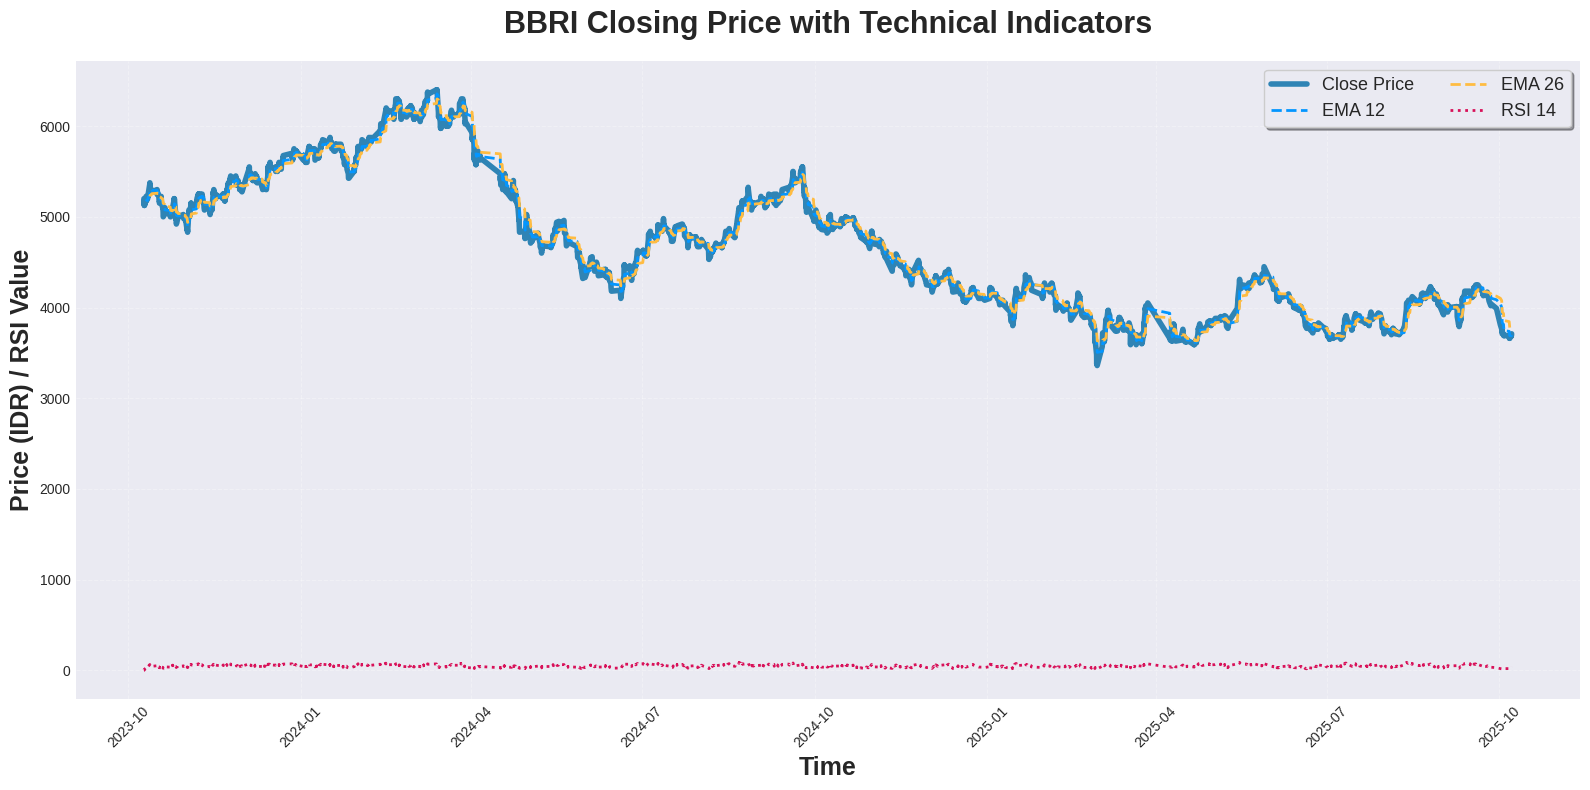

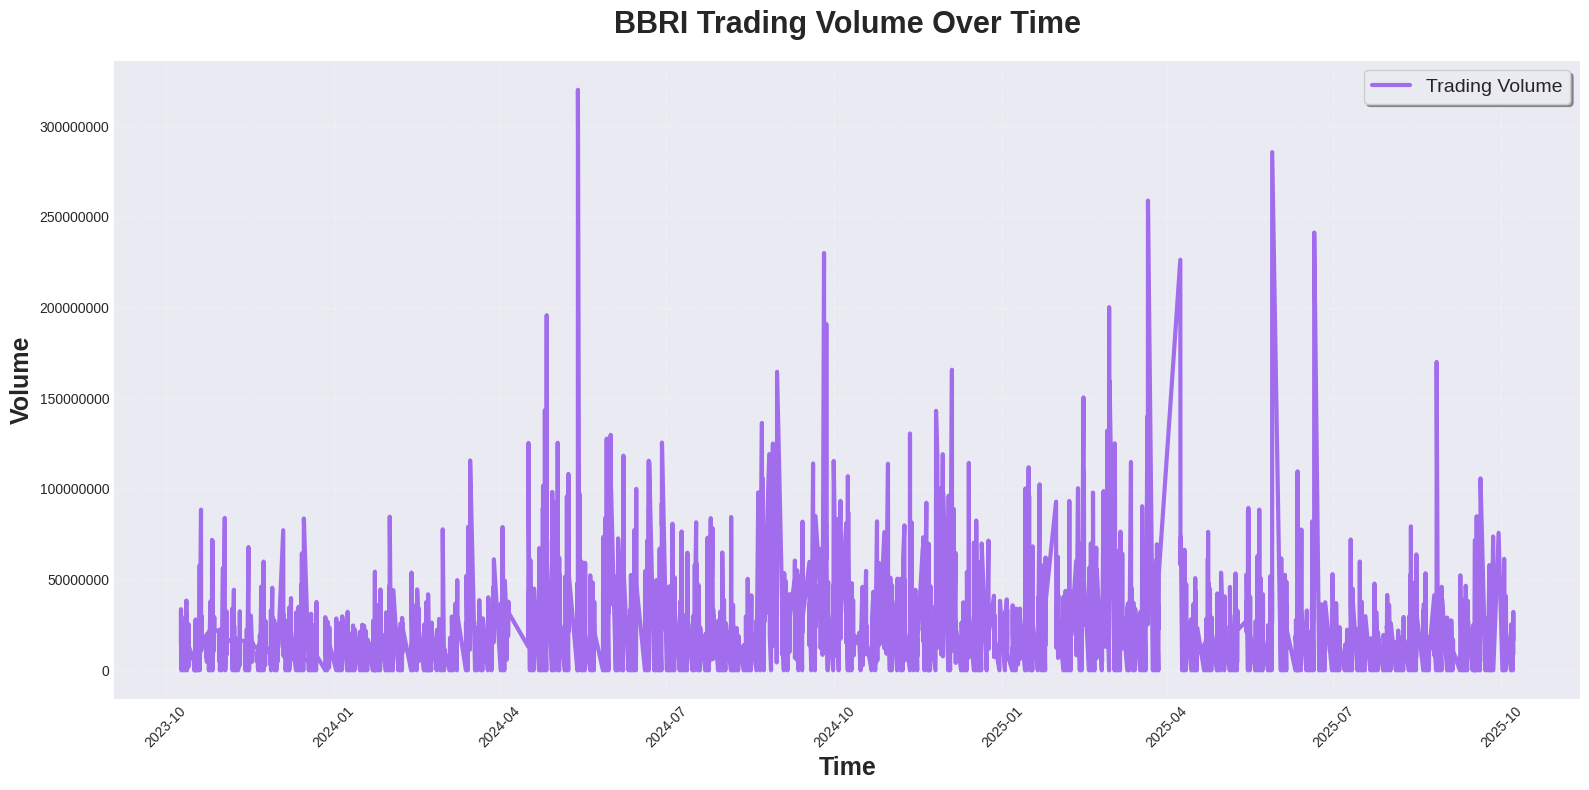

/tmp/ipython-input-2621172810.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Sentiment_value', data=df_BBRI_Full , palette=custom_palette, edgecolor='black', alpha=0.85)


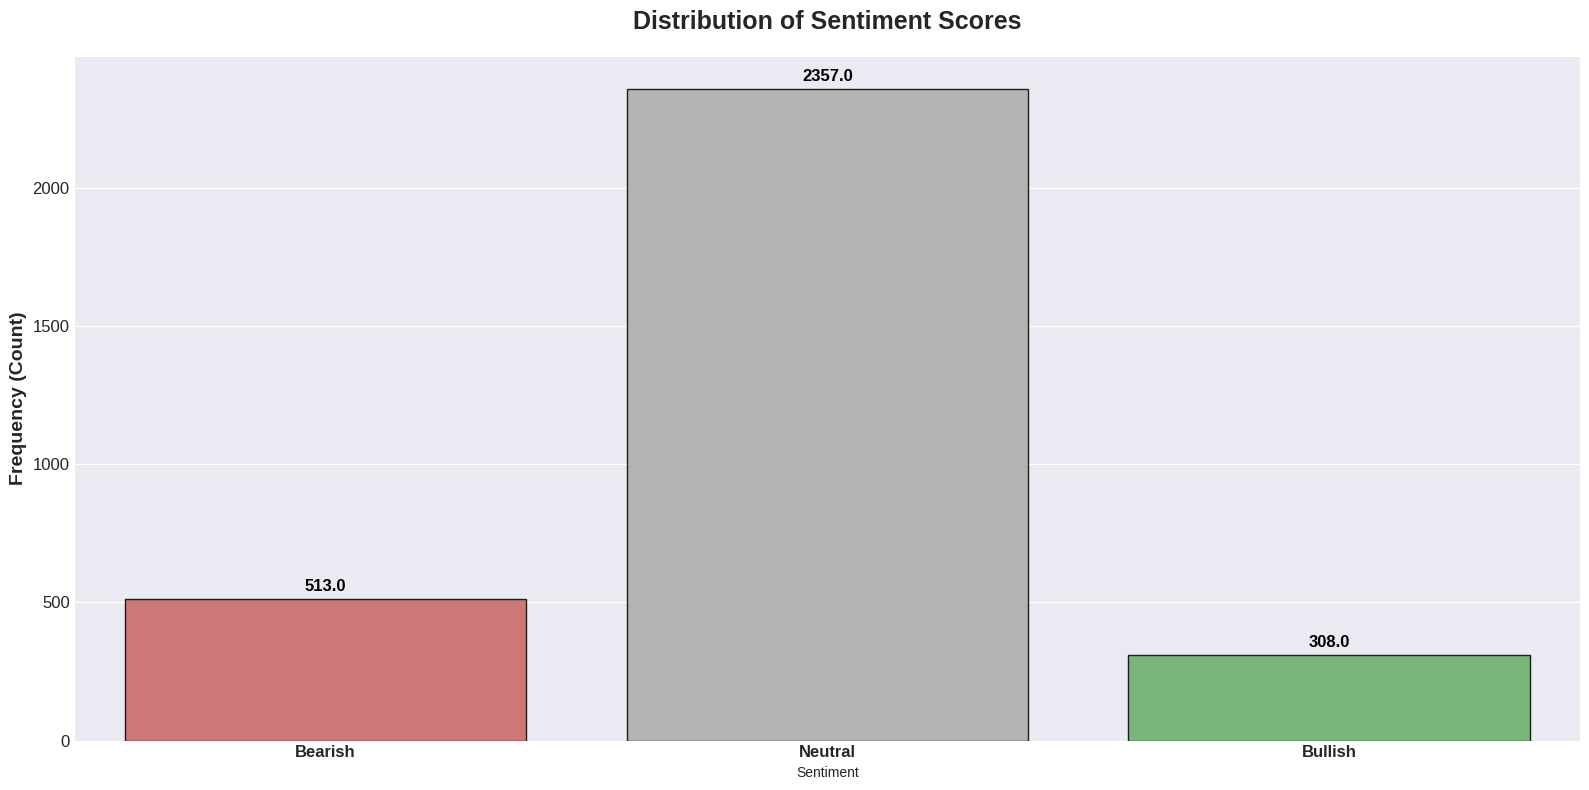

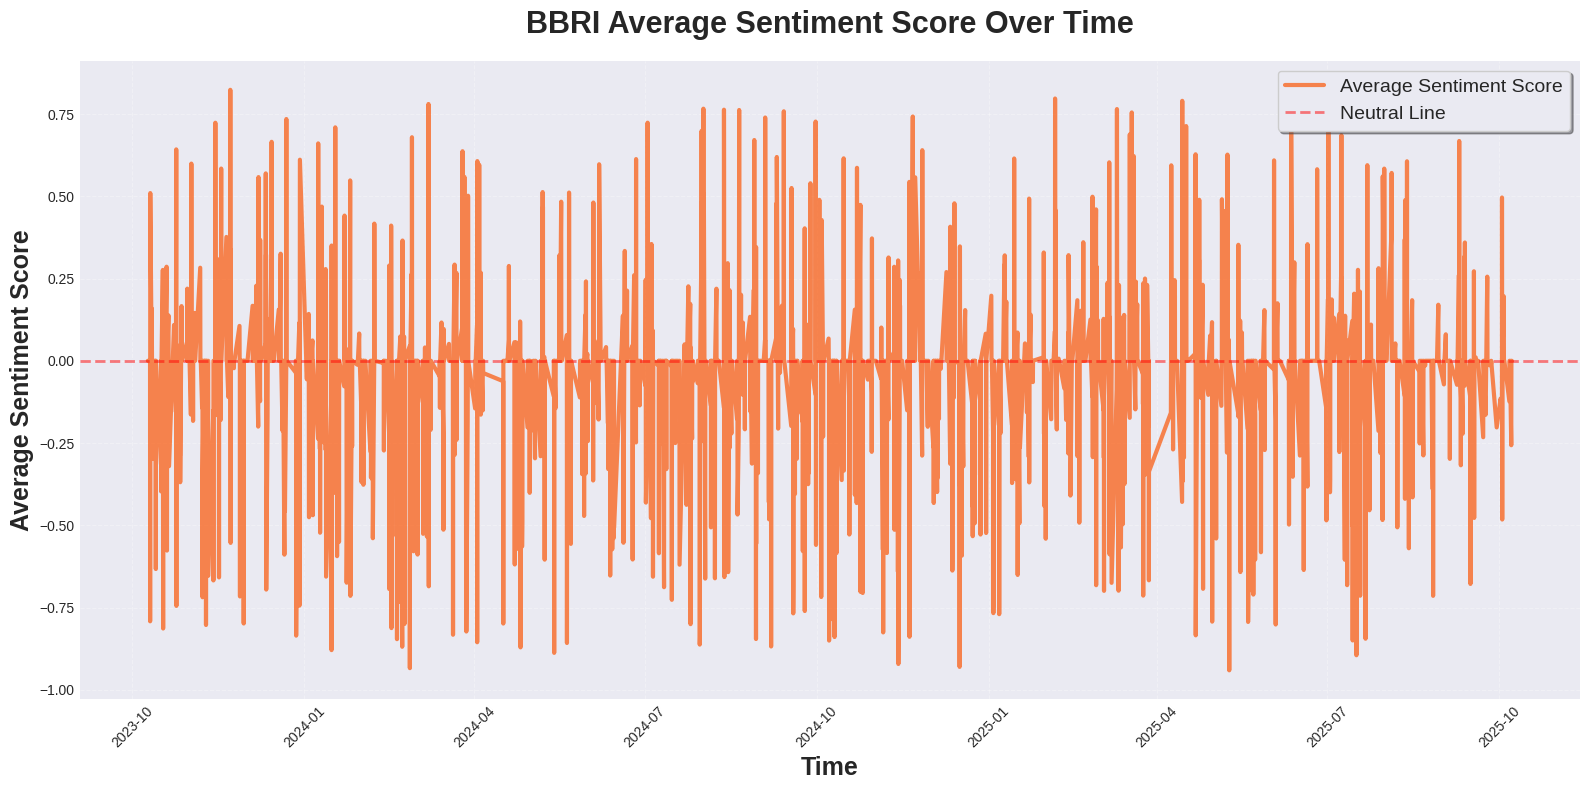

In [7]:
print("\n" + "="*100)
print("DATA VISUALIZATION")
print("="*100)

# Plot Open Price
plt.figure(figsize=(16,8))
sns.lineplot(x=df_BBRI['Datetime'], y=df_BBRI['Open'], alpha=0.7, linewidth=3, color='#2E86AB', label='Open Price')
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Open Price (IDR)', fontsize=18, fontweight='bold')
plt.title('BBRI Opening Price Over Time', fontsize=22, fontweight='bold', pad=20)
plt.legend(fontsize=14, loc='best', frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print('\n'+'='*100)

# Plot High Price
plt.figure(figsize=(16,8))
sns.lineplot(x=df_BBRI['Datetime'], y=df_BBRI['High'], alpha=0.7, linewidth=3, color='#A23B72', label='High Price')
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('High Price (IDR)', fontsize=18, fontweight='bold')
plt.title('BBRI Highest Price Over Time', fontsize=22, fontweight='bold', pad=20)
plt.legend(fontsize=14, loc='best', frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print('\n'+'='*100)

# Plot Low Price
plt.figure(figsize=(16,8))
sns.lineplot(x=df_BBRI['Datetime'], y=df_BBRI['Low'], alpha=0.7, linewidth=3, color='#F18F01', label='Low Price')
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Low Price (IDR)', fontsize=18, fontweight='bold')
plt.title('BBRI Lowest Price Over Time', fontsize=22, fontweight='bold', pad=20)
plt.legend(fontsize=14, loc='best', frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print('\n'+'='*100)

# Plot Close Price with EMA and RSI
plt.figure(figsize=(16,8))
sns.lineplot(x=df_BBRI['Datetime'], y=df_BBRI['Close'], alpha=0.8, linewidth=4, color='#006BA6', label='Close Price')
sns.lineplot(x=df_BBRI['Datetime'], y=df_BBRI['EMA_12'], linewidth=2, color='#0496FF', label='EMA 12', linestyle='--')
sns.lineplot(x=df_BBRI['Datetime'], y=df_BBRI['EMA_26'], linewidth=2, color='#FFBC42', label='EMA 26', linestyle='--')
sns.lineplot(x=df_BBRI['Datetime'], y=df_BBRI['RSI_14'], linewidth=2, color='#D81159', label='RSI 14', linestyle=':')
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Price (IDR) / RSI Value', fontsize=18, fontweight='bold')
plt.title('BBRI Closing Price with Technical Indicators', fontsize=22, fontweight='bold', pad=20)
plt.legend(fontsize=13, loc='best', frameon=True, shadow=True, ncol=2)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print('\n'+'='*100)

# Plot Volume
plt.figure(figsize=(16,8))
sns.lineplot(x=df_BBRI['Datetime'], y=df_BBRI['Volume'], alpha=0.7, linewidth=3, color='#8338EC', label='Trading Volume')
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Volume', fontsize=18, fontweight='bold')
plt.title('BBRI Trading Volume Over Time', fontsize=22, fontweight='bold', pad=20)
plt.legend(fontsize=14, loc='best', frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()
print('\n'+'='*100)

# Plot Sentiment Distribution
plt.figure(figsize=(16,8))
custom_palette = {'-1': '#D9534F', '0': '#AAAAAA', '1': '#5CB85C'}
ax = sns.countplot(x='Sentiment_value', data=df_BBRI_Full , palette=custom_palette, edgecolor='black', alpha=0.85)
plt.xlabel('Sentiment')
plt.ylabel('Frequency (Count)', fontsize=14, fontweight='bold')
plt.title('Distribution of Sentiment Scores', fontsize=18, fontweight='bold', pad=20)
plt.xticks(ticks=['-1', '0', '1'], labels=['Bearish', 'Neutral', 'Bullish'],fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', fontweight='bold',xytext=(0, 9), textcoords='offset points')
sns.despine()
plt.tight_layout()
plt.show()
print('\n'+'='*100)

# Plot Average Sentiment Score
plt.figure(figsize=(16,8))
sns.lineplot(x=df_BBRI_Full['Datetime'], y=df_BBRI_Full['average_score'], alpha=0.7, linewidth=3, color='#FB5607', label='Average Sentiment Score')
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Average Sentiment Score', fontsize=18, fontweight='bold')
plt.title('BBRI Average Sentiment Score Over Time', fontsize=22, fontweight='bold', pad=20)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Neutral Line')
plt.legend(fontsize=14, loc='best', frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print('\n'+'='*100)

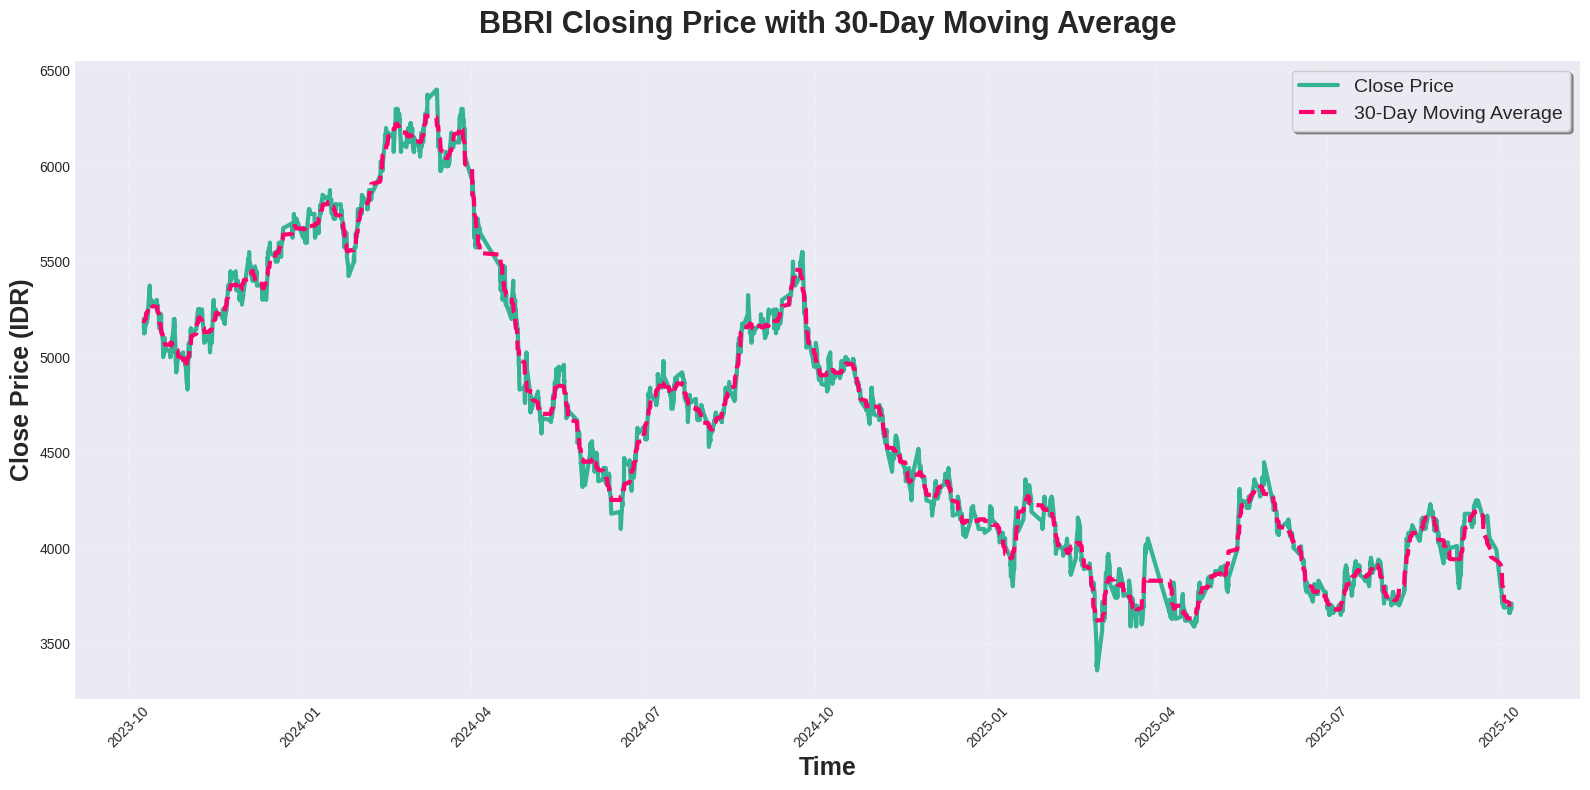

In [8]:
# Plot Close Price with Moving Average
plt.figure(figsize=(16,8))
ma_30 = df_BBRI['Close'].rolling(window=30, center=True, min_periods=15).mean()
sns.lineplot(x=df_BBRI['Datetime'], y=df_BBRI['Close'], alpha=0.8, linewidth=3, color='#06A77D', label='Close Price')
sns.lineplot(x=df_BBRI['Datetime'], y=ma_30, linewidth=3, color='#FF006E', label='30-Day Moving Average', linestyle='--')
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')
plt.title('BBRI Closing Price with 30-Day Moving Average', fontsize=22, fontweight='bold', pad=20)
plt.legend(fontsize=14, loc='best', frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print('\n'+'='*100)

In [9]:
# Data Preprocessing
print("="*100)
print("DATA PREPROCESSING")
print("="*100)

df_BBRI.set_index('Datetime', inplace=True)
df_BBRI['EMA_12'] = df_BBRI['EMA_12'].interpolate(method='linear', limit_direction='both')
df_BBRI['EMA_26'] = df_BBRI['EMA_26'].interpolate(method='linear', limit_direction='both')
df_BBRI['RSI_14'] = df_BBRI['RSI_14'].interpolate(method='linear', limit_direction='both')

df_BBRI_Full.set_index('Datetime', inplace=True)
df_BBRI_Full['EMA_12'] = df_BBRI_Full['EMA_12'].interpolate(method='linear', limit_direction='both')
df_BBRI_Full['EMA_26'] = df_BBRI_Full['EMA_26'].interpolate(method='linear', limit_direction='both')
df_BBRI_Full['RSI_14'] = df_BBRI_Full['RSI_14'].interpolate(method='linear', limit_direction='both')

print("\nBBRI Dataset Info:")
print(df_BBRI.info())
print("\nBBRI + Sentiment Dataset Info:")
print(df_BBRI_Full.info())

DATA PREPROCESSING

BBRI Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3178 entries, 2023-10-09 09:00:00+07:00 to 2025-10-07 16:00:00+07:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3178 non-null   float64
 1   High    3178 non-null   float64
 2   Low     3178 non-null   float64
 3   Open    3178 non-null   float64
 4   Volume  3178 non-null   int64  
 5   EMA_12  3178 non-null   float64
 6   EMA_26  3178 non-null   float64
 7   RSI_14  3178 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 223.5 KB
None

BBRI + Sentiment Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3178 entries, 2023-10-09 09:00:00+07:00 to 2025-10-07 16:00:00+07:00
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Close              3178 non-null   float64
 1   High               3178 non-null   float64
 

In [10]:
features_BBRI = df_BBRI[['Close','High','Low','Open','Volume','EMA_12','EMA_26','RSI_14']].values
features_BBRI_Full = df_BBRI_Full[['Close','High','Low','Open','Volume','EMA_12','EMA_26','RSI_14','average_score']].values

print(f"\nBBRI Features Shape: {features_BBRI.shape}")
print(f"BBRI + Sentiment Features Shape: {features_BBRI_Full.shape}")


BBRI Features Shape: (3178, 8)
BBRI + Sentiment Features Shape: (3178, 9)


In [11]:
target_col = 'Close'

target_col_BBRI = list(df_BBRI.columns).index(target_col)
target_col_BBRI_Full = list(df_BBRI_Full.columns).index(target_col)

print(f"\nTarget Column Index (BBRI): {target_col_BBRI}")
print(f"Target Column Index (BBRI + Sentiment): {target_col_BBRI_Full}")


Target Column Index (BBRI): 0
Target Column Index (BBRI + Sentiment): 0


# Splitting Data Train and Test

In [12]:
# Train-Test Split
print("\n" + "="*100)
print("TRAIN-TEST SPLIT")
print("="*100)
train_size_BBRI = int(len(features_BBRI) * 0.8)
train_data_BBRI = features_BBRI[:train_size_BBRI]
test_data_BBRI = features_BBRI[train_size_BBRI:]

train_size_BBRI_Full = int(len(features_BBRI_Full) * 0.8)
train_data_BBRI_Full = features_BBRI_Full[:train_size_BBRI_Full]
test_data_BBRI_Full = features_BBRI_Full[train_size_BBRI_Full:]

print(f"BBRI Train Size: {train_size_BBRI} | Test Size: {len(test_data_BBRI)}")
print(f"BBRI + Sentiment Train Size: {train_size_BBRI_Full} | Test Size: {len(test_data_BBRI_Full)}")


TRAIN-TEST SPLIT
BBRI Train Size: 2542 | Test Size: 636
BBRI + Sentiment Train Size: 2542 | Test Size: 636


In [13]:
scaler_BBRI = MinMaxScaler(feature_range=(0, 1))
scaled_train_data_BBRI = scaler_BBRI.fit_transform(train_data_BBRI)

scaler_BBRI_Full = MinMaxScaler(feature_range=(0, 1))
scaled_train_data_BBRI_Full = scaler_BBRI_Full.fit_transform(train_data_BBRI_Full)

scaled_test_data_BBRI = scaler_BBRI.transform(test_data_BBRI)
scaled_test_data_BBRI_Full = scaler_BBRI_Full.transform(test_data_BBRI_Full)
print("\nData scaling completed successfully")


Data scaling completed successfully


# Create Sliding Window

In [14]:
print("\n" + "="*100)
print("CREATING SLIDING WINDOWS")
print("="*100)
def create_sliding_window(dataset, target_index, window_size):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        # Input: all features from i-window_size to i
        X.append(dataset[i-window_size:i, :])
        # Output: only target column at time i
        y.append(dataset[i, target_index])
    return np.array(X), np.array(y)

window_size_B = 48
X_train_BBRI, y_train_BBRI = create_sliding_window(scaled_train_data_BBRI, target_col_BBRI, window_size_B)
X_test_BBRI, y_test_BBRI = create_sliding_window(scaled_test_data_BBRI, target_col_BBRI, window_size_B)

window_size_Full = 48
X_train_BBRI_Full, y_train_BBRI_Full = create_sliding_window(scaled_train_data_BBRI_Full, target_col_BBRI_Full, window_size_Full)
X_test_BBRI_Full, y_test_BBRI_Full = create_sliding_window(scaled_test_data_BBRI_Full, target_col_BBRI_Full, window_size_Full)

print(f"X_train BBRI Shape: {X_train_BBRI.shape}")
print(f"y_train BBRI Shape: {y_train_BBRI.shape}")
print(f"X_test BBRI Shape: {X_test_BBRI.shape}")
print(f"y_test BBRI Shape: {y_test_BBRI.shape}")

print(f"\nX_train BBRI + Sentiment Shape: {X_train_BBRI_Full.shape}")
print(f"y_train BBRI + Sentiment Shape: {y_train_BBRI_Full.shape}")
print(f"X_test BBRI + Sentiment Shape: {X_test_BBRI_Full.shape}")
print(f"y_test BBRI + Sentiment Shape: {y_test_BBRI_Full.shape}")


CREATING SLIDING WINDOWS
X_train BBRI Shape: (2494, 48, 8)
y_train BBRI Shape: (2494,)
X_test BBRI Shape: (588, 48, 8)
y_test BBRI Shape: (588,)

X_train BBRI + Sentiment Shape: (2494, 48, 9)
y_train BBRI + Sentiment Shape: (2494,)
X_test BBRI + Sentiment Shape: (588, 48, 9)
y_test BBRI + Sentiment Shape: (588,)


# Building Model





In [15]:
print("\n" + "="*100)
print("BUILDING LSTM TUNED MODELS")
print("="*100)
def build_lstm_model_tuner(hp, input_shape):
    """Build LSTM model to tune"""
    set_seed(42)

    units_1 = hp.Int('units_1', min_value=64, max_value=192, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.2, step=0.1)
    lr = 0.001
    model = Sequential([
        LSTM(units=units_1, return_sequences=False, recurrent_activation='sigmoid', activation='tanh', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(1)
    ], name='LSTM_Model_tuned')

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=lr),
                  metrics=['mae', keras.metrics.RootMeanSquaredError()])
    return model


BUILDING LSTM TUNED MODELS


In [16]:
def build_cnn1d_model_tuner(hp, input_shape):
    """Build CNN1D model with hyperparameters to tune"""
    set_seed(42)

    # Hyperparameters to tune
    filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    filters_2 = hp.Int('filters_2', min_value=64, max_value=192, step=32)
    filters_3 = hp.Int('filters_3', min_value=128, max_value=256, step=64)
    kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    dense_units = hp.Int('dense_units', min_value=32, max_value=64, step=32)

    model = Sequential([
        # First Conv Block
        Conv1D(filters=filters_1, kernel_size=kernel_size, activation='relu',
               padding='same', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),

        # Second Conv Block
        Conv1D(filters=filters_2, kernel_size=kernel_size, activation='relu',
               padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),

        # Third Conv Block
        Conv1D(filters=filters_3, kernel_size=kernel_size, activation='relu',
               padding='same'),
        GlobalAveragePooling1D(),
        Dropout(dropout_rate),

        # Dense layers
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1)
    ], name='CNN1D_Model_Tuned')

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['mae', keras.metrics.RootMeanSquaredError()])
    return model

In [17]:
print("\n" + "="*100)
print("BUILDING ENSEMBLE LSTM + CNN1D MODELS")
print("="*100)

def build_ensemble_model_tuner(hp, input_shape):
    """Build Ensemble LSTM + CNN1D model with hyperparameters to tune"""
    set_seed(42)

    # Hyperparameters to tune
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    cnn_filters = hp.Int('cnn_filters', min_value=32, max_value=128, step=32)
    kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    dense_units = hp.Int('dense_units', min_value=32, max_value=64, step=32)

    # Input layer
    inputs = Input(shape=input_shape)

    # LSTM Branch
    lstm_branch = LSTM(units=lstm_units, return_sequences=False,
                       recurrent_activation='sigmoid', activation='tanh')(inputs)
    lstm_branch = Dropout(dropout_rate)(lstm_branch)

    # CNN Branch
    cnn_branch = Conv1D(filters=cnn_filters, kernel_size=kernel_size,
                        activation='relu', padding='same')(inputs)
    cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
    cnn_branch = Conv1D(filters=cnn_filters*2, kernel_size=kernel_size,
                        activation='relu', padding='same')(cnn_branch)
    cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
    cnn_branch = Flatten()(cnn_branch)
    cnn_branch = Dropout(dropout_rate)(cnn_branch)

    # Concatenate LSTM and CNN outputs
    merged = concatenate([lstm_branch, cnn_branch])

    # Dense layers
    dense1 = Dense(dense_units, activation='relu')(merged)
    dense1 = Dropout(dropout_rate)(dense1)
    output = Dense(1)(dense1)

    # Create model
    model = Model(inputs=inputs, outputs=output, name='Ensemble_LSTM_CNN1D_Tuned')

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['mae', keras.metrics.RootMeanSquaredError()])
    return model


BUILDING ENSEMBLE LSTM + CNN1D MODELS


In [18]:
def create_callbacks():
    """Create callbacks for training"""
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
    return [early_stop, reduce_lr]

# Model Training

In [19]:
print("\n" + "="*100)
print("BAYESIAN OPTIMIZATION - LSTM MODEL (BBRI WITHOUT SENTIMENT)")
print("="*100)

input_shape_LSTM = (X_train_BBRI.shape[1], X_train_BBRI.shape[2])
tuner_lstm_BBRI = BayesianOptimization(
    lambda hp: build_lstm_model_tuner(hp, input_shape_LSTM),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/Project_ARW/tuning_results',
    project_name='lstm_bbri_no_sentiment',
    overwrite=True
)

tuner_lstm_BBRI.search(
    X_train_BBRI, y_train_BBRI,
    epochs=60,
    batch_size=32,
    validation_data=(X_test_BBRI, y_test_BBRI),
    callbacks=create_callbacks(),
    verbose=1
)

best_hps_lstm_BBRI = tuner_lstm_BBRI.get_best_hyperparameters(num_trials=1)[0]
print("\n" + "="*100)
print("BEST HYPERPARAMETERS - LSTM BBRI (WITHOUT SENTIMENT)")
print("="*100)
print(f"Units 1: {best_hps_lstm_BBRI.get('units_1')}")
print(f"Dropout Rate: {best_hps_lstm_BBRI.get('dropout_rate')}")

model_lstm_BBRI = tuner_lstm_BBRI.hypermodel.build(best_hps_lstm_BBRI)
history_lstm_BBRI = model_lstm_BBRI.fit(
    X_train_BBRI, y_train_BBRI,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_BBRI, y_test_BBRI),
    callbacks=create_callbacks(),
    verbose=1
)

print(f"\n✓ Training completed - Best val_loss: {min(history_lstm_BBRI.history['val_loss']):.6f}")

Trial 10 Complete [00h 06m 33s]
val_loss: 0.000122920231660828

Best val_loss So Far: 0.000122920231660828
Total elapsed time: 00h 56m 31s

BEST HYPERPARAMETERS - LSTM BBRI (WITHOUT SENTIMENT)
Units 1: 160
Dropout Rate: 0.1
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.0213 - mae: 0.0948 - root_mean_squared_error: 0.1340 - val_loss: 3.5557e-04 - val_mae: 0.0147 - val_root_mean_squared_error: 0.0189 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0013 - mae: 0.0273 - root_mean_squared_error: 0.0360 - val_loss: 1.7930e-04 - val_mae: 0.0094 - val_root_mean_squared_error: 0.0134 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 9.2308e-04 - mae: 0.0233 - root_mean_squared_error: 0.0304 - val_loss: 1.6963e-04 - val_mae: 0.0091 - val_root_mean_squared_error: 0.0130 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 8.0625e-04 - mae: 0.0214 - root_mean_squared_error: 0.02

In [20]:
print("\n" + "="*100)
print("BAYESIAN OPTIMIZATION - CNN1D MODEL (BBRI WITHOUT SENTIMENT)")
print("="*100)

input_shape_cnn = (X_train_BBRI.shape[1], X_train_BBRI.shape[2])
tuner_cnn_BBRI = BayesianOptimization(
    lambda hp: build_cnn1d_model_tuner(hp, input_shape_cnn),
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/Project_ARW/tuning_results',
    project_name='cnn1d_bbri_no_sentiment',
    overwrite=True
)

tuner_cnn_BBRI.search(
    X_train_BBRI, y_train_BBRI,
    epochs=60,
    batch_size=32,
    validation_data=(X_test_BBRI, y_test_BBRI),
    callbacks=create_callbacks(),
    verbose=1
)

best_hps_cnn_BBRI = tuner_cnn_BBRI.get_best_hyperparameters(num_trials=1)[0]
print("\n" + "="*100)
print("BEST HYPERPARAMETERS - CNN1D BBRI (WITHOUT SENTIMENT)")
print("="*100)
print(f"Filters 1: {best_hps_cnn_BBRI.get('filters_1')}")
print(f"Filters 2: {best_hps_cnn_BBRI.get('filters_2')}")
print(f"Filters 3: {best_hps_cnn_BBRI.get('filters_3')}")
print(f"Kernel Size: {best_hps_cnn_BBRI.get('kernel_size')}")
print(f"Dropout Rate: {best_hps_cnn_BBRI.get('dropout_rate')}")
print(f"Learning Rate: {best_hps_cnn_BBRI.get('learning_rate')}")
print(f"Dense Units: {best_hps_cnn_BBRI.get('dense_units')}")

model_cnn_BBRI = tuner_cnn_BBRI.hypermodel.build(best_hps_cnn_BBRI)
history_cnn_BBRI = model_cnn_BBRI.fit(
    X_train_BBRI, y_train_BBRI,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_BBRI, y_test_BBRI),
    callbacks=create_callbacks(),
    verbose=1
)

print(f"\n✓ Training completed - Best val_loss: {min(history_cnn_BBRI.history['val_loss']):.6f}")

Trial 15 Complete [00h 00m 53s]
val_loss: 0.0014452161267399788

Best val_loss So Far: 0.0004388260131236166
Total elapsed time: 00h 29m 30s

BEST HYPERPARAMETERS - CNN1D BBRI (WITHOUT SENTIMENT)
Filters 1: 128
Filters 2: 96
Filters 3: 128
Kernel Size: 5
Dropout Rate: 0.2
Learning Rate: 0.00024917267469267443
Dense Units: 32
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.1104 - mae: 0.2493 - root_mean_squared_error: 0.3181 - val_loss: 0.0025 - val_mae: 0.0394 - val_root_mean_squared_error: 0.0501 - learning_rate: 2.4917e-04
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0179 - mae: 0.0971 - root_mean_squared_error: 0.1333 - val_loss: 0.0025 - val_mae: 0.0382 - val_root_mean_squared_error: 0.0500 - learning_rate: 2.4917e-04
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0109 - mae: 0.0763 - root_mean_squared_error: 0.1045 - val_loss: 0.0029 - val_mae: 0.0406 - val_root_mean_squared_error: 0.0535 - learning_rate: 2.4917e-04
Epoch 4/100
78/78 ━

In [21]:
print("\n" + "="*100)
print("BAYESIAN OPTIMIZATION - ENSEMBLE MODEL (BBRI WITHOUT SENTIMENT)")
print("="*100)

input_shape_ensemble = (X_train_BBRI.shape[1], X_train_BBRI.shape[2])
tuner_ensemble_BBRI = BayesianOptimization(
    lambda hp: build_ensemble_model_tuner(hp, input_shape_ensemble),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/Project_ARW/tuning_results',
    project_name='ensemble_bbri_no_sentiment',
    overwrite=True
)

tuner_ensemble_BBRI.search(
    X_train_BBRI, y_train_BBRI,
    epochs=60,
    batch_size=32,
    validation_data=(X_test_BBRI, y_test_BBRI),
    callbacks=create_callbacks(),
    verbose=1
)

best_hps_ensemble_BBRI = tuner_ensemble_BBRI.get_best_hyperparameters(num_trials=1)[0]
print("\n" + "="*100)
print("BEST HYPERPARAMETERS - ENSEMBLE BBRI (WITHOUT SENTIMENT)")
print("="*100)
print(f"LSTM Units: {best_hps_ensemble_BBRI.get('lstm_units')}")
print(f"CNN Filters: {best_hps_ensemble_BBRI.get('cnn_filters')}")
print(f"Kernel Size: {best_hps_ensemble_BBRI.get('kernel_size')}")
print(f"Dropout Rate: {best_hps_ensemble_BBRI.get('dropout_rate')}")
print(f"Learning Rate: {best_hps_ensemble_BBRI.get('learning_rate')}")
print(f"Dense Units: {best_hps_ensemble_BBRI.get('dense_units')}")

model_ensemble_BBRI = tuner_ensemble_BBRI.hypermodel.build(best_hps_ensemble_BBRI)
history_ensemble_BBRI = model_ensemble_BBRI.fit(
    X_train_BBRI, y_train_BBRI,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_BBRI, y_test_BBRI),
    callbacks=create_callbacks(),
    verbose=1
)

print(f"\n✓ Training completed - Best val_loss: {min(history_ensemble_BBRI.history['val_loss']):.6f}")

Trial 10 Complete [00h 08m 30s]
val_loss: 0.0002498192188795656

Best val_loss So Far: 0.00015276714111678302
Total elapsed time: 01h 00m 59s

BEST HYPERPARAMETERS - ENSEMBLE BBRI (WITHOUT SENTIMENT)
LSTM Units: 64
CNN Filters: 32
Kernel Size: 7
Dropout Rate: 0.2
Learning Rate: 0.003010139030945836
Dense Units: 32
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0427 - mae: 0.1400 - root_mean_squared_error: 0.1939 - val_loss: 6.4327e-04 - val_mae: 0.0208 - val_root_mean_squared_error: 0.0254 - learning_rate: 0.0030
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0096 - mae: 0.0733 - root_mean_squared_error: 0.0981 - val_loss: 4.8320e-04 - val_mae: 0.0183 - val_root_mean_squared_error: 0.0220 - learning_rate: 0.0030
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0093 - mae: 0.0673 - root_mean_squared_error: 0.0960 - val_loss: 8.8774e-04 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0298 - learning_rate: 0.0030
Epoch 4/100
78/78 ━━━━━━━━━━━━

In [22]:
print("\n" + "="*100)
print("BAYESIAN OPTIMIZATION - LSTM MODEL (BBRI WITH SENTIMENT)")
print("="*100)

input_shape_LSTM_Full = (X_train_BBRI_Full.shape[1], X_train_BBRI_Full.shape[2])
tuner_lstm_BBRI_Full = BayesianOptimization(
    lambda hp: build_lstm_model_tuner(hp, input_shape_LSTM_Full),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/Project_ARW/tuning_results',
    project_name='lstm_bbri_with_sentiment',
    overwrite=True
)

tuner_lstm_BBRI_Full.search(
    X_train_BBRI_Full, y_train_BBRI_Full,
    epochs=60,
    batch_size=32,
    validation_data=(X_test_BBRI_Full, y_test_BBRI_Full),
    callbacks=create_callbacks(),
    verbose=1
)

best_hps_lstm_BBRI_Full = tuner_lstm_BBRI_Full.get_best_hyperparameters(num_trials=1)[0]
print("\n" + "="*100)
print("BEST HYPERPARAMETERS - LSTM BBRI (WITH SENTIMENT)")
print("="*100)
print(f"Units 1: {best_hps_lstm_BBRI_Full.get('units_1')}")
print(f"Dropout Rate: {best_hps_lstm_BBRI_Full.get('dropout_rate')}")

model_lstm_BBRI_Full = tuner_lstm_BBRI_Full.hypermodel.build(best_hps_lstm_BBRI_Full)
history_lstm_BBRI_Full = model_lstm_BBRI_Full.fit(
    X_train_BBRI_Full, y_train_BBRI_Full,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_BBRI_Full, y_test_BBRI_Full),
    callbacks=create_callbacks(),
    verbose=1
)

print(f"\n✓ Training completed - Best val_loss: {min(history_lstm_BBRI_Full.history['val_loss']):.6f}")

Trial 10 Complete [00h 05m 01s]
val_loss: 0.00012417319521773607

Best val_loss So Far: 0.00012417319521773607
Total elapsed time: 00h 53m 12s

BEST HYPERPARAMETERS - LSTM BBRI (WITH SENTIMENT)
Units 1: 160
Dropout Rate: 0.1
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.0175 - mae: 0.0889 - root_mean_squared_error: 0.1228 - val_loss: 2.8425e-04 - val_mae: 0.0125 - val_root_mean_squared_error: 0.0169 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0013 - mae: 0.0275 - root_mean_squared_error: 0.0360 - val_loss: 2.1425e-04 - val_mae: 0.0107 - val_root_mean_squared_error: 0.0146 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 9.2541e-04 - mae: 0.0237 - root_mean_squared_error: 0.0304 - val_loss: 1.8837e-04 - val_mae: 0.0099 - val_root_mean_squared_error: 0.0137 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 8.2969e-04 - mae: 0.0222 - root_mean_squared_error: 0.

In [23]:
print("\n" + "="*100)
print("BAYESIAN OPTIMIZATION - CNN1D MODEL (BBRI WITH SENTIMENT)")
print("="*100)

input_shape_cnn_Full = (X_train_BBRI_Full.shape[1], X_train_BBRI_Full.shape[2])
tuner_cnn_BBRI_Full = BayesianOptimization(
    lambda hp: build_cnn1d_model_tuner(hp, input_shape_cnn_Full),
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/Project_ARW/tuning_results',
    project_name='cnn1d_bbri_with_sentiment',
    overwrite=True
)

tuner_cnn_BBRI_Full.search(
    X_train_BBRI_Full, y_train_BBRI_Full,
    epochs=60,
    batch_size=32,
    validation_data=(X_test_BBRI_Full, y_test_BBRI_Full),
    callbacks=create_callbacks(),
    verbose=1
)

best_hps_cnn_BBRI_Full = tuner_cnn_BBRI_Full.get_best_hyperparameters(num_trials=1)[0]
print("\n" + "="*100)
print("BEST HYPERPARAMETERS - CNN1D BBRI (WITH SENTIMENT)")
print("="*100)
print(f"Filters 1: {best_hps_cnn_BBRI_Full.get('filters_1')}")
print(f"Filters 2: {best_hps_cnn_BBRI_Full.get('filters_2')}")
print(f"Filters 3: {best_hps_cnn_BBRI_Full.get('filters_3')}")
print(f"Kernel Size: {best_hps_cnn_BBRI_Full.get('kernel_size')}")
print(f"Dropout Rate: {best_hps_cnn_BBRI_Full.get('dropout_rate')}")
print(f"Learning Rate: {best_hps_cnn_BBRI_Full.get('learning_rate')}")
print(f"Dense Units: {best_hps_cnn_BBRI_Full.get('dense_units')}")

model_cnn_BBRI_Full = tuner_cnn_BBRI_Full.hypermodel.build(best_hps_cnn_BBRI_Full)
history_cnn_BBRI_Full = model_cnn_BBRI_Full.fit(
    X_train_BBRI_Full, y_train_BBRI_Full,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_BBRI_Full, y_test_BBRI_Full),
    callbacks=create_callbacks(),
    verbose=1
)

print(f"\n✓ Training completed - Best val_loss: {min(history_cnn_BBRI_Full.history['val_loss']):.6f}")

Trial 15 Complete [00h 00m 59s]
val_loss: 0.000608793692663312

Best val_loss So Far: 0.00027134502306580544
Total elapsed time: 00h 25m 03s

BEST HYPERPARAMETERS - CNN1D BBRI (WITH SENTIMENT)
Filters 1: 96
Filters 2: 128
Filters 3: 256
Kernel Size: 7
Dropout Rate: 0.2
Learning Rate: 0.0007812408983115346
Dense Units: 64
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0595 - mae: 0.1639 - root_mean_squared_error: 0.2268 - val_loss: 0.0016 - val_mae: 0.0294 - val_root_mean_squared_error: 0.0402 - learning_rate: 7.8124e-04
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0071 - mae: 0.0629 - root_mean_squared_error: 0.0840 - val_loss: 0.0014 - val_mae: 0.0279 - val_root_mean_squared_error: 0.0374 - learning_rate: 7.8124e-04
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0066 - mae: 0.0607 - root_mean_squared_error: 0.0813 - val_loss: 0.0013 - val_mae: 0.0287 - val_root_mean_squared_error: 0.0361 - learning_rate: 7.8124e-04
Epoch 4/100
78/78 ━━━━━

In [24]:
print("\n" + "="*100)
print("BAYESIAN OPTIMIZATION - ENSEMBLE MODEL (BBRI WITH SENTIMENT)")
print("="*100)

input_shape_ensemble_Full = (X_train_BBRI_Full.shape[1], X_train_BBRI_Full.shape[2])
tuner_ensemble_BBRI_Full = BayesianOptimization(
    lambda hp: build_ensemble_model_tuner(hp, input_shape_ensemble_Full),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/Project_ARW/tuning_results',
    project_name='ensemble_bbri_with_sentiment',
    overwrite=True
)

tuner_ensemble_BBRI_Full.search(
    X_train_BBRI_Full, y_train_BBRI_Full,
    epochs=60,
    batch_size=32,
    validation_data=(X_test_BBRI_Full, y_test_BBRI_Full),
    callbacks=create_callbacks(),
    verbose=1
)

best_hps_ensemble_BBRI_Full = tuner_ensemble_BBRI_Full.get_best_hyperparameters(num_trials=1)[0]
print("\n" + "="*100)
print("BEST HYPERPARAMETERS - ENSEMBLE BBRI (WITH SENTIMENT)")
print("="*100)
print(f"LSTM Units: {best_hps_ensemble_BBRI_Full.get('lstm_units')}")
print(f"CNN Filters: {best_hps_ensemble_BBRI_Full.get('cnn_filters')}")
print(f"Kernel Size: {best_hps_ensemble_BBRI_Full.get('kernel_size')}")
print(f"Dropout Rate: {best_hps_ensemble_BBRI_Full.get('dropout_rate')}")
print(f"Learning Rate: {best_hps_ensemble_BBRI_Full.get('learning_rate')}")
print(f"Dense Units: {best_hps_ensemble_BBRI_Full.get('dense_units')}")

model_ensemble_BBRI_Full = tuner_ensemble_BBRI_Full.hypermodel.build(best_hps_ensemble_BBRI_Full)
history_ensemble_BBRI_Full = model_ensemble_BBRI_Full.fit(
    X_train_BBRI_Full, y_train_BBRI_Full,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_BBRI_Full, y_test_BBRI_Full),
    callbacks=create_callbacks(),
    verbose=1
)

print(f"\n✓ Training completed - Best val_loss: {min(history_ensemble_BBRI_Full.history['val_loss']):.6f}")

Trial 10 Complete [00h 05m 35s]
val_loss: 0.00024388593737967312

Best val_loss So Far: 0.00016608115402050316
Total elapsed time: 00h 51m 26s

BEST HYPERPARAMETERS - ENSEMBLE BBRI (WITH SENTIMENT)
LSTM Units: 64
CNN Filters: 32
Kernel Size: 7
Dropout Rate: 0.2
Learning Rate: 0.003010139030945836
Dense Units: 32
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0549 - mae: 0.1535 - root_mean_squared_error: 0.2171 - val_loss: 0.0022 - val_mae: 0.0414 - val_root_mean_squared_error: 0.0471 - learning_rate: 0.0030
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0107 - mae: 0.0763 - root_mean_squared_error: 0.1033 - val_loss: 7.6431e-04 - val_mae: 0.0231 - val_root_mean_squared_error: 0.0276 - learning_rate: 0.0030
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0098 - mae: 0.0690 - root_mean_squared_error: 0.0988 - val_loss: 7.1909e-04 - val_mae: 0.0222 - val_root_mean_squared_error: 0.0268 - learning_rate: 0.0030
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━

#Predictions and Evaluations

In [25]:
# Predictions and Evaluations
print("\n" + "="*100)
print("MAKING PREDICTIONS - BBRI")
print("="*100)

predictions_scaled = model_lstm_BBRI.predict(X_test_BBRI)
dummy_predictions = np.zeros((len(predictions_scaled), 8))
dummy_predictions[:, target_col_BBRI] = predictions_scaled.flatten()
predictions = scaler_BBRI.inverse_transform(dummy_predictions)[:, target_col_BBRI]

dummy_y_test = np.zeros((len(y_test_BBRI), 8))
dummy_y_test[:, target_col_BBRI] = y_test_BBRI.flatten()
y_test_actual = scaler_BBRI.inverse_transform(dummy_y_test)[:, target_col_BBRI]

rmse_BBRI = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae_BBRI = mean_absolute_error(y_test_actual, predictions)
mape_BBRI = mean_absolute_percentage_error(y_test_actual, predictions)
r2_BBRI = r2_score(y_test_actual, predictions)

print("\nLSTM Model Performance - BBRI")
print("="*100)
print(f"RMSE: {rmse_BBRI:.6f}")
print(f"MAE: {mae_BBRI:.6f}")
print(f"MAPE: {mape_BBRI:.6f}")
print(f"R² Score: {r2_BBRI:.6f}")


MAKING PREDICTIONS - BBRI
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

LSTM Model Performance - BBRI
RMSE: 33.704299
MAE: 22.537473
MAPE: 0.005706
R² Score: 0.969935


In [26]:
print("\n" + "="*100)
print("MAKING PREDICTIONS - CNN1D BBRI")
print("="*100)

predictions_cnn_scaled = model_cnn_BBRI.predict(X_test_BBRI)
dummy_predictions_cnn = np.zeros((len(predictions_cnn_scaled), 8))
dummy_predictions_cnn[:, target_col_BBRI] = predictions_cnn_scaled.flatten()
predictions_cnn = scaler_BBRI.inverse_transform(dummy_predictions_cnn)[:, target_col_BBRI]

rmse_cnn_BBRI = np.sqrt(mean_squared_error(y_test_actual, predictions_cnn))
mae_cnn_BBRI = mean_absolute_error(y_test_actual, predictions_cnn)
mape_cnn_BBRI = mean_absolute_percentage_error(y_test_actual, predictions_cnn)
r2_cnn_BBRI = r2_score(y_test_actual, predictions_cnn)

print("\nCNN1D Model Performance - BBRI")
print("="*100)
print(f"RMSE: {rmse_cnn_BBRI:.6f}")
print(f"MAE: {mae_cnn_BBRI:.6f}")
print(f"MAPE: {mape_cnn_BBRI:.6f}")
print(f"R² Score: {r2_cnn_BBRI:.6f}")


MAKING PREDICTIONS - CNN1D BBRI
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

CNN1D Model Performance - BBRI
RMSE: 63.682450
MAE: 50.182739
MAPE: 0.012549
R² Score: 0.892667


In [27]:
print("\n" + "="*100)
print("MAKING PREDICTIONS - ENSEMBLE BBRI")
print("="*100)

predictions_ensemble_scaled = model_ensemble_BBRI.predict(X_test_BBRI)
dummy_predictions_ensemble = np.zeros((len(predictions_ensemble_scaled), 8))
dummy_predictions_ensemble[:, target_col_BBRI] = predictions_ensemble_scaled.flatten()
predictions_ensemble = scaler_BBRI.inverse_transform(dummy_predictions_ensemble)[:, target_col_BBRI]

rmse_ensemble_BBRI = np.sqrt(mean_squared_error(y_test_actual, predictions_ensemble))
mae_ensemble_BBRI = mean_absolute_error(y_test_actual, predictions_ensemble)
mape_ensemble_BBRI = mean_absolute_percentage_error(y_test_actual, predictions_ensemble)
r2_ensemble_BBRI = r2_score(y_test_actual, predictions_ensemble)

print("\nEnsemble LSTM + CNN1D Model Performance - BBRI")
print("="*100)
print(f"RMSE: {rmse_ensemble_BBRI:.6f}")
print(f"MAE: {mae_ensemble_BBRI:.6f}")
print(f"MAPE: {mape_ensemble_BBRI:.6f}")
print(f"R² Score: {r2_ensemble_BBRI:.6f}")


MAKING PREDICTIONS - ENSEMBLE BBRI
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Ensemble LSTM + CNN1D Model Performance - BBRI
RMSE: 37.574099
MAE: 27.334192
MAPE: 0.006930
R² Score: 0.962634


In [29]:
print("\n" + "="*100)
print("MAKING PREDICTIONS - BBRI + SENTIMENT")
print("="*100)

predictions_scaled_Full = model_lstm_BBRI_Full.predict(X_test_BBRI_Full)
dummy_predictions_Full = np.zeros((len(predictions_scaled_Full), 9))
dummy_predictions_Full[:, target_col_BBRI_Full] = predictions_scaled_Full.flatten()
predictions_Full = scaler_BBRI_Full.inverse_transform(dummy_predictions_Full)[:, target_col_BBRI_Full]

dummy_y_test_Full = np.zeros((len(y_test_BBRI_Full), 9))
dummy_y_test_Full[:, target_col_BBRI_Full] = y_test_BBRI_Full.flatten()
y_test_actual_Full = scaler_BBRI_Full.inverse_transform(dummy_y_test_Full)[:, target_col_BBRI_Full]


rmse_BBRI_Full = np.sqrt(mean_squared_error(y_test_actual_Full, predictions_Full))
mae_BBRI_Full = mean_absolute_error(y_test_actual_Full, predictions_Full)
mape_BBRI_Full = mean_absolute_percentage_error(y_test_actual_Full, predictions_Full)
r2_BBRI_Full = r2_score(y_test_actual_Full, predictions_Full)

print("\nLSTM Model Performance - BBRI + Sentiment")
print("="*100)
print(f"RMSE: {rmse_BBRI_Full:.6f}")
print(f"MAE: {mae_BBRI_Full:.6f}")
print(f"MAPE: {mape_BBRI_Full:.6f}")
print(f"R² Score: {r2_BBRI_Full:.6f}")


MAKING PREDICTIONS - BBRI + SENTIMENT
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

LSTM Model Performance - BBRI + Sentiment
RMSE: 33.875640
MAE: 22.778607
MAPE: 0.005766
R² Score: 0.969628


In [30]:
print("\n" + "="*100)
print("MAKING PREDICTIONS - CNN1D BBRI + SENTIMENT")
print("="*100)

predictions_cnn_scaled_Full = model_cnn_BBRI_Full.predict(X_test_BBRI_Full)
dummy_predictions_cnn_Full = np.zeros((len(predictions_cnn_scaled_Full), 9))
dummy_predictions_cnn_Full[:, target_col_BBRI_Full] = predictions_cnn_scaled_Full.flatten()
predictions_cnn_Full = scaler_BBRI_Full.inverse_transform(dummy_predictions_cnn_Full)[:, target_col_BBRI_Full]

rmse_cnn_BBRI_Full = np.sqrt(mean_squared_error(y_test_actual_Full, predictions_cnn_Full))
mae_cnn_BBRI_Full = mean_absolute_error(y_test_actual_Full, predictions_cnn_Full)
mape_cnn_BBRI_Full = mean_absolute_percentage_error(y_test_actual_Full, predictions_cnn_Full)
r2_cnn_BBRI_Full = r2_score(y_test_actual_Full, predictions_cnn_Full)

print("\nCNN1D Model Performance - BBRI + Sentiment")
print("="*100)
print(f"RMSE: {rmse_cnn_BBRI_Full:.6f}")
print(f"MAE: {mae_cnn_BBRI_Full:.6f}")
print(f"MAPE: {mape_cnn_BBRI_Full:.6f}")
print(f"R² Score: {r2_cnn_BBRI_Full:.6f}")


MAKING PREDICTIONS - CNN1D BBRI + SENTIMENT
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

CNN1D Model Performance - BBRI + Sentiment
RMSE: 50.076563
MAE: 36.315044
MAPE: 0.009192
R² Score: 0.933631


In [31]:
print("\n" + "="*100)
print("MAKING PREDICTIONS - ENSEMBLE BBRI + SENTIMENT")
print("="*100)

predictions_ensemble_scaled_Full = model_ensemble_BBRI_Full.predict(X_test_BBRI_Full)
dummy_predictions_ensemble_Full = np.zeros((len(predictions_ensemble_scaled_Full), 9))
dummy_predictions_ensemble_Full[:, target_col_BBRI_Full] = predictions_ensemble_scaled_Full.flatten()
predictions_ensemble_Full = scaler_BBRI_Full.inverse_transform(dummy_predictions_ensemble_Full)[:, target_col_BBRI_Full]

rmse_ensemble_BBRI_Full = np.sqrt(mean_squared_error(y_test_actual_Full, predictions_ensemble_Full))
mae_ensemble_BBRI_Full = mean_absolute_error(y_test_actual_Full, predictions_ensemble_Full)
mape_ensemble_BBRI_Full = mean_absolute_percentage_error(y_test_actual_Full, predictions_ensemble_Full)
r2_ensemble_BBRI_Full = r2_score(y_test_actual_Full, predictions_ensemble_Full)

print("\nEnsemble LSTM + CNN1D Model Performance - BBRI + Sentiment")
print("="*100)
print(f"RMSE: {rmse_ensemble_BBRI_Full:.6f}")
print(f"MAE: {mae_ensemble_BBRI_Full:.6f}")
print(f"MAPE: {mape_ensemble_BBRI_Full:.6f}")
print(f"R² Score: {r2_ensemble_BBRI_Full:.6f}")


MAKING PREDICTIONS - ENSEMBLE BBRI + SENTIMENT
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Ensemble LSTM + CNN1D Model Performance - BBRI + Sentiment
RMSE: 39.177234
MAE: 27.990451
MAPE: 0.007077
R² Score: 0.959378


In [34]:
print("\n" + "="*100)
print("BEST HYPERPARAMETERS SUMMARY")
print("="*100)

hyperparams_summary = pd.DataFrame({
    'Model': [
        'LSTM (No Sentiment)',
        'LSTM (With Sentiment)',
        'CNN1D (No Sentiment)',
        'CNN1D (With Sentiment)',
        'Ensemble (No Sentiment)',
        'Ensemble (With Sentiment)'
    ],
    'Best_Hyperparameters': [
        str(best_hps_lstm_BBRI.values),
        str(best_hps_lstm_BBRI_Full.values),
        str(best_hps_cnn_BBRI.values),
        str(best_hps_cnn_BBRI_Full.values),
        str(best_hps_ensemble_BBRI.values),
        str(best_hps_ensemble_BBRI_Full.values)
    ]
})

display(hyperparams_summary)


BEST HYPERPARAMETERS SUMMARY


Model  \
0        LSTM (No Sentiment)   
1      LSTM (With Sentiment)   
2       CNN1D (No Sentiment)   
3     CNN1D (With Sentiment)   
4    Ensemble (No Sentiment)   
5  Ensemble (With Sentiment)   

                                Best_Hyperparameters  
0              {'units_1': 160, 'dropout_rate': 0.1}  
1              {'units_1': 160, 'dropout_rate': 0.1}  
2  {'filters_1': 128, 'filters_2': 96, 'filters_3...  
3  {'filters_1': 96, 'filters_2': 128, 'filters_3...  
4  {'lstm_units': 64, 'cnn_filters': 32, 'kernel_...  
5  {'lstm_units': 64, 'cnn_filters': 32, 'kernel_...

# Visualization


GENERATING LSTM Model VISUALIZATIONS


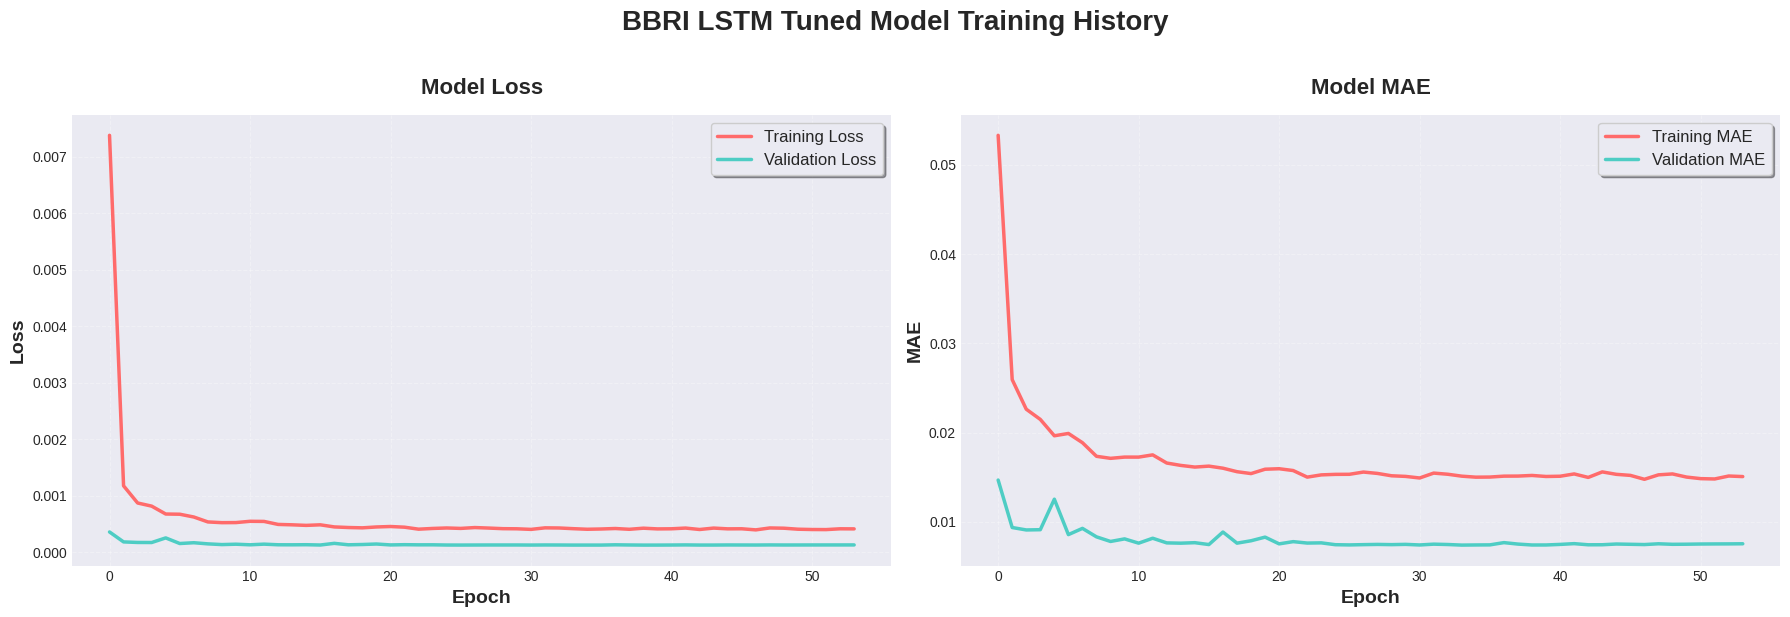

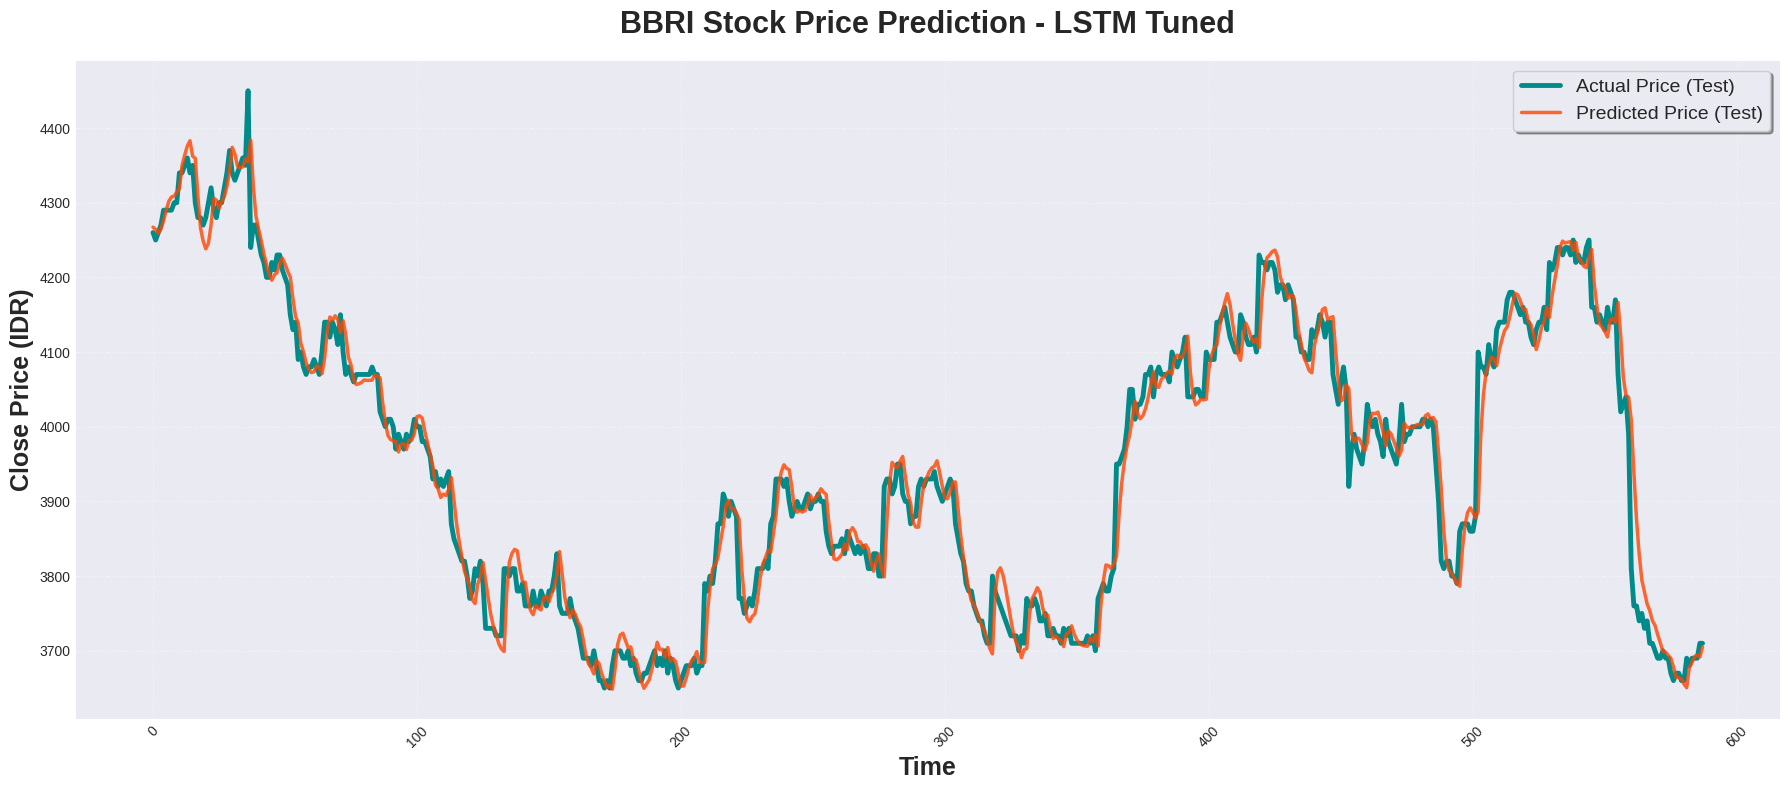

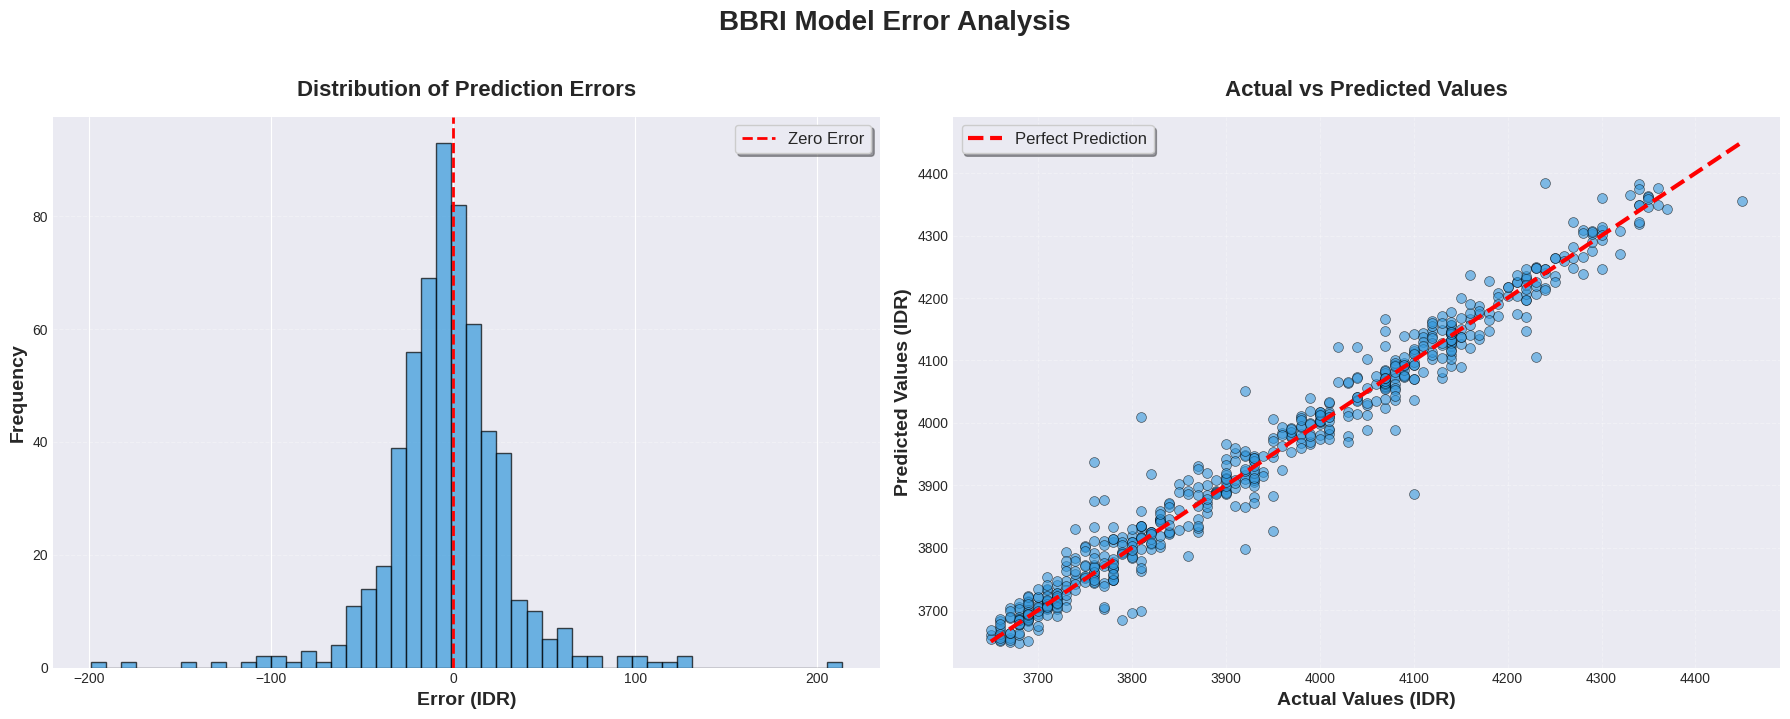

In [86]:
# Visualization
print("\n" + "="*100)
print("GENERATING LSTM Model VISUALIZATIONS")
print("="*100)

# Training History - BBRI LSTM Tuned
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('BBRI LSTM Tuned Model Training History', fontsize=20, fontweight='bold', y=1.02)

axes[0].plot(history_lstm_BBRI.history['loss'], label='Training Loss', linewidth=2.5, color='#FF6B6B')
axes[0].plot(history_lstm_BBRI.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#4ECDC4')
axes[0].set_title('Model Loss', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--')

axes[1].plot(history_lstm_BBRI.history['mae'], label='Training MAE', linewidth=2.5, color='#FF6B6B')
axes[1].plot(history_lstm_BBRI.history['val_mae'], label='Validation MAE', linewidth=2.5, color='#4ECDC4')
axes[1].set_title('Model MAE', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
print("="*100)

# Predictions vs Actual - BBRI LSTM Tuned
plt.figure(figsize=(18, 8))
plt.title('BBRI Stock Price Prediction - LSTM Tuned', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')
plot_indices = df_BBRI.index[train_size_BBRI + window_size_B:]
plt.plot(y_test_actual, label='Actual Price (Test)', color='#008B8B', linewidth=3.5)
plt.plot(predictions, label='Predicted Price (Test)', color='#FF4500', linewidth=2.5, alpha=0.8)
plt.xticks(rotation=45)
plt.legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()
print("="*100)

# Error Analysis - BBRI LSTM Tuned
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('BBRI LSTM Tuned Model Error Analysis', fontsize=20, fontweight='bold', y=1.02)

errors = y_test_actual - predictions
axes[0].hist(errors, bins=50, edgecolor='black', color='#3498DB', alpha=0.7)
axes[0].set_title('Distribution of Prediction Errors', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Error (IDR)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--', axis='y')

axes[1].scatter(y_test_actual, predictions, alpha=0.6, s=50, color='#3498DB', edgecolors='black', linewidth=0.5)
axes[1].plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=3, label='Perfect Prediction')
axes[1].set_title('Actual vs Predicted Values', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Actual Values (IDR)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Predicted Values (IDR)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


GENERATING CNN1D MODEL VISUALIZATIONS


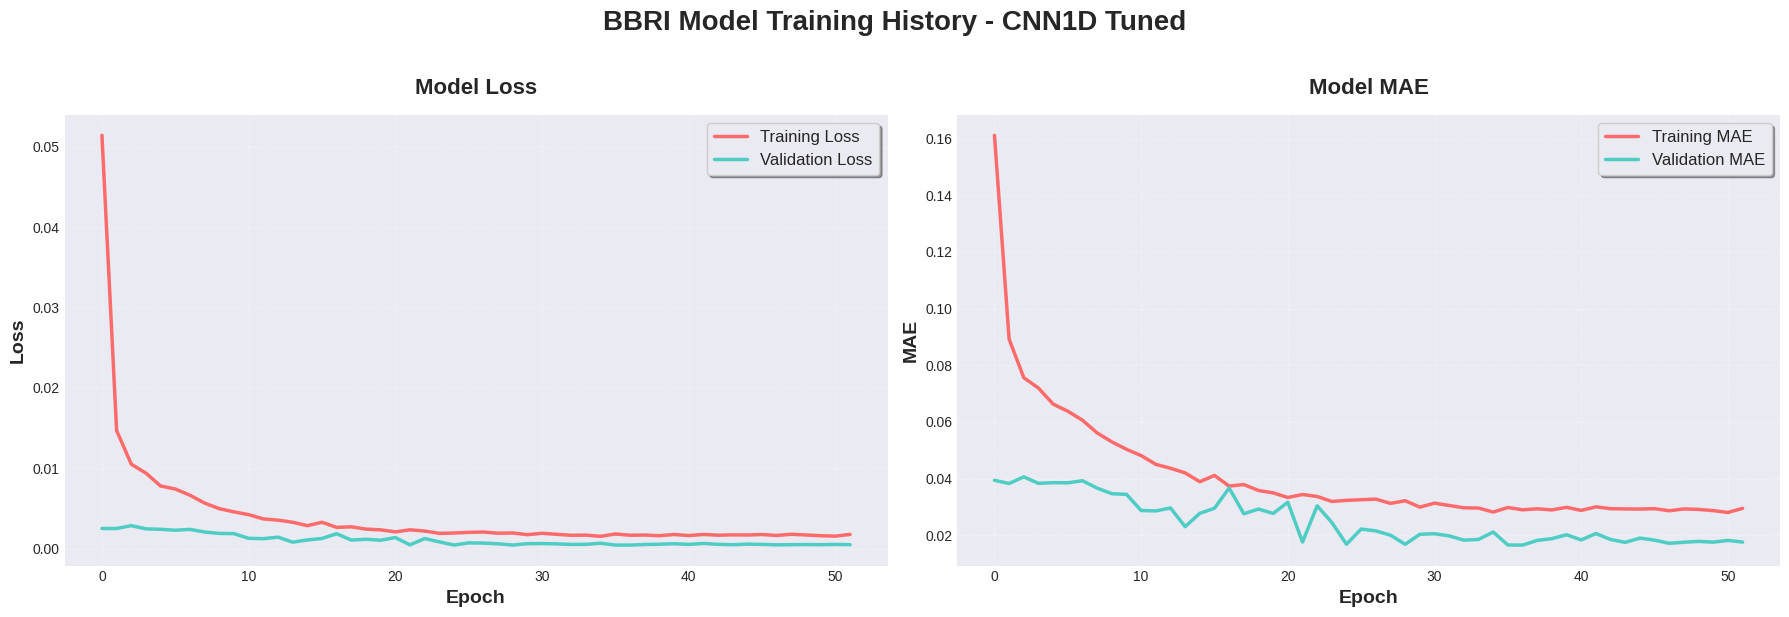

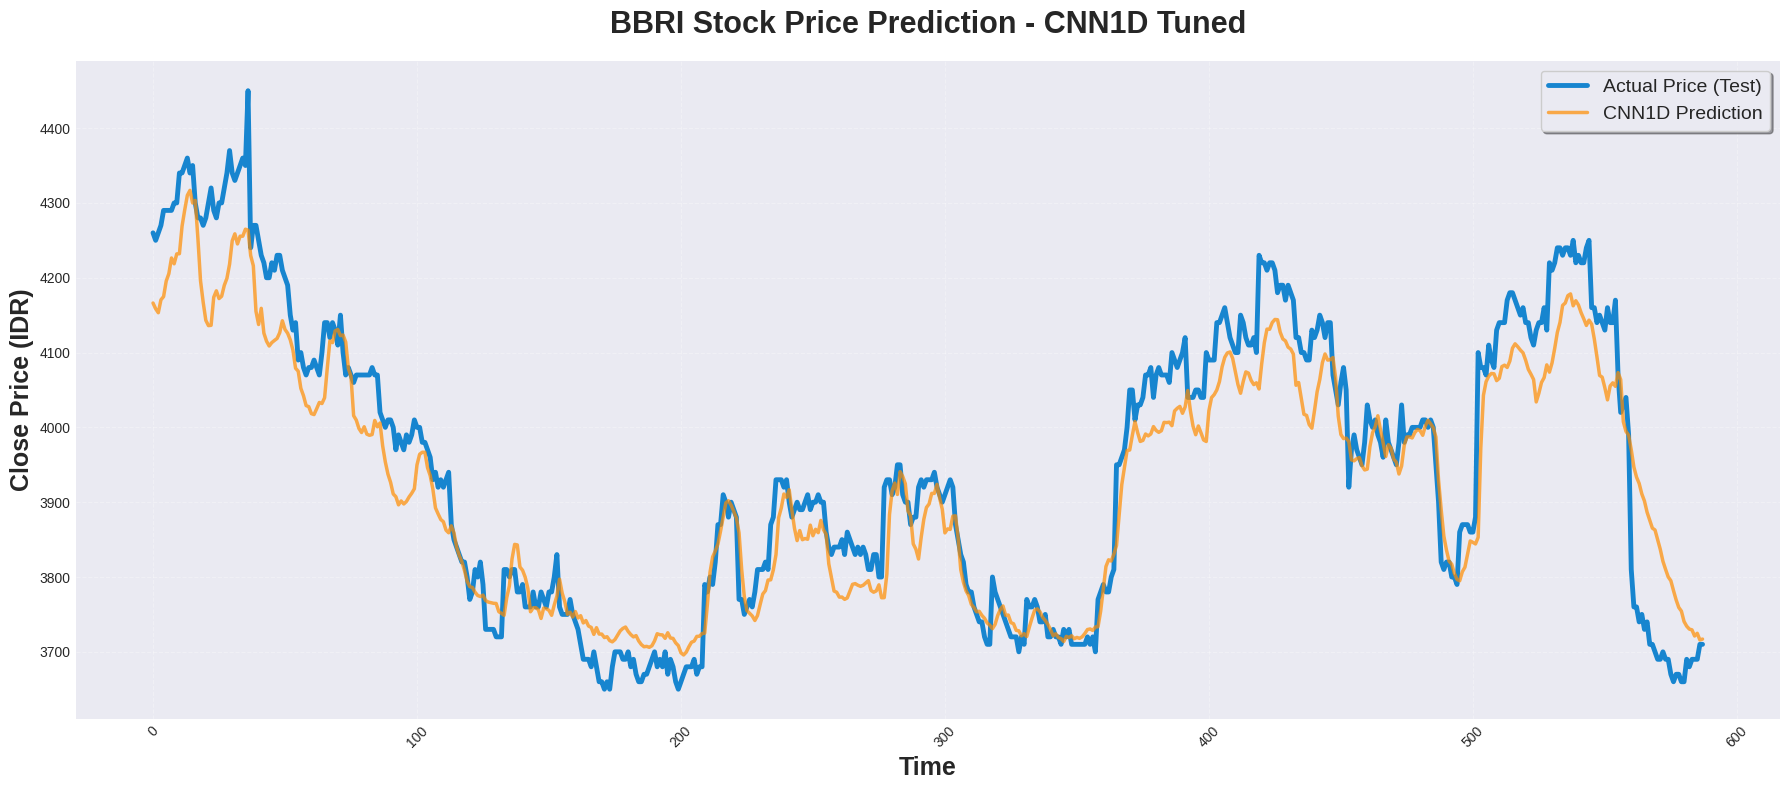

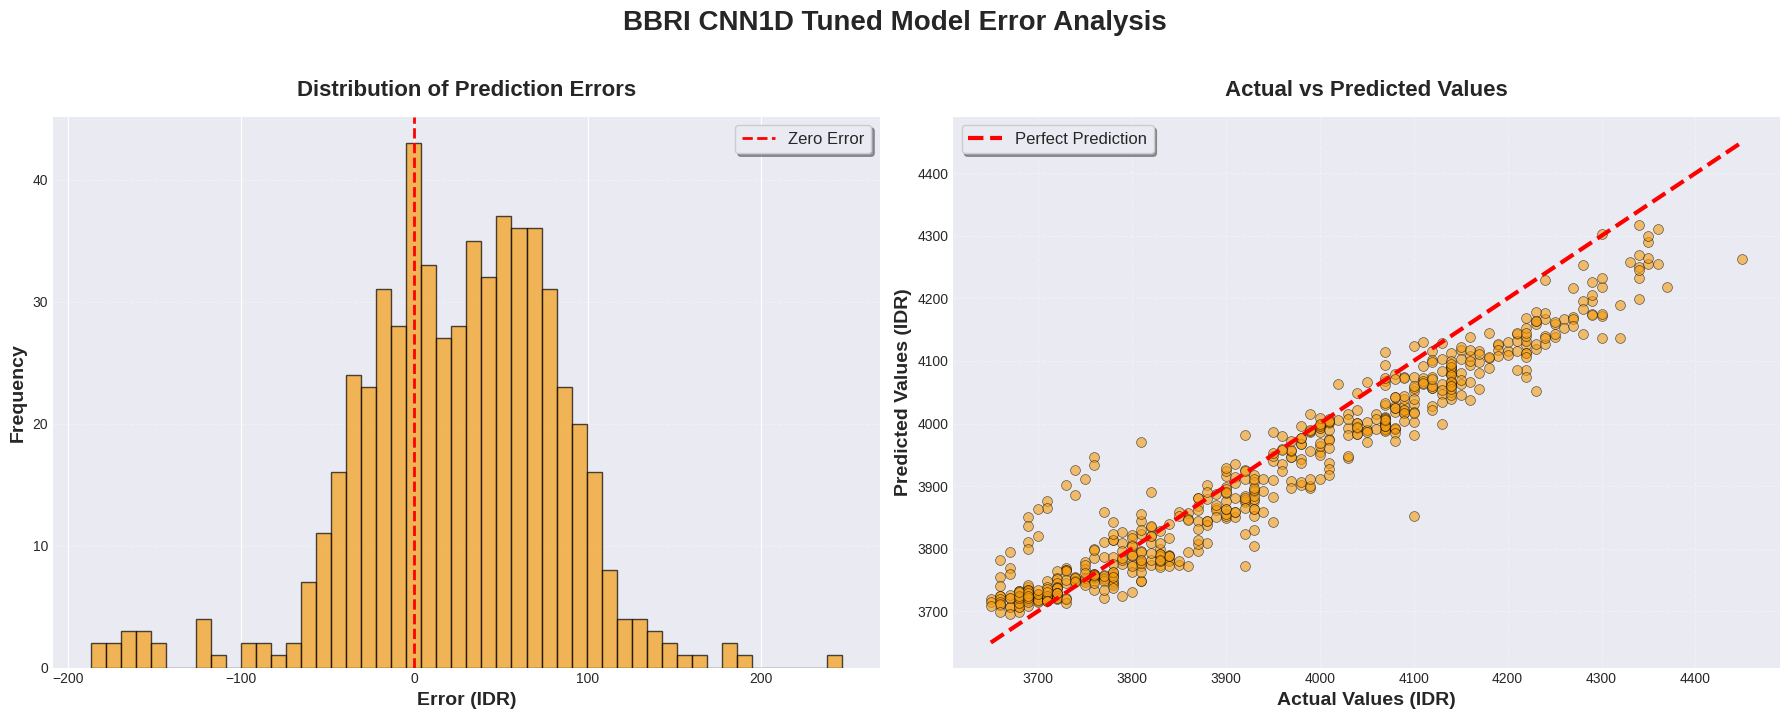

In [87]:
print("\n" + "="*100)
print("GENERATING CNN1D MODEL VISUALIZATIONS")
print("="*100)

# Training History - CNN1D BBRI
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('BBRI Model Training History - CNN1D Tuned', fontsize=20, fontweight='bold', y=1.02)

axes[0].plot(history_cnn_BBRI.history['loss'], label='Training Loss', linewidth=2.5, color='#FF6B6B')
axes[0].plot(history_cnn_BBRI.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#4ECDC4')
axes[0].set_title('Model Loss', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--')

axes[1].plot(history_cnn_BBRI.history['mae'], label='Training MAE', linewidth=2.5, color='#FF6B6B')
axes[1].plot(history_cnn_BBRI.history['val_mae'], label='Validation MAE', linewidth=2.5, color='#4ECDC4')
axes[1].set_title('Model MAE', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
print("="*100)

# Predictions Comparison - CNN1D Tuned BBRI
plt.figure(figsize=(18, 8))
plt.title('BBRI Stock Price Prediction - CNN1D Tuned', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')
plt.plot(y_test_actual, label='Actual Price (Test)', color='#007ACC', linewidth=3.5, alpha=0.9)
plt.plot(predictions_cnn, label='CNN1D Prediction', color='#FF8C00', linewidth=2.5, alpha=0.7)
plt.legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("="*100)

# Error Analysis - CNN1D Tuned BBRI
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('BBRI CNN1D Tuned Model Error Analysis', fontsize=20, fontweight='bold', y=1.02)

errors_cnn = y_test_actual - predictions_cnn
axes[0].hist(errors_cnn, bins=50, edgecolor='black', color='#F39C12', alpha=0.7)
axes[0].set_title('Distribution of Prediction Errors', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Error (IDR)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--', axis='y')

axes[1].scatter(y_test_actual, predictions_cnn, alpha=0.6, s=50, color='#F39C12', edgecolors='black', linewidth=0.5)
axes[1].plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=3, label='Perfect Prediction')
axes[1].set_title('Actual vs Predicted Values', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Actual Values (IDR)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Predicted Values (IDR)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


GENERATING ENSEMBLE MODEL VISUALIZATIONS


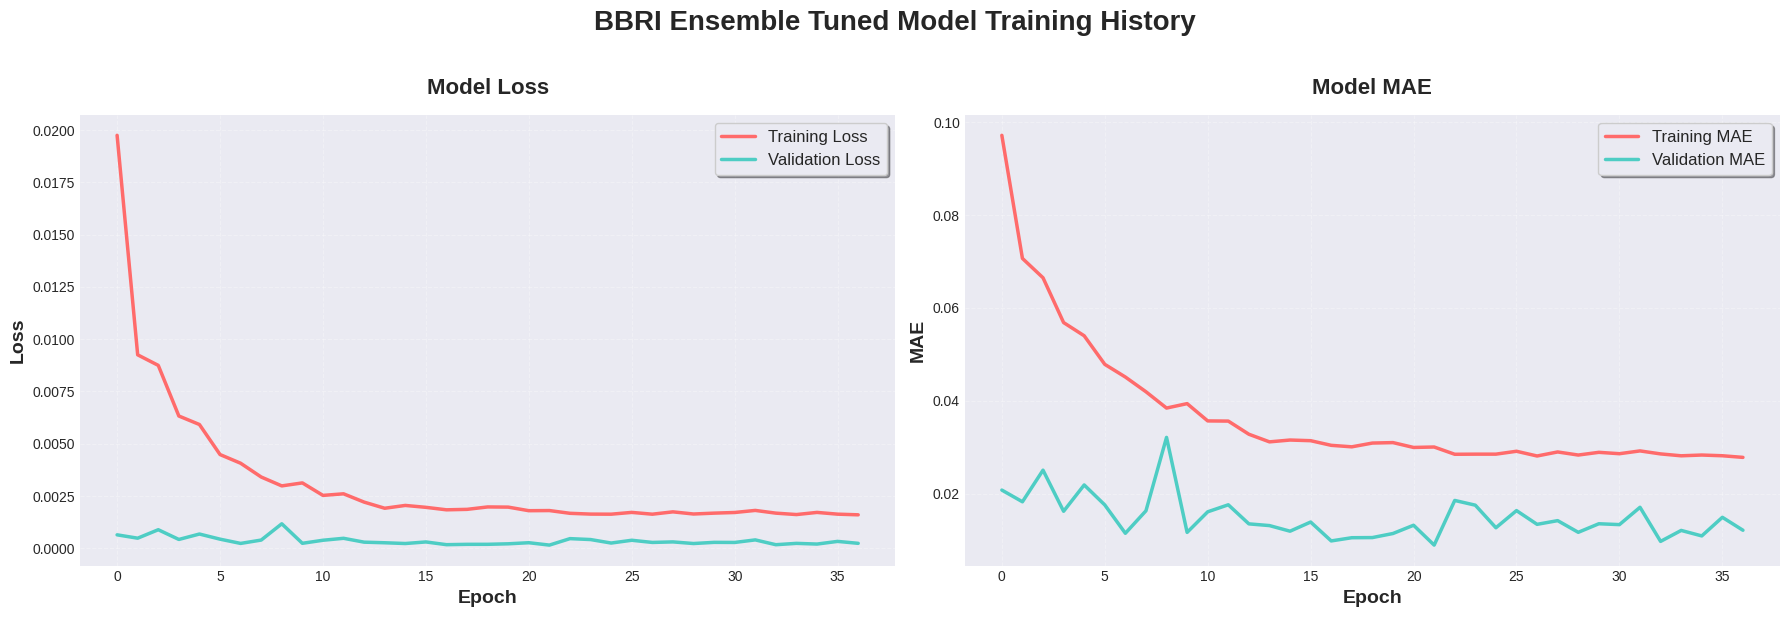

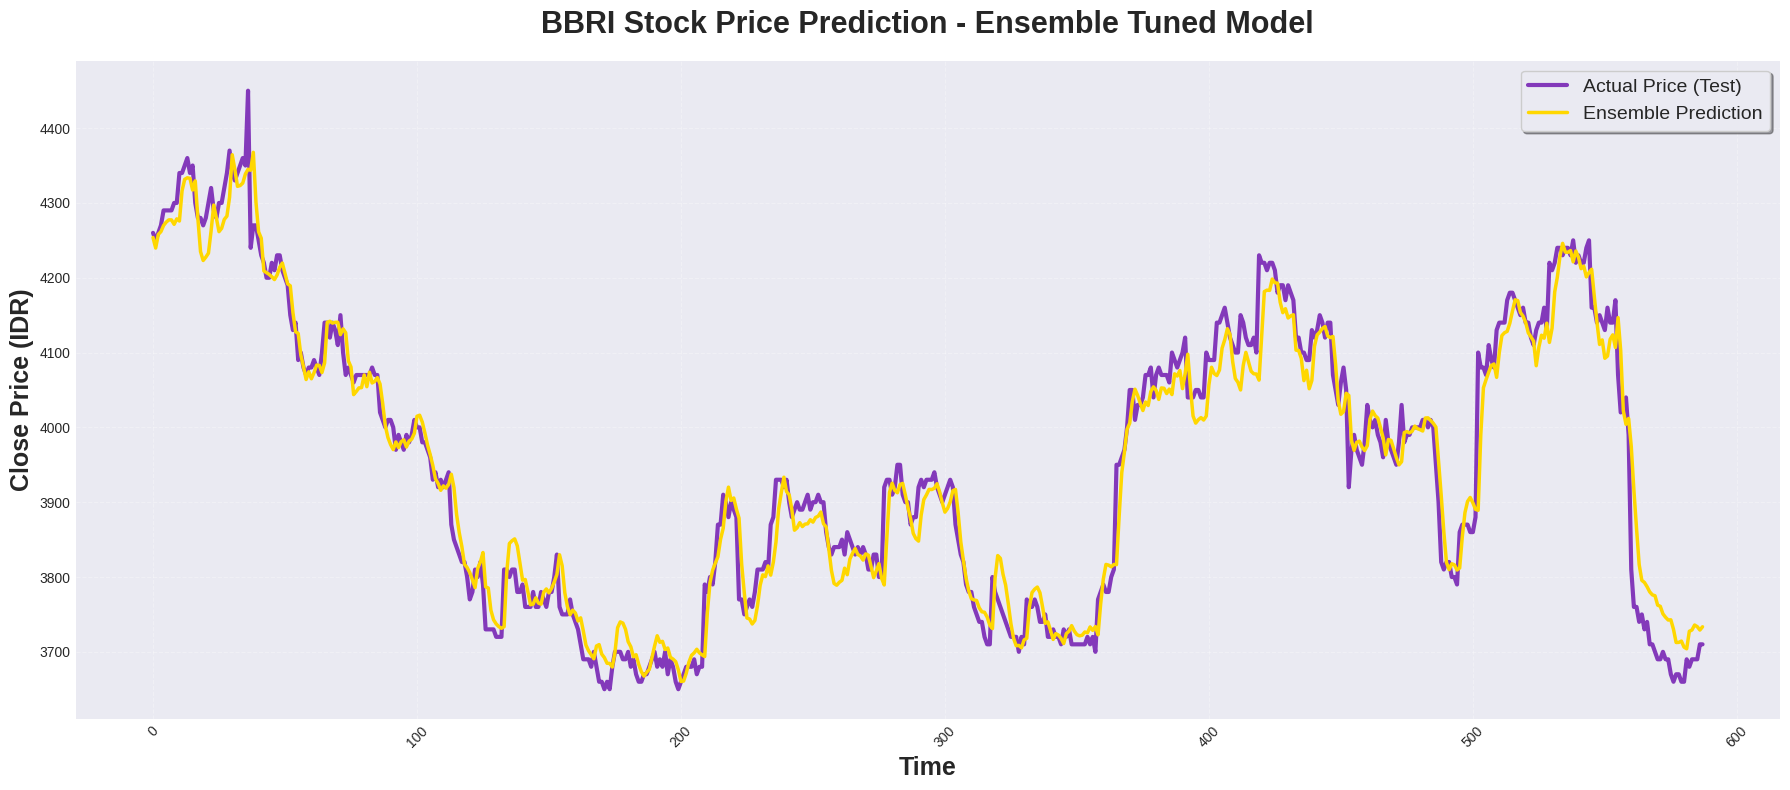

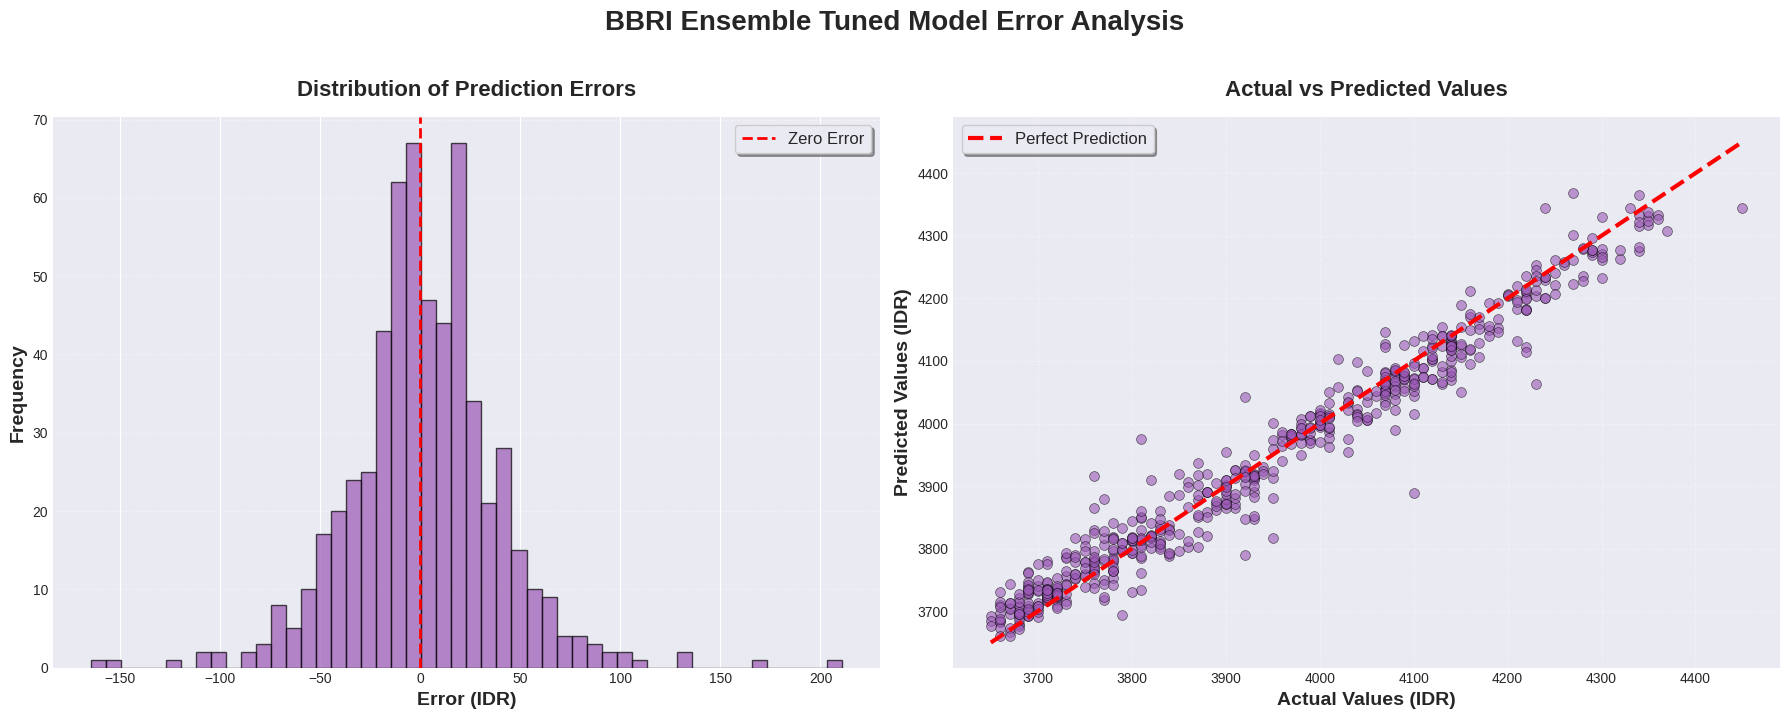

In [88]:
print("\n" + "="*100)
print("GENERATING ENSEMBLE MODEL VISUALIZATIONS")
print("="*100)

# Training History - Ensemble Tuned BBRI
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('BBRI Ensemble Tuned Model Training History', fontsize=20, fontweight='bold', y=1.02)

axes[0].plot(history_ensemble_BBRI.history['loss'], label='Training Loss', linewidth=2.5, color='#FF6B6B')
axes[0].plot(history_ensemble_BBRI.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#4ECDC4')
axes[0].set_title('Model Loss', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--')

axes[1].plot(history_ensemble_BBRI.history['mae'], label='Training MAE', linewidth=2.5, color='#FF6B6B')
axes[1].plot(history_ensemble_BBRI.history['val_mae'], label='Validation MAE', linewidth=2.5, color='#4ECDC4')
axes[1].set_title('Model MAE', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
print("="*100)

# Predictions Comparison - Ensemble Tuned BBRI
plt.figure(figsize=(18, 8))
plt.title('BBRI Stock Price Prediction - Ensemble Tuned Model', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')
plt.plot(y_test_actual, label='Actual Price (Test)', color='#6A0DAD', linewidth=3, alpha=0.8)
plt.plot(predictions_ensemble, label='Ensemble Prediction', color='#FFD700', linewidth=2.5)
plt.legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("="*100)

# Error Analysis - Ensemble Tuned BBRI
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('BBRI Ensemble Tuned Model Error Analysis', fontsize=20, fontweight='bold', y=1.02)

errors_ensemble = y_test_actual - predictions_ensemble
axes[0].hist(errors_ensemble, bins=50, edgecolor='black', color='#9B59B6', alpha=0.7)
axes[0].set_title('Distribution of Prediction Errors', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Error (IDR)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--', axis='y')

axes[1].scatter(y_test_actual, predictions_ensemble, alpha=0.6, s=50, color='#9B59B6', edgecolors='black', linewidth=0.5)
axes[1].plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=3, label='Perfect Prediction')
axes[1].set_title('Actual vs Predicted Values', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Actual Values (IDR)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Predicted Values (IDR)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


GENERATING LSTM MODEL VISUALIZATIONS


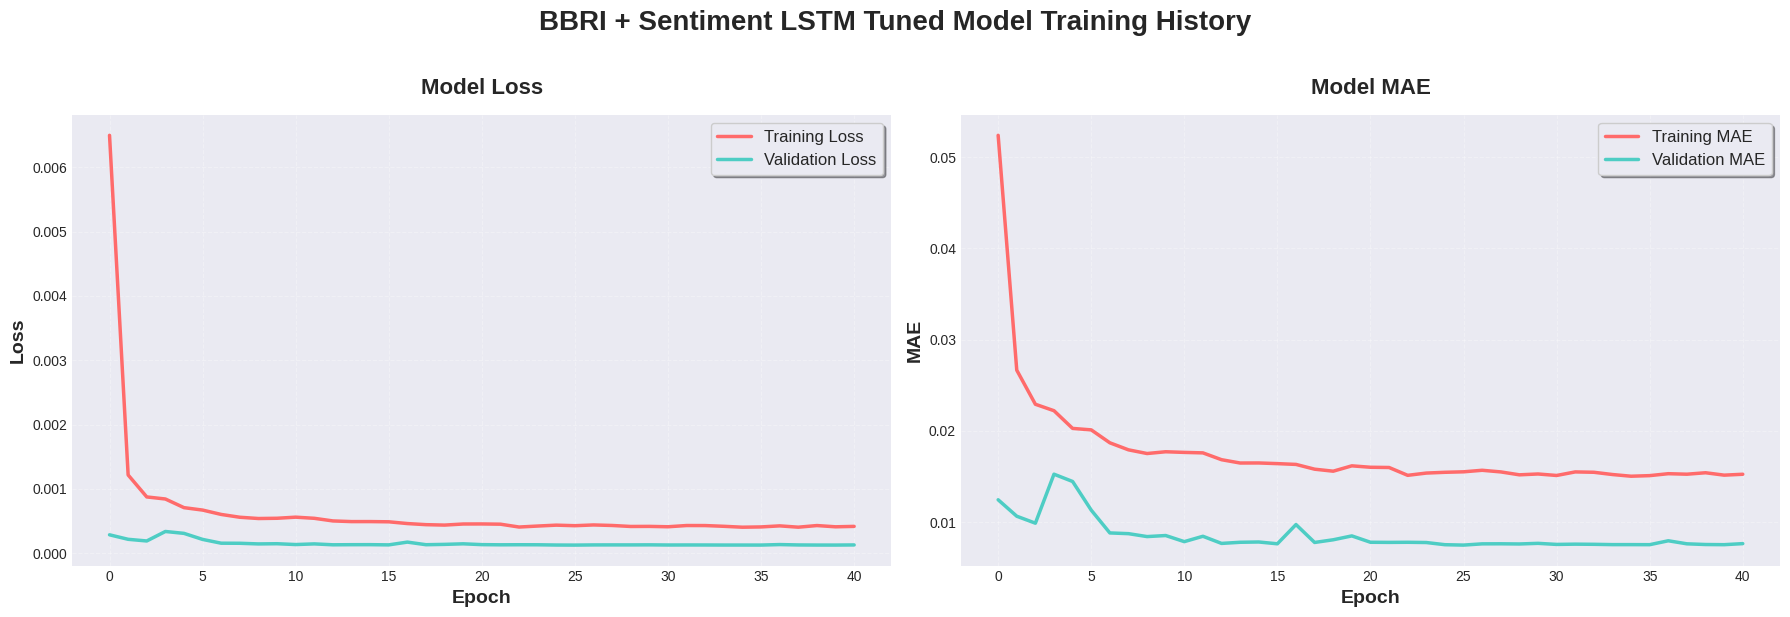

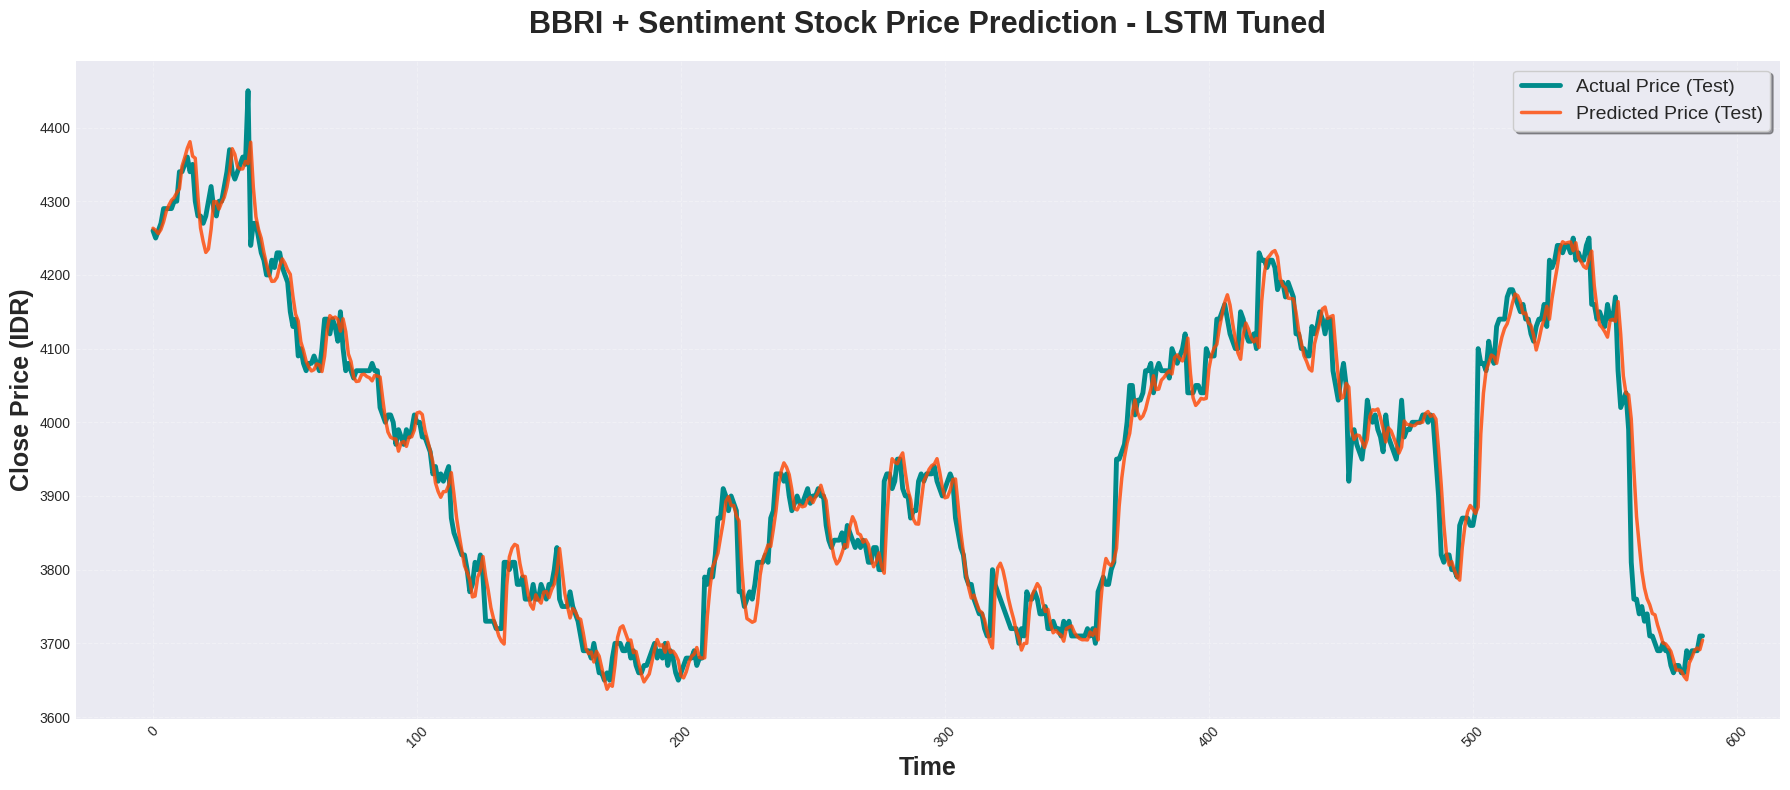

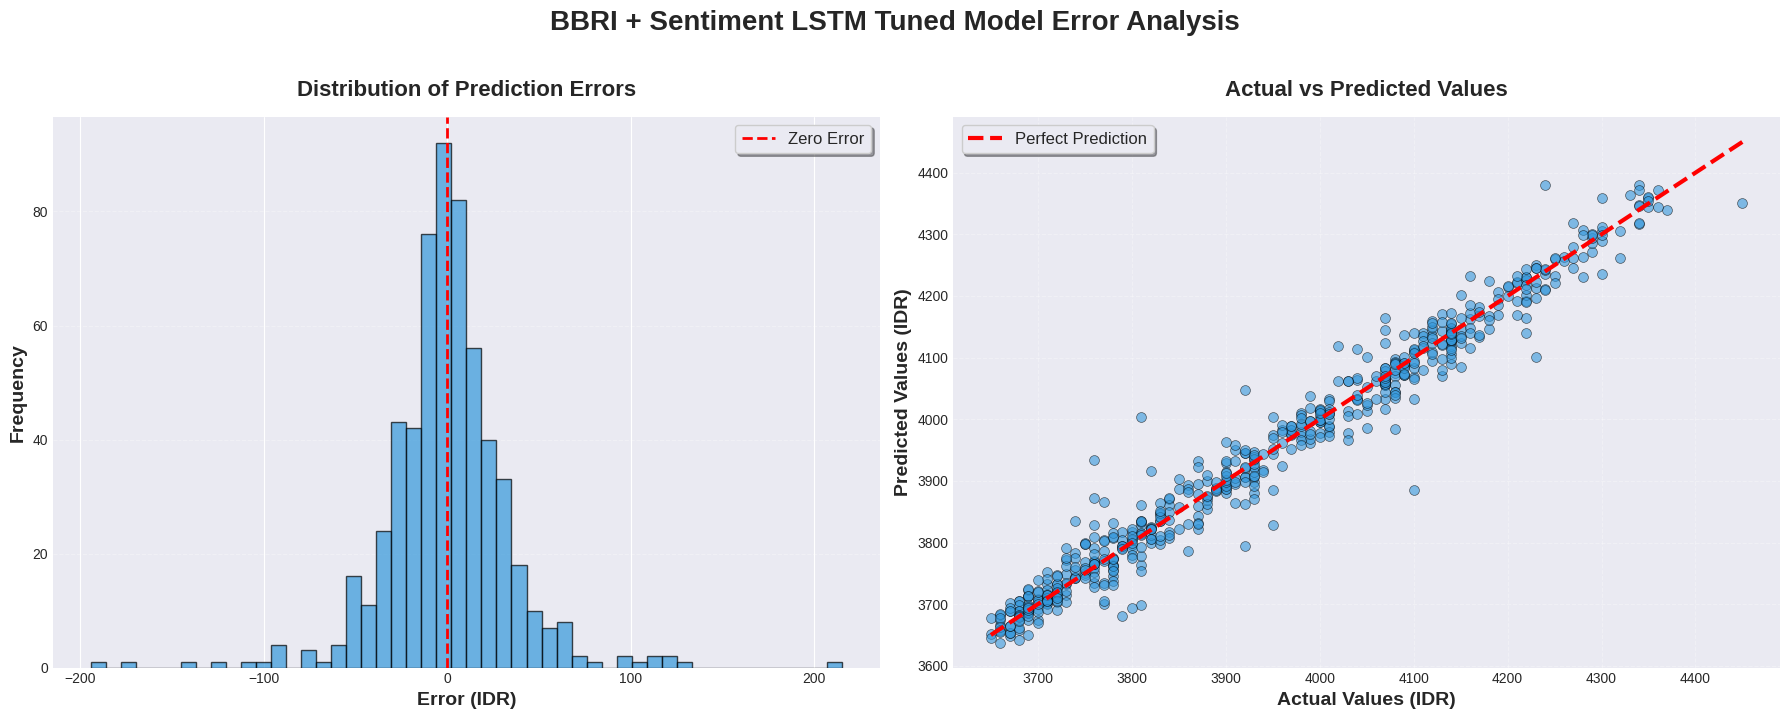

In [94]:
# Visualization
print("\n" + "="*100)
print("GENERATING LSTM MODEL VISUALIZATIONS")
print("="*100)

# Training History - LSTM Tuned BBRI + Sentiment
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('BBRI + Sentiment LSTM Tuned Model Training History', fontsize=20, fontweight='bold', y=1.02)

axes[0].plot(history_lstm_BBRI_Full.history['loss'], label='Training Loss', linewidth=2.5, color='#FF6B6B')
axes[0].plot(history_lstm_BBRI_Full.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#4ECDC4')
axes[0].set_title('Model Loss', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--')

axes[1].plot(history_lstm_BBRI_Full.history['mae'], label='Training MAE', linewidth=2.5, color='#FF6B6B')
axes[1].plot(history_lstm_BBRI_Full.history['val_mae'], label='Validation MAE', linewidth=2.5, color='#4ECDC4')
axes[1].set_title('Model MAE', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
print("="*100)

# Predictions vs Actual - LSTM Tuned BBRI + Sentiment
plt.figure(figsize=(18, 8))
plt.title('BBRI + Sentiment Stock Price Prediction - LSTM Tuned', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')
plot_indices = df_BBRI_Full.index[train_size_BBRI_Full + window_size_Full:]
plt.plot(y_test_actual_Full, label='Actual Price (Test)', color='#008B8B', linewidth=3.5)
plt.plot(predictions_Full, label='Predicted Price (Test)', color='#FF4500', linewidth=2.5, alpha=0.8)
plt.legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("="*100)

# Error Analysis - LSTM Tuned BBRI + Sentiment
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('BBRI + Sentiment LSTM Tuned Model Error Analysis', fontsize=20, fontweight='bold', y=1.02)

errors_Full = y_test_actual_Full - predictions_Full
axes[0].hist(errors_Full, bins=50, edgecolor='black', color='#3498DB', alpha=0.7)
axes[0].set_title('Distribution of Prediction Errors', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Error (IDR)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--', axis='y')

axes[1].scatter(y_test_actual_Full, predictions_Full, alpha=0.6, s=50, color='#3498DB', edgecolors='black', linewidth=0.5)
axes[1].plot([y_test_actual_Full.min(), y_test_actual_Full.max()],
         [y_test_actual_Full.min(), y_test_actual_Full.max()],
         'r--', lw=3, label='Perfect Prediction')
axes[1].set_title('Actual vs Predicted Values', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Actual Values (IDR)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Predicted Values (IDR)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


GENERATING CNN1D MODEL VISUALIZATIONS


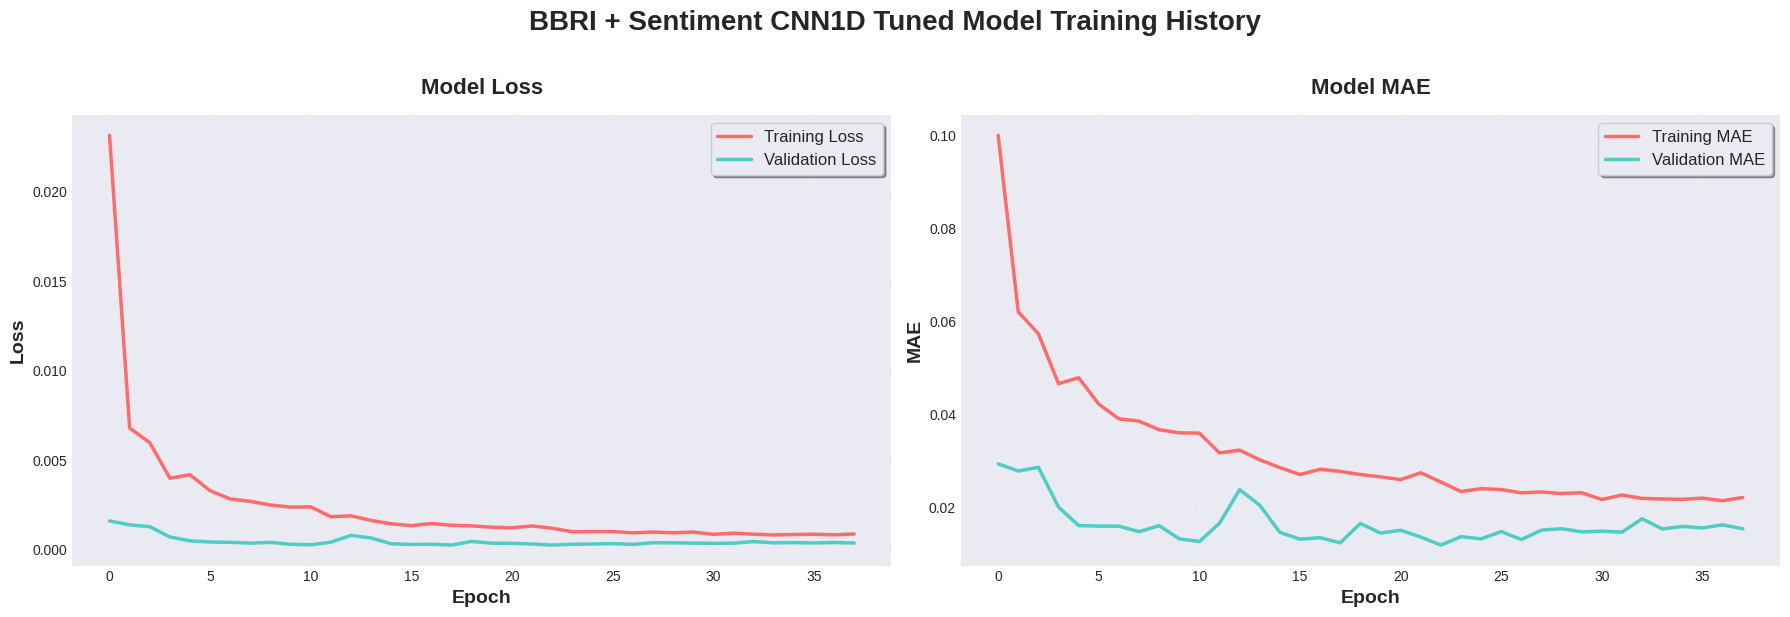

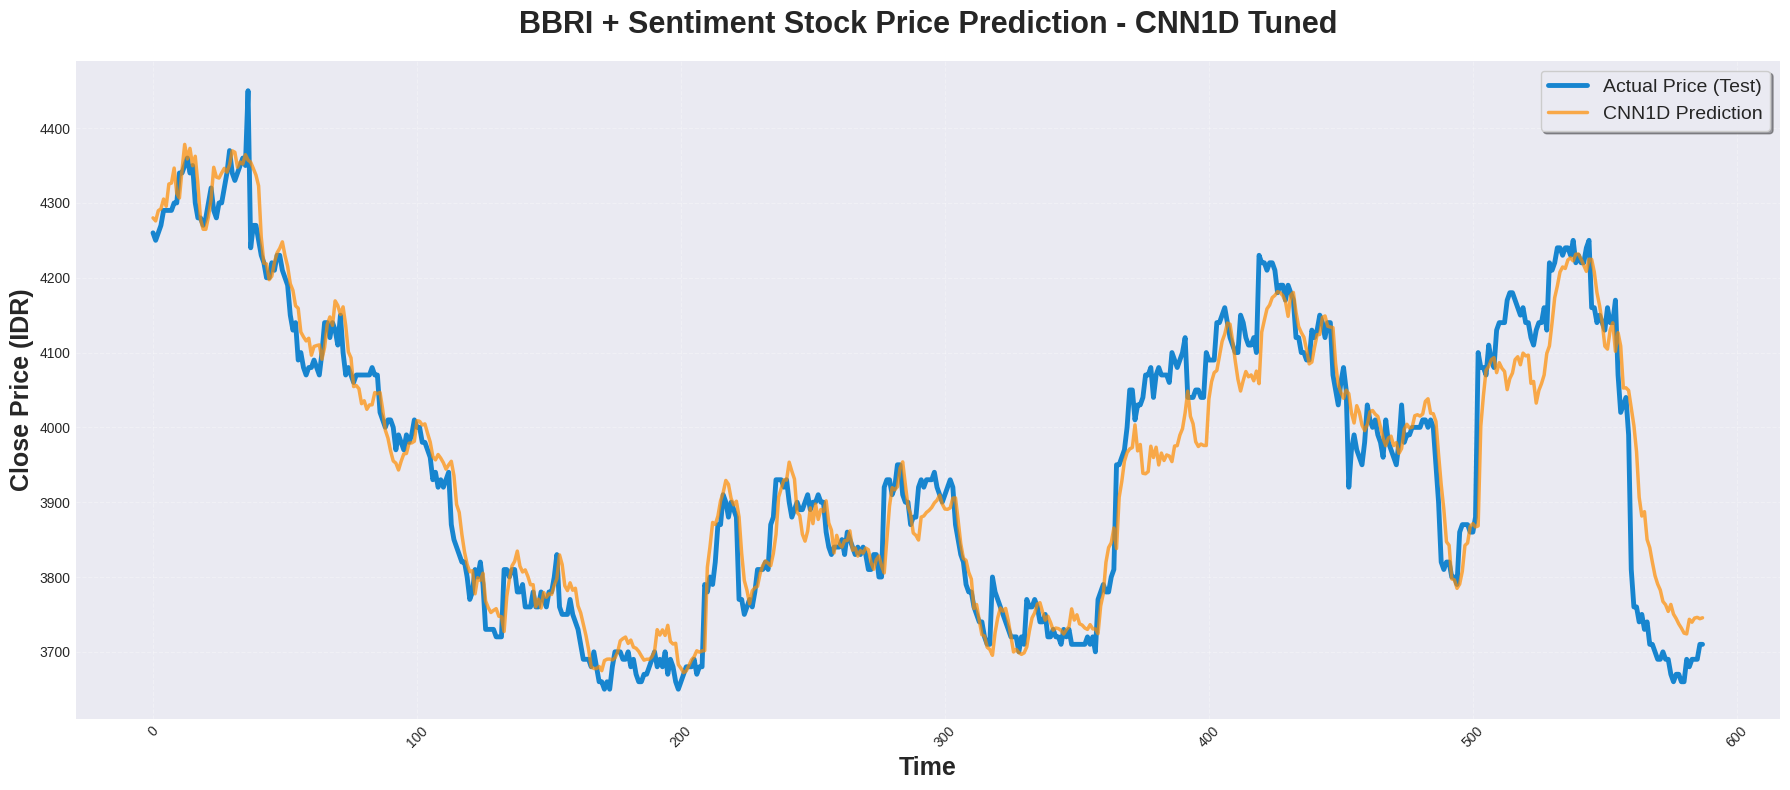

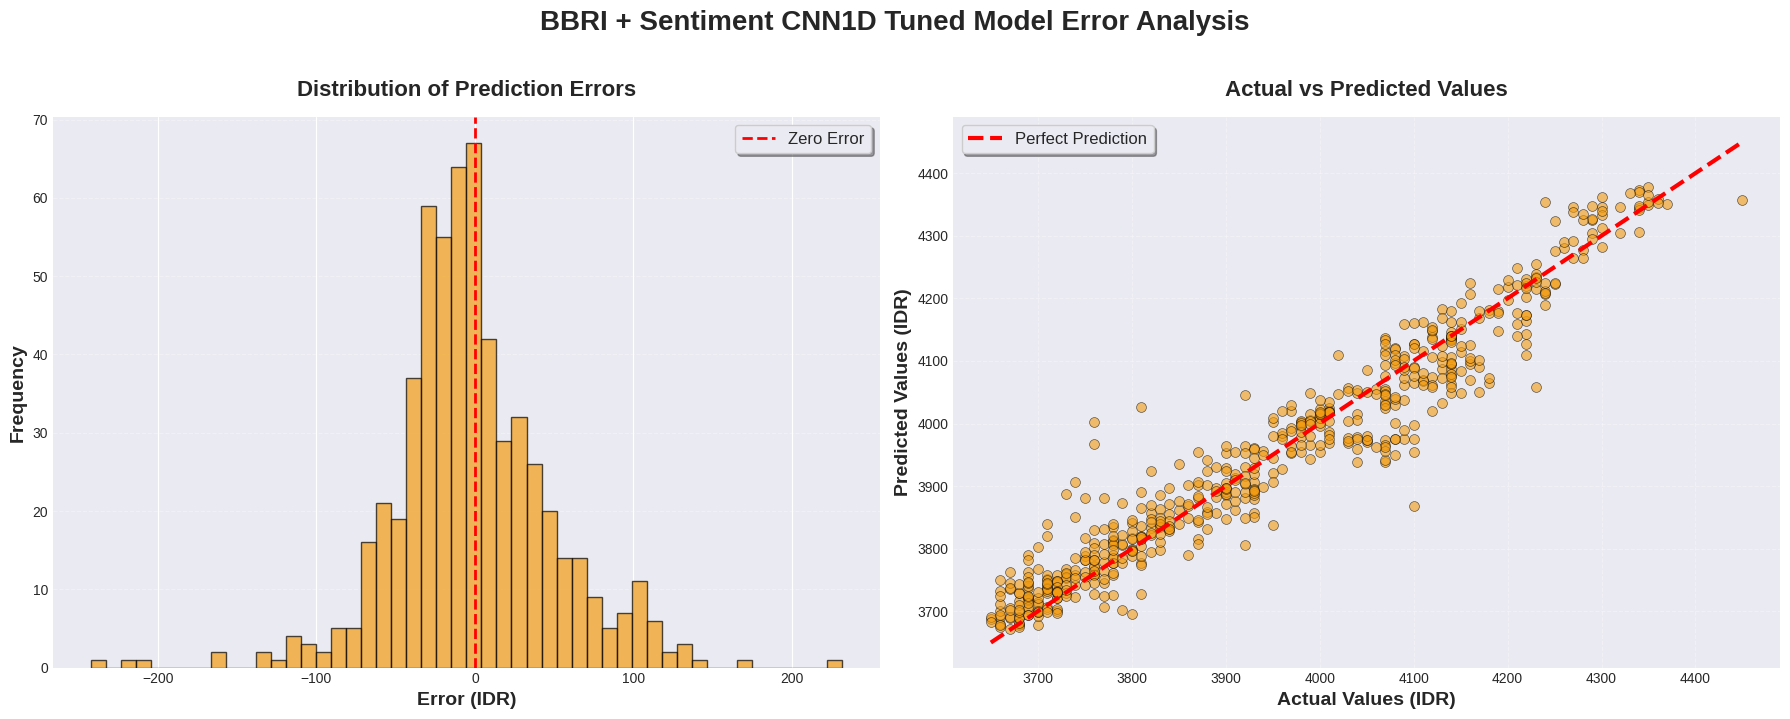

In [96]:
print("\n" + "="*100)
print("GENERATING CNN1D MODEL VISUALIZATIONS")
print("="*100)

# Training History - CNN1D Tuned BBRI + Sentiment
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('BBRI + Sentiment CNN1D Tuned Model Training History', fontsize=20, fontweight='bold', y=1.02)

axes[0].plot(history_cnn_BBRI_Full.history['loss'], label='Training Loss', linewidth=2.5, color='#FF6B6B')
axes[0].plot(history_cnn_BBRI_Full.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#4ECDC4')
axes[0].set_title('Model Loss', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--')

axes[1].plot(history_cnn_BBRI_Full.history['mae'], label='Training MAE', linewidth=2.5, color='#FF6B6B')
axes[1].plot(history_cnn_BBRI_Full.history['val_mae'], label='Validation MAE', linewidth=2.5, color='#4ECDC4')
axes[1].set_title('Model MAE', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
print("="*100)

# Predictions Comparison - CNN1D Tuned BBRI + Sentiment
plt.figure(figsize=(18, 8))
plt.title('BBRI + Sentiment Stock Price Prediction - CNN1D Tuned', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')
plt.plot(y_test_actual_Full, label='Actual Price (Test)', color='#007ACC', linewidth=3.5, alpha=0.9)
plt.plot(predictions_cnn_Full, label='CNN1D Prediction', color='#FF8C00', linewidth=2.5, alpha=0.7)
plt.legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("="*100)

# Error Analysis - CNN1D Tuned BBRI + Sentiment
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('BBRI + Sentiment CNN1D Tuned Model Error Analysis', fontsize=20, fontweight='bold', y=1.02)

errors_cnn_Full = y_test_actual_Full - predictions_cnn_Full
axes[0].hist(errors_cnn_Full, bins=50, edgecolor='black', color='#F39C12', alpha=0.7)
axes[0].set_title('Distribution of Prediction Errors', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Error (IDR)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--', axis='y')

axes[1].scatter(y_test_actual_Full, predictions_cnn_Full, alpha=0.6, s=50, color='#F39C12', edgecolors='black', linewidth=0.5)
axes[1].plot([y_test_actual_Full.min(), y_test_actual_Full.max()],
         [y_test_actual_Full.min(), y_test_actual_Full.max()],
         'r--', lw=3, label='Perfect Prediction')
axes[1].set_title('Actual vs Predicted Values', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Actual Values (IDR)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Predicted Values (IDR)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


GENERATING ENSEMBLE MODEL VISUALIZATIONS


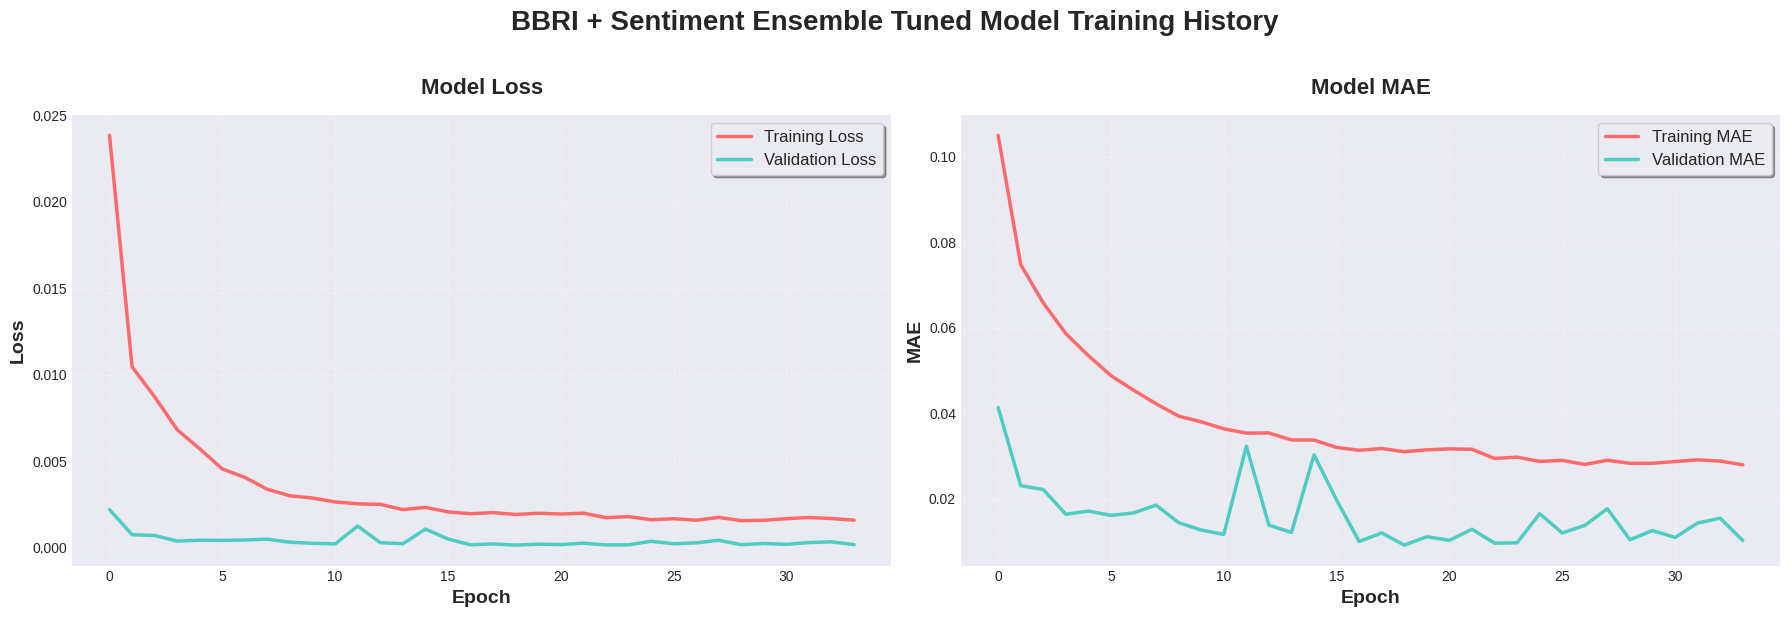

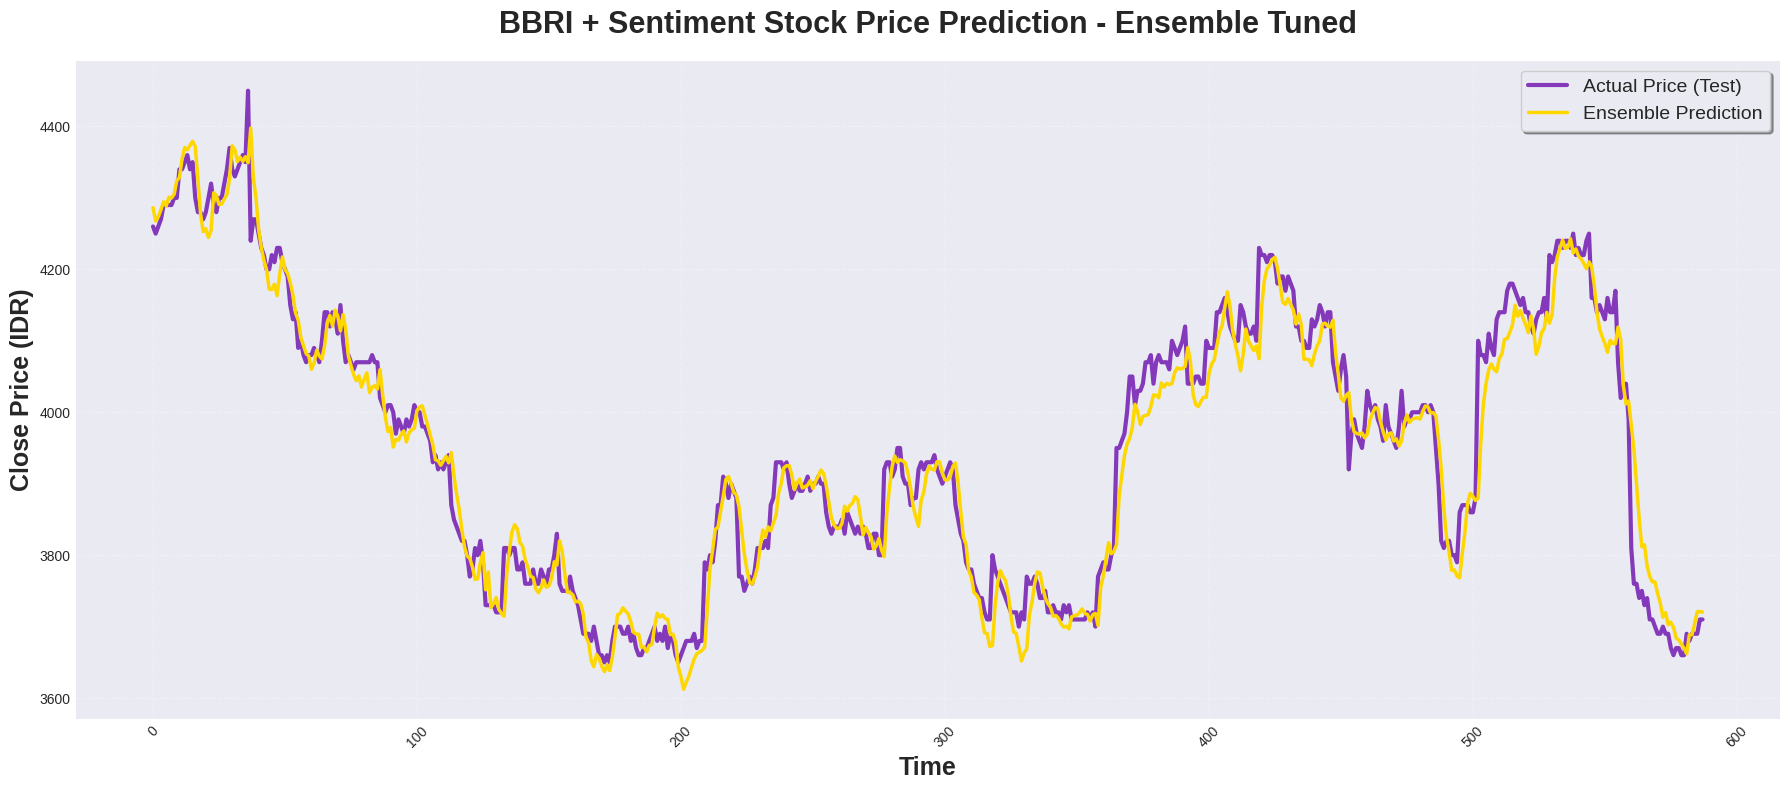

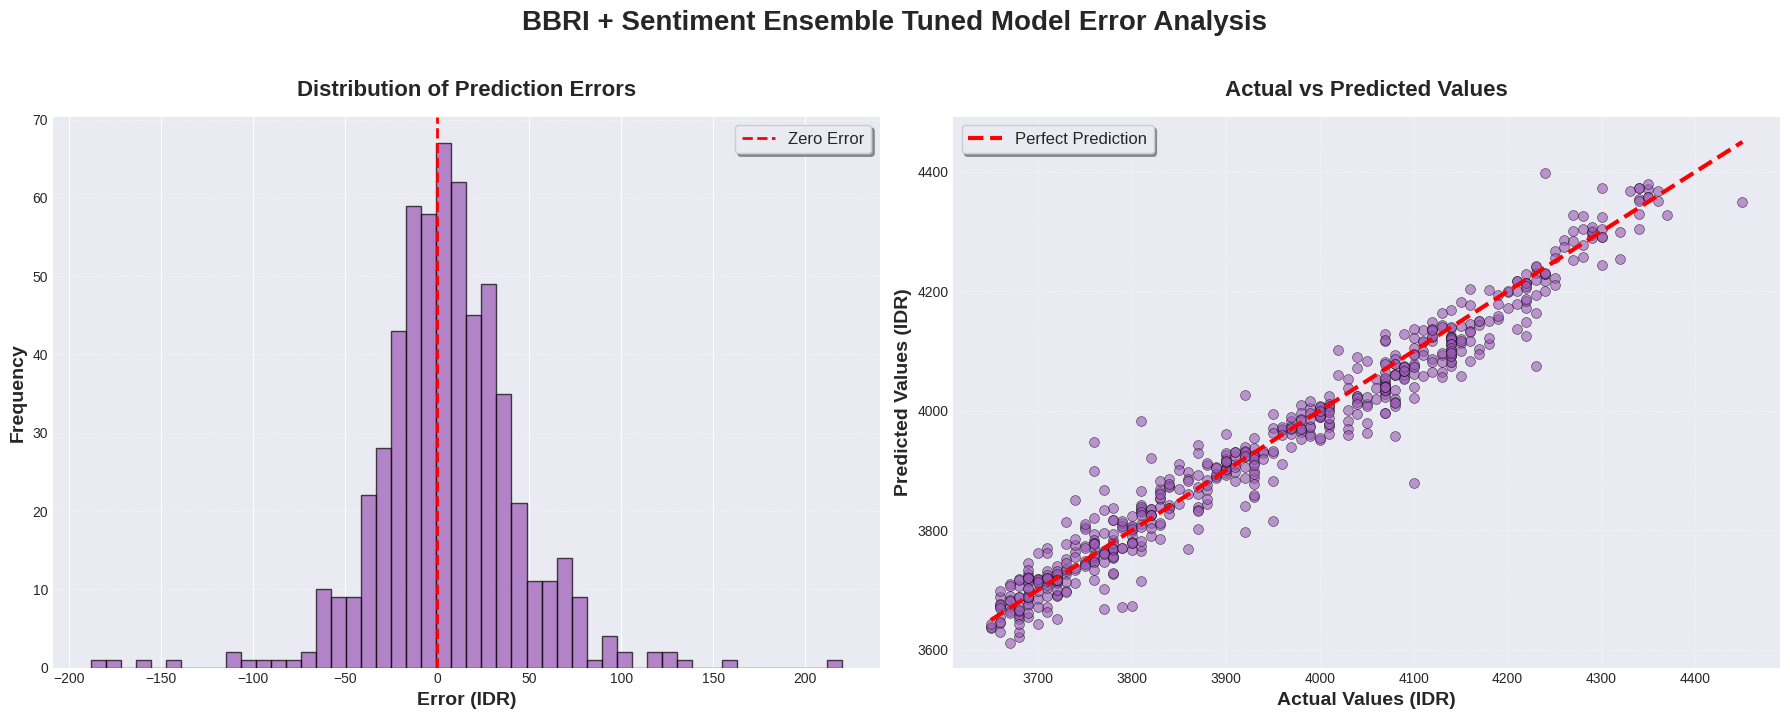

In [97]:
print("\n" + "="*100)
print("GENERATING ENSEMBLE MODEL VISUALIZATIONS")
print("="*100)

# Training History - Ensemble Tuned BBRI + Sentiment
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('BBRI + Sentiment Ensemble Tuned Model Training History', fontsize=20, fontweight='bold', y=1.02)

axes[0].plot(history_ensemble_BBRI_Full.history['loss'], label='Training Loss', linewidth=2.5, color='#FF6B6B')
axes[0].plot(history_ensemble_BBRI_Full.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#4ECDC4')
axes[0].set_title('Model Loss', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--')

axes[1].plot(history_ensemble_BBRI_Full.history['mae'], label='Training MAE', linewidth=2.5, color='#FF6B6B')
axes[1].plot(history_ensemble_BBRI_Full.history['val_mae'], label='Validation MAE', linewidth=2.5, color='#4ECDC4')
axes[1].set_title('Model MAE', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Epoch', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
print("="*100)

# Predictions Comparison - Ensemble Tuned BBRI + Sentiment
plt.figure(figsize=(18, 8))
plt.title('BBRI + Sentiment Stock Price Prediction - Ensemble Tuned', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')
plt.plot(y_test_actual_Full, label='Actual Price (Test)', color='#6A0DAD', linewidth=3, alpha=0.8)
plt.plot(predictions_ensemble_Full, label='Ensemble Prediction', color='#FFD700', linewidth=2.5)
plt.legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("="*100)

# Error Analysis - Ensemble Tuned BBRI + Sentiment
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('BBRI + Sentiment Ensemble Tuned Model Error Analysis', fontsize=20, fontweight='bold', y=1.02)

errors_ensemble_Full = y_test_actual_Full - predictions_ensemble_Full
axes[0].hist(errors_ensemble_Full, bins=50, edgecolor='black', color='#9B59B6', alpha=0.7)
axes[0].set_title('Distribution of Prediction Errors', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Error (IDR)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--', axis='y')

axes[1].scatter(y_test_actual_Full, predictions_ensemble_Full, alpha=0.6, s=50, color='#9B59B6', edgecolors='black', linewidth=0.5)
axes[1].plot([y_test_actual_Full.min(), y_test_actual_Full.max()],
         [y_test_actual_Full.min(), y_test_actual_Full.max()],
         'r--', lw=3, label='Perfect Prediction')
axes[1].set_title('Actual vs Predicted Values', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Actual Values (IDR)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Predicted Values (IDR)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


MULTI-STEP FORECASTING: 24 HOURS AHEAD
24-hour forecasts generated: 100 values
Forecast range: 3696.68 - 3714.31


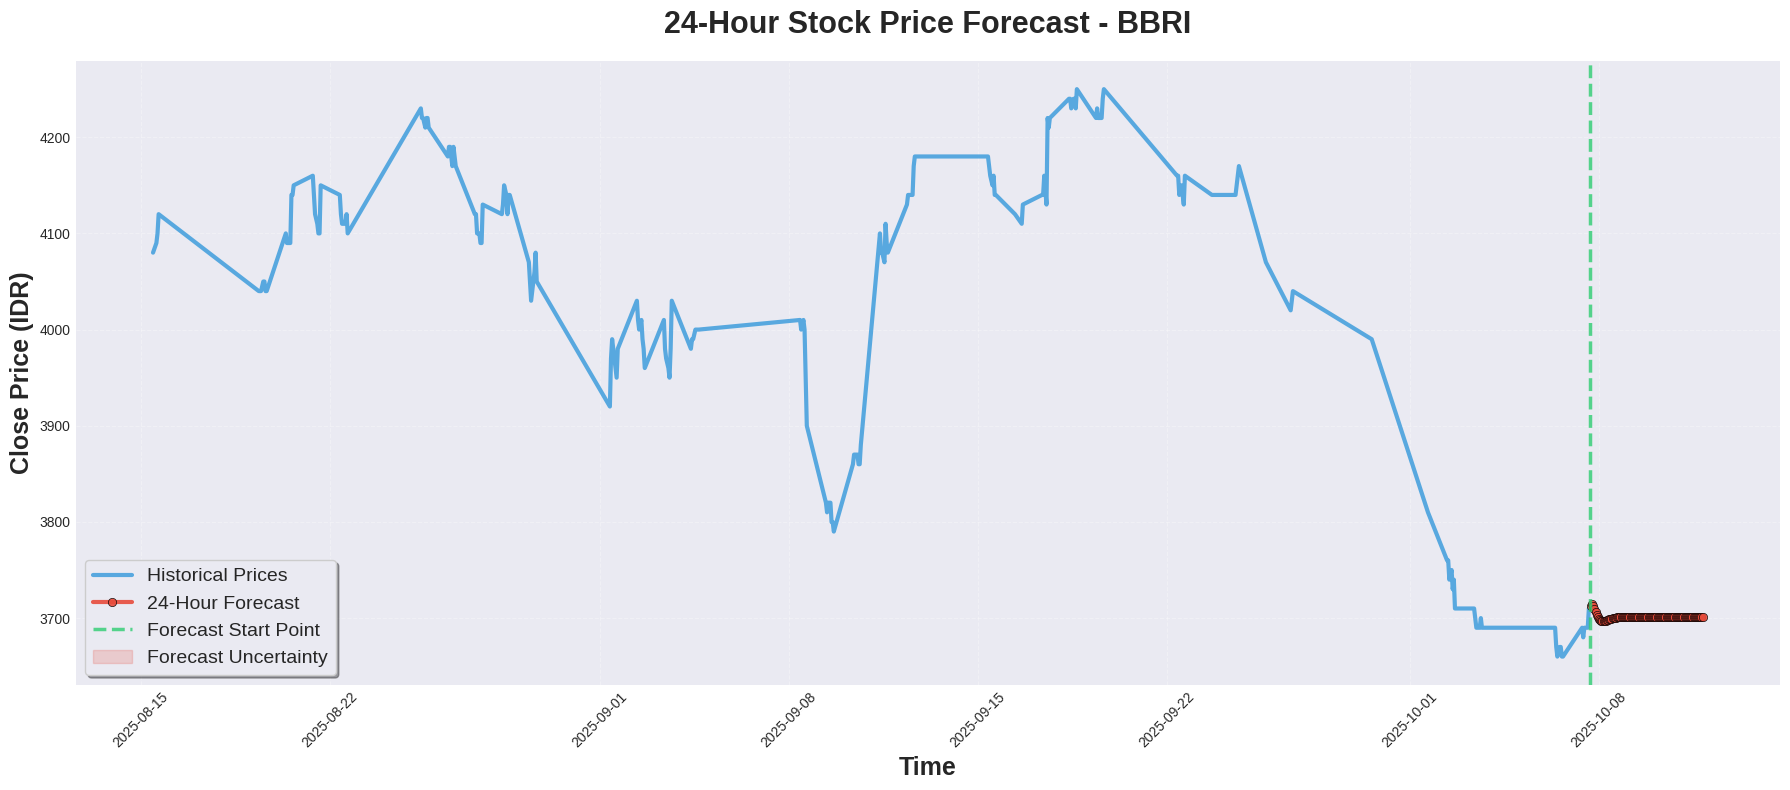

In [41]:
print("\n" + "="*100)
print("MULTI-STEP FORECASTING: 24 HOURS AHEAD")
print("="*100)

def forecast_multistep(model, last_window, scaler, target_col_idx, n_steps, n_features):
    current_window = last_window.copy()
    forecasts = []

    for step in range(n_steps):
        X_pred = current_window.reshape(1, current_window.shape[0], current_window.shape[1])
        next_pred_scaled = model.predict(X_pred, verbose=0)[0, 0]

        dummy = np.zeros((1, n_features))
        dummy[0, target_col_idx] = next_pred_scaled
        next_pred_original = scaler.inverse_transform(dummy)[0, target_col_idx]

        forecasts.append(next_pred_original)

        new_row = current_window[-1, :].copy()
        new_row[target_col_idx] = next_pred_scaled
        current_window = np.vstack([current_window[1:], new_row])

    return np.array(forecasts)

last_window_scaled_BBRI = scaled_test_data_BBRI[-window_size_B:]
forecasts_BBRI = forecast_multistep(
    model_lstm_BBRI,
    last_window_scaled_BBRI,
    scaler_BBRI,
    target_col_BBRI,
    n_steps=100,
    n_features=X_train_BBRI.shape[2]
)

print(f"24-hour forecasts generated: {len(forecasts_BBRI)} values")
print(f"Forecast range: {forecasts_BBRI.min():.2f} - {forecasts_BBRI.max():.2f}")

last_datetime_BBRI = df_BBRI.index[-1]
forecast_datetimes_BBRI = [last_datetime_BBRI + timedelta(hours=i+1) for i in range(len(forecasts_BBRI))]

# 24-Hour Forecast Visualization
plt.figure(figsize=(18, 8))
plt.title('24-Hour Stock Price Forecast - BBRI', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')

historical_data = df_BBRI['Close'].iloc[-200:]
plt.plot(historical_data.index, historical_data.values,
         label='Historical Prices', color='#3498DB', linewidth=3, alpha=0.8)
plt.plot(forecast_datetimes_BBRI, forecasts_BBRI,
         label='24-Hour Forecast', color='#E74C3C', linewidth=3, marker='o',
         markersize=6, alpha=0.9, markeredgecolor='black', markeredgewidth=0.5)
plt.axvline(x=last_datetime_BBRI, color='#2ECC71', linestyle='--', linewidth=2.5,
            label='Forecast Start Point', alpha=0.8)

# Add confidence band (simple visualization)
forecast_std = np.std(forecasts_BBRI)
plt.fill_between(forecast_datetimes_BBRI,
                 forecasts_BBRI - forecast_std,
                 forecasts_BBRI + forecast_std,
                 alpha=0.2, color='#E74C3C', label='Forecast Uncertainty')

plt.legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


MULTI-STEP FORECASTING WITH CNN1D: 100 HOURS AHEAD
CNN1D 100-hour forecasts (BBRI) generated: 100 values
Forecast range: 3673.58 - 3716.35


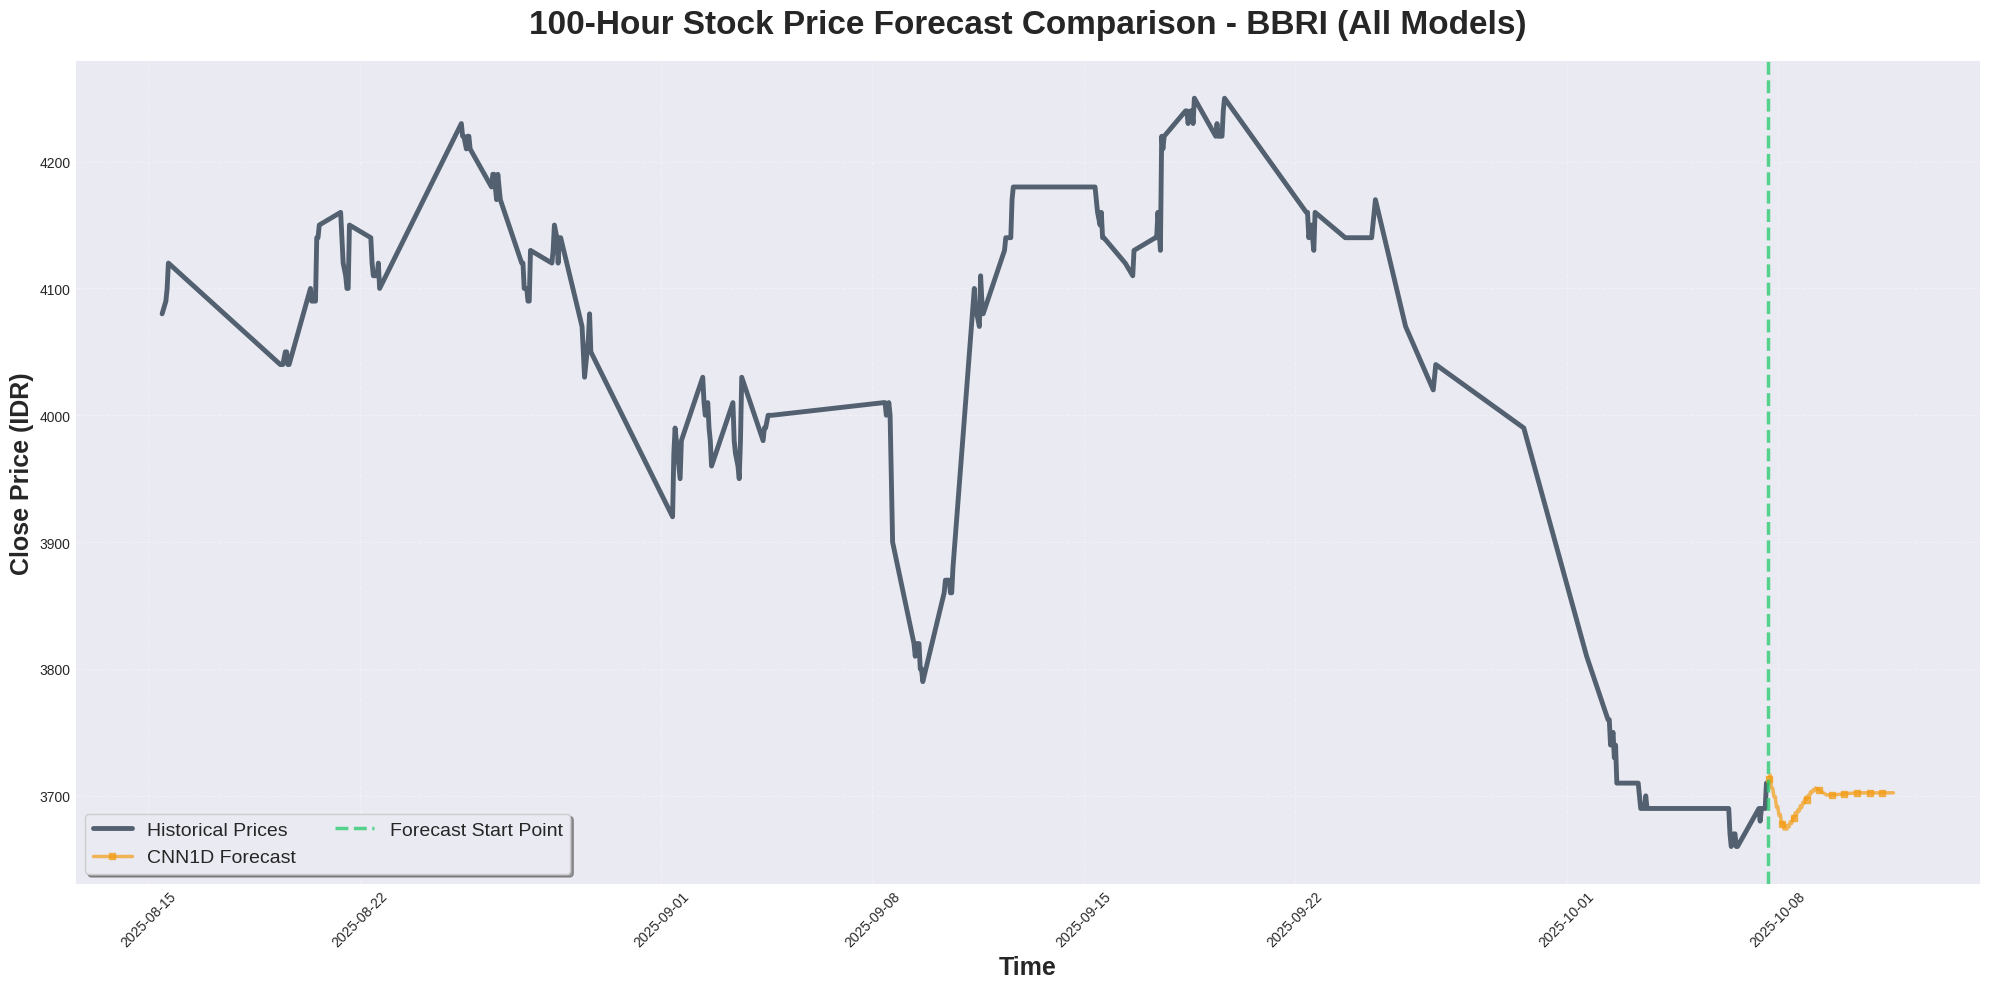

In [42]:
print("\n" + "="*100)
print("MULTI-STEP FORECASTING WITH CNN1D: 100 HOURS AHEAD")
print("="*100)

# Forecast for BBRI (Without Sentiment) - CNN1D
forecasts_cnn_BBRI = forecast_multistep(
    model_cnn_BBRI,
    last_window_scaled_BBRI,
    scaler_BBRI,
    target_col_BBRI,
    n_steps=100,
    n_features=X_train_BBRI.shape[2]
)

print(f"CNN1D 100-hour forecasts (BBRI) generated: {len(forecasts_cnn_BBRI)} values")
print(f"Forecast range: {forecasts_cnn_BBRI.min():.2f} - {forecasts_cnn_BBRI.max():.2f}")

# 100-Hour Forecast Visualization - All Models BBRI
plt.figure(figsize=(20, 10))
plt.title('100-Hour Stock Price Forecast Comparison - BBRI (All Models)', fontsize=24, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')

historical_data = df_BBRI['Close'].iloc[-200:]
plt.plot(historical_data.index, historical_data.values,
         label='Historical Prices', color='#2C3E50', linewidth=3.5, alpha=0.8)
plt.plot(forecast_datetimes_BBRI, forecasts_cnn_BBRI,
         label='CNN1D Forecast', color='#F39C12', linewidth=2.5, marker='s',
         markersize=4, alpha=0.7, markevery=10)
plt.axvline(x=last_datetime_BBRI, color='#2ECC71', linestyle='--', linewidth=2.5,
            label='Forecast Start Point', alpha=0.8)

plt.legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True, ncol=2)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


MULTI-STEP FORECASTING WITH ENSEMBLE: 24 HOURS AHEAD
Ensemble 24-hour forecasts (BBRI) generated: 100 values
Forecast range: 3717.09 - 3742.70


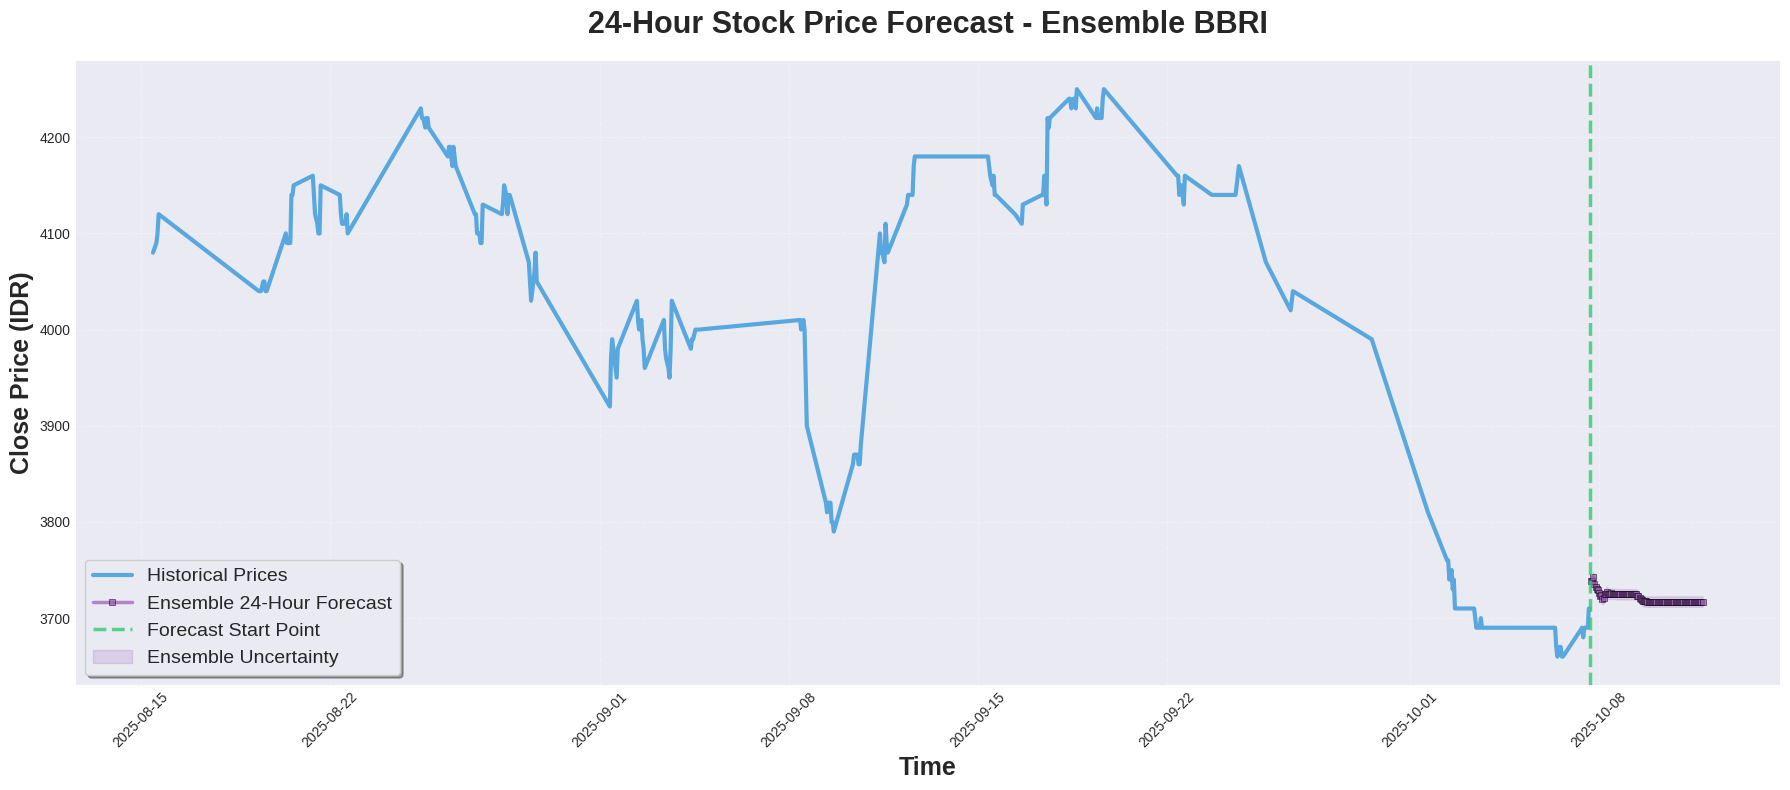

In [43]:
print("\n" + "="*100)
print("MULTI-STEP FORECASTING WITH ENSEMBLE: 24 HOURS AHEAD")
print("="*100)

# Forecast for BBRI (Without Sentiment)
forecasts_ensemble_BBRI = forecast_multistep(
    model_ensemble_BBRI,
    last_window_scaled_BBRI,
    scaler_BBRI,
    target_col_BBRI,
    n_steps=100,
    n_features=X_train_BBRI.shape[2]
)

print(f"Ensemble 24-hour forecasts (BBRI) generated: {len(forecasts_ensemble_BBRI)} values")
print(f"Forecast range: {forecasts_ensemble_BBRI.min():.2f} - {forecasts_ensemble_BBRI.max():.2f}")

# 24-Hour Forecast Visualization - Ensemble BBRI
plt.figure(figsize=(18, 8))
plt.title('24-Hour Stock Price Forecast - Ensemble BBRI', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')

historical_data = df_BBRI['Close'].iloc[-200:]
plt.plot(historical_data.index, historical_data.values,
         label='Historical Prices', color='#3498DB', linewidth=3, alpha=0.8)
plt.plot(forecast_datetimes_BBRI, forecasts_ensemble_BBRI,
         label='Ensemble 24-Hour Forecast', color='#9B59B6', linewidth=2.5, marker='s',
         markersize=5, alpha=0.7, markeredgecolor='black', markeredgewidth=0.5)
plt.axvline(x=last_datetime_BBRI, color='#2ECC71', linestyle='--', linewidth=2.5,
            label='Forecast Start Point', alpha=0.8)

forecast_std_ensemble = np.std(forecasts_ensemble_BBRI)
plt.fill_between(forecast_datetimes_BBRI,
                 forecasts_ensemble_BBRI - forecast_std_ensemble,
                 forecasts_ensemble_BBRI + forecast_std_ensemble,
                 alpha=0.2, color='#9B59B6', label='Ensemble Uncertainty')

plt.legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

24-hour forecasts generated: 100 values
Forecast range: 3694.18 - 3714.13


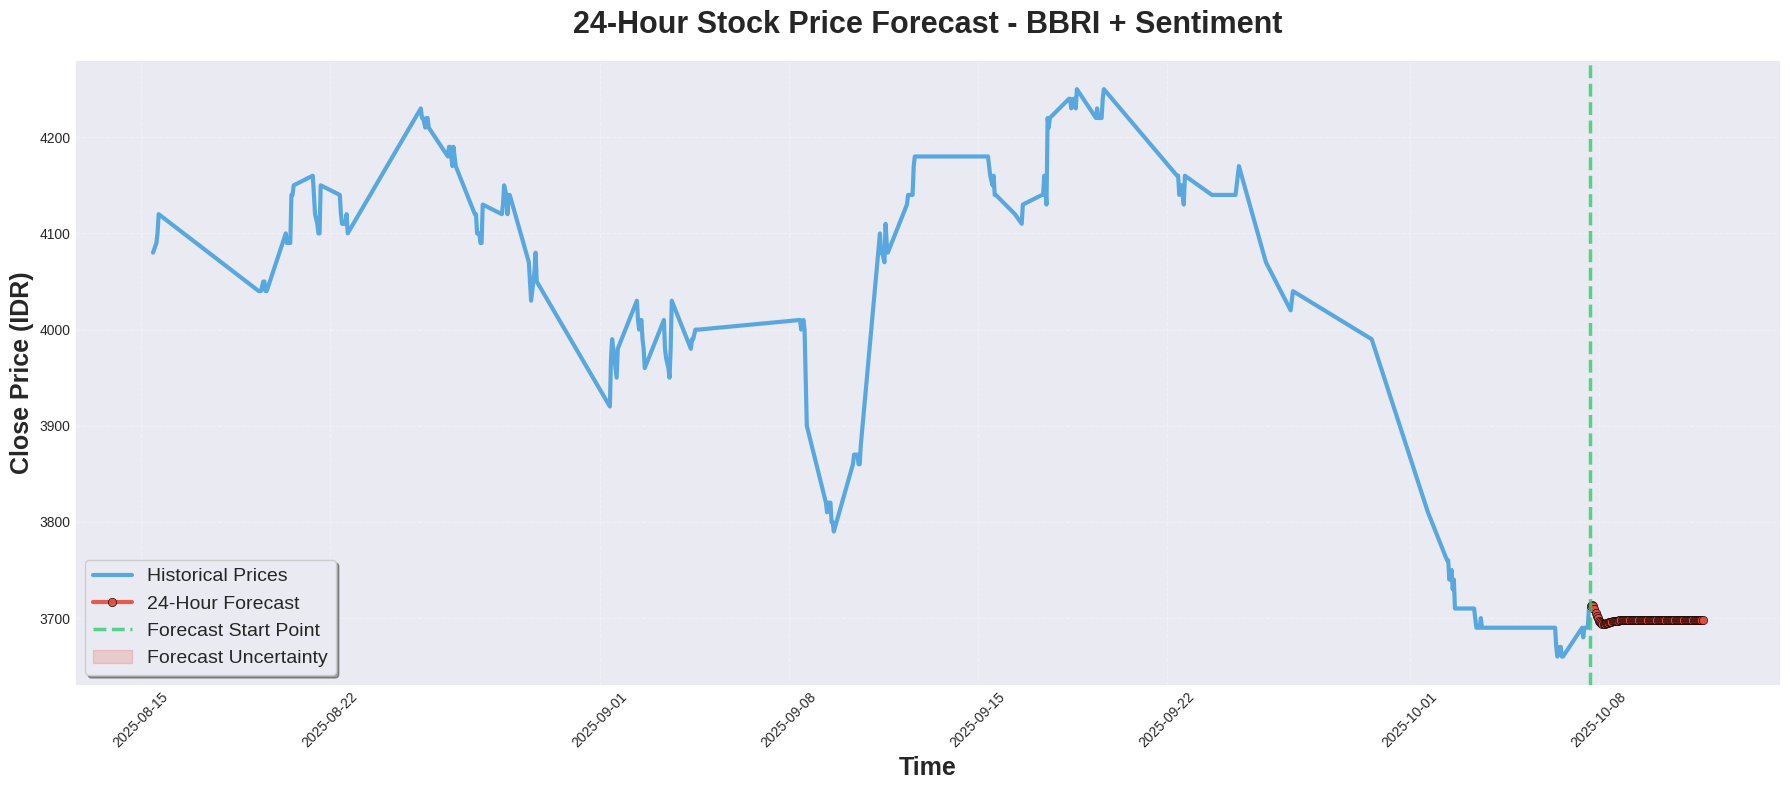

In [44]:
last_window_scaled_BBRI_Full = scaled_test_data_BBRI_Full[-window_size_Full:]
forecasts_BBRI_Full = forecast_multistep(
    model_lstm_BBRI_Full,
    last_window_scaled_BBRI_Full,
    scaler_BBRI_Full,
    target_col_BBRI_Full,
    n_steps=100,
    n_features=X_train_BBRI_Full.shape[2]
)

print(f"24-hour forecasts generated: {len(forecasts_BBRI_Full)} values")
print(f"Forecast range: {forecasts_BBRI_Full.min():.2f} - {forecasts_BBRI_Full.max():.2f}")

last_datetime_BBRI_Full = df_BBRI_Full.index[-1]
forecast_datetimes_BBRI_Full = [last_datetime_BBRI_Full + timedelta(hours=i+1) for i in range(len(forecasts_BBRI_Full))]


plt.figure(figsize=(18, 8))
plt.title('24-Hour Stock Price Forecast - BBRI + Sentiment', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')

historical_data_Full = df_BBRI_Full['Close'].iloc[-200:]
plt.plot(historical_data_Full.index, historical_data_Full.values,
         label='Historical Prices', color='#3498DB', linewidth=3, alpha=0.8)
plt.plot(forecast_datetimes_BBRI_Full, forecasts_BBRI_Full,
         label='24-Hour Forecast', color='#E74C3C', linewidth=3, marker='o',
         markersize=6, alpha=0.9, markeredgecolor='black', markeredgewidth=0.5)
plt.axvline(x=last_datetime_BBRI_Full, color='#2ECC71', linestyle='--', linewidth=2.5,
            label='Forecast Start Point', alpha=0.8)


forecast_std_Full = np.std(forecasts_BBRI_Full)
plt.fill_between(forecast_datetimes_BBRI_Full,
                 forecasts_BBRI_Full - forecast_std_Full,
                 forecasts_BBRI_Full + forecast_std_Full,
                 alpha=0.2, color='#E74C3C', label='Forecast Uncertainty')

plt.legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


CNN1D 100-hour forecasts (BBRI + Sentiment) generated: 100 values
Forecast range: 3705.46 - 3753.06


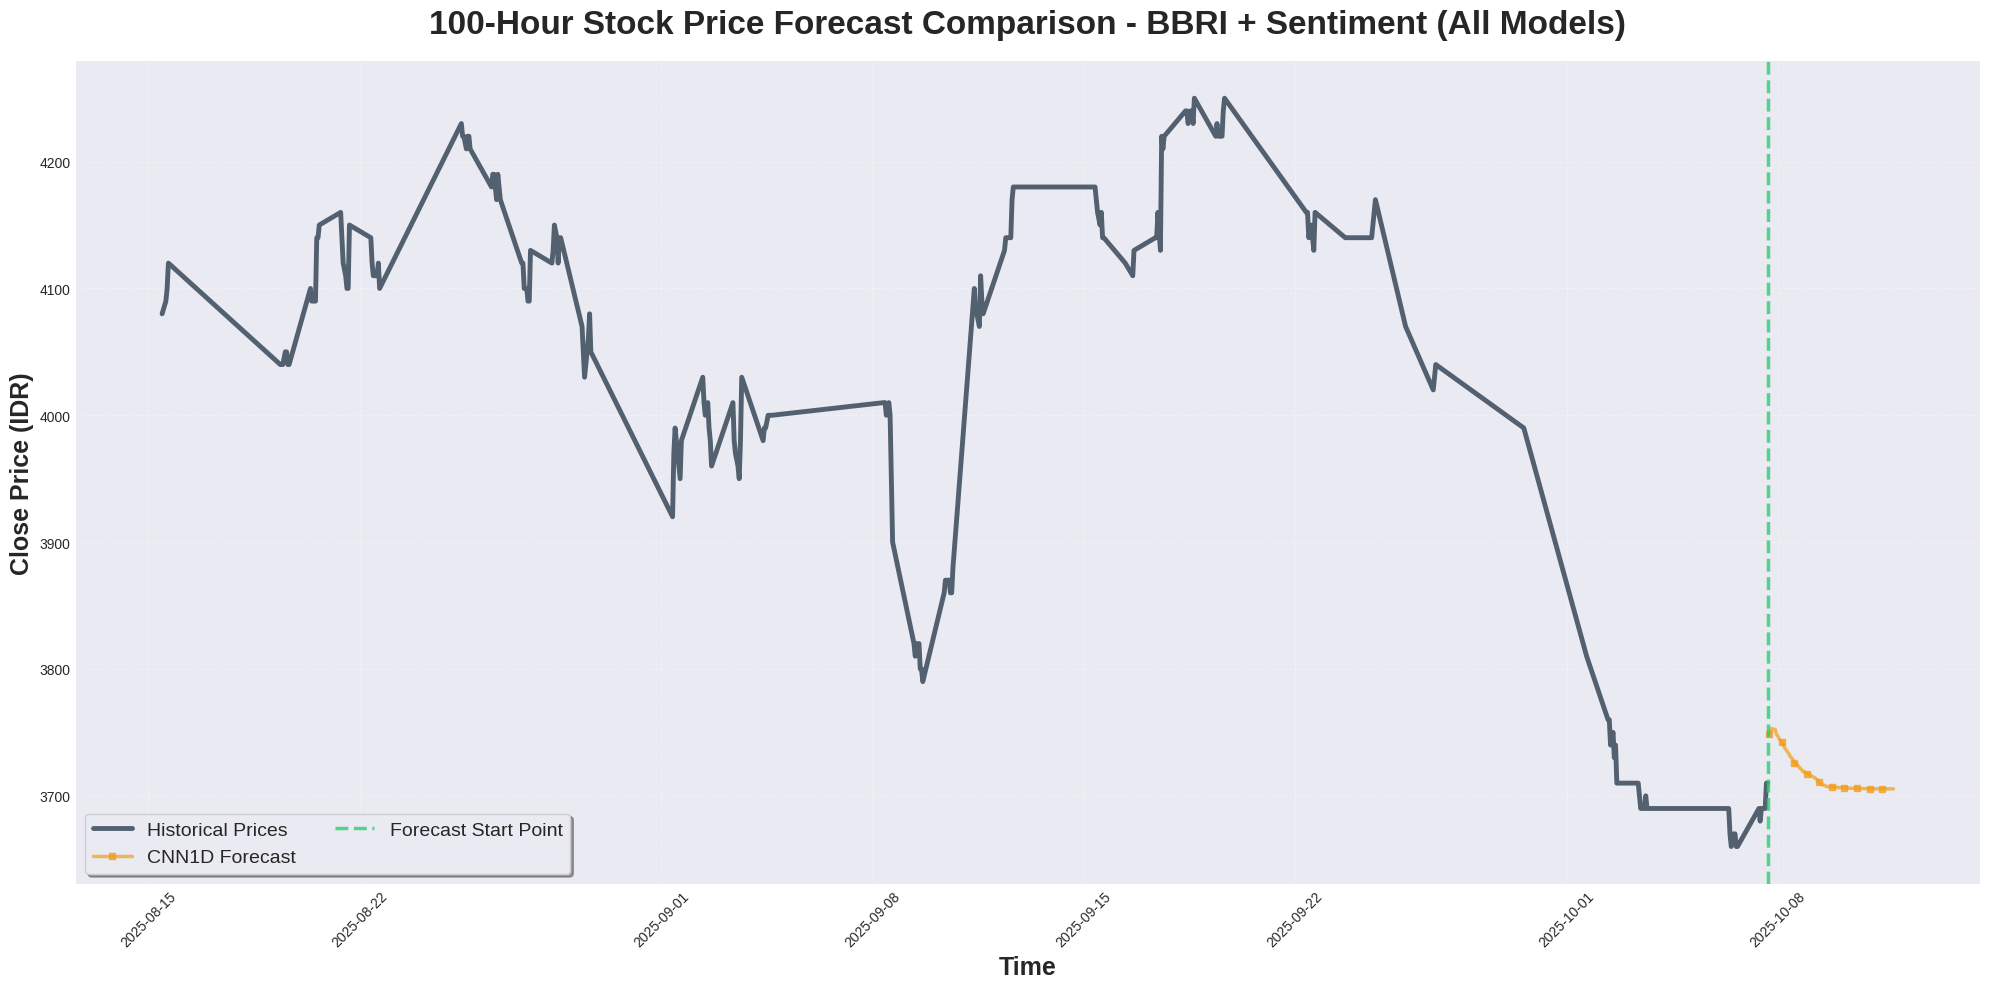

In [45]:
# Forecast for BBRI + Sentiment - CNN1D
forecasts_cnn_BBRI_Full = forecast_multistep(
    model_cnn_BBRI_Full,
    last_window_scaled_BBRI_Full,
    scaler_BBRI_Full,
    target_col_BBRI_Full,
    n_steps=100,
    n_features=X_train_BBRI_Full.shape[2]
)

print(f"\nCNN1D 100-hour forecasts (BBRI + Sentiment) generated: {len(forecasts_cnn_BBRI_Full)} values")
print(f"Forecast range: {forecasts_cnn_BBRI_Full.min():.2f} - {forecasts_cnn_BBRI_Full.max():.2f}")

# 100-Hour Forecast Visualization - All Models BBRI + Sentiment
plt.figure(figsize=(20, 10))
plt.title('100-Hour Stock Price Forecast Comparison - BBRI + Sentiment (All Models)', fontsize=24, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')

historical_data_Full = df_BBRI_Full['Close'].iloc[-200:]
plt.plot(historical_data_Full.index, historical_data_Full.values,
         label='Historical Prices', color='#2C3E50', linewidth=3.5, alpha=0.8)
plt.plot(forecast_datetimes_BBRI_Full, forecasts_cnn_BBRI_Full,
         label='CNN1D Forecast', color='#F39C12', linewidth=2.5, marker='s',
         markersize=4, alpha=0.7, markevery=10)
plt.axvline(x=last_datetime_BBRI_Full, color='#2ECC71', linestyle='--', linewidth=2.5,
            label='Forecast Start Point', alpha=0.8)

plt.legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True, ncol=2)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Ensemble 24-hour forecasts (BBRI + Sentiment) generated: 100 values
Forecast range: 3685.36 - 3739.82


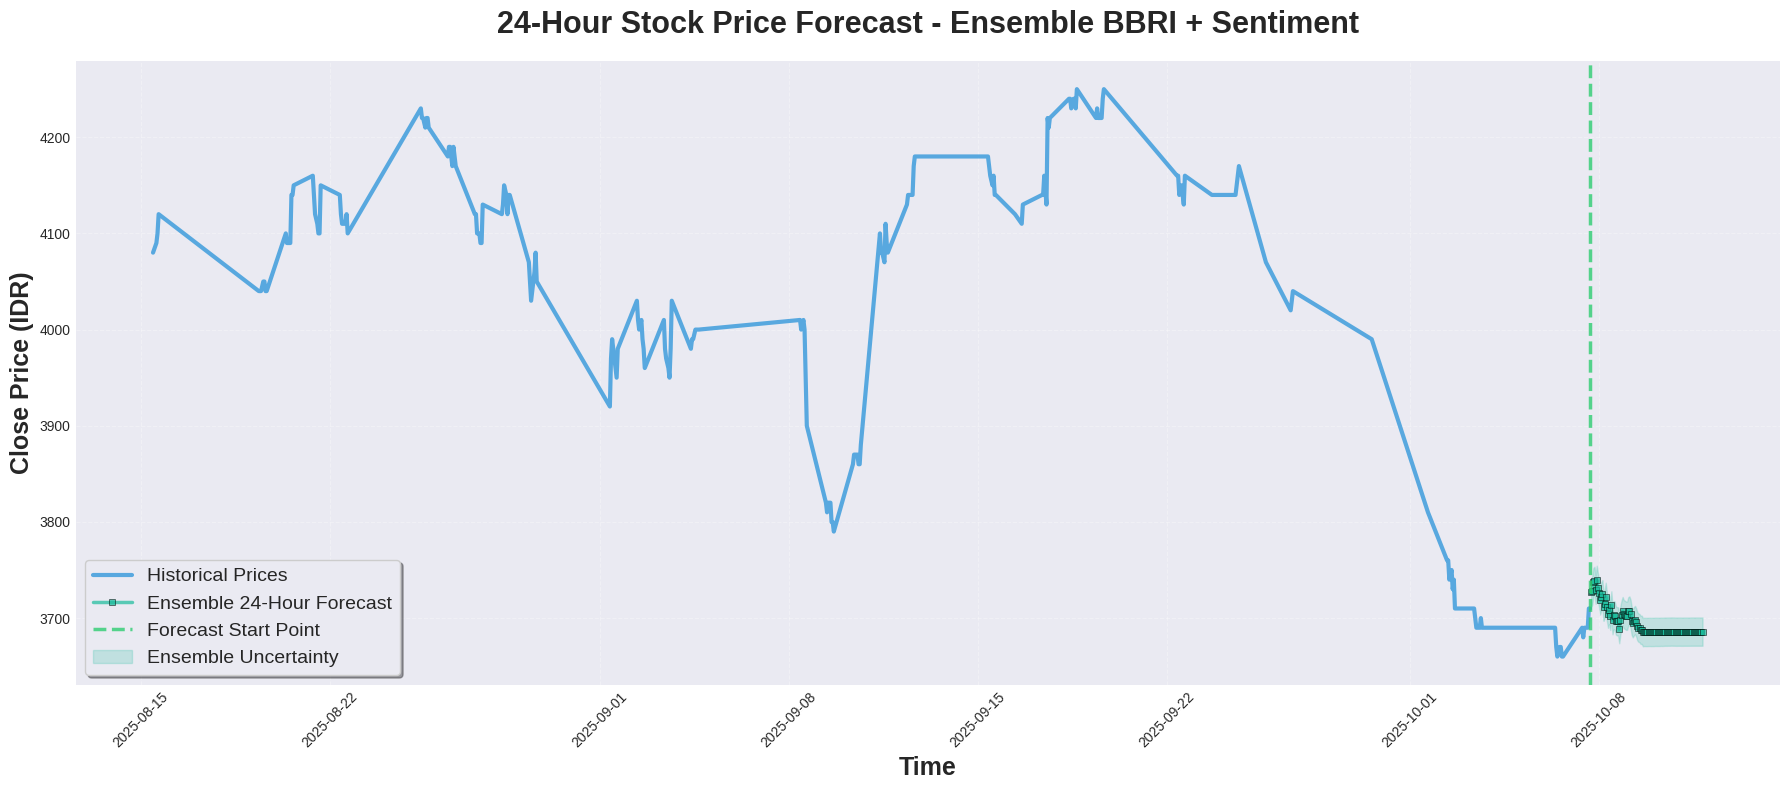

In [46]:
# Forecast for BBRI + Sentiment
forecasts_ensemble_BBRI_Full = forecast_multistep(
    model_ensemble_BBRI_Full,
    last_window_scaled_BBRI_Full,
    scaler_BBRI_Full,
    target_col_BBRI_Full,
    n_steps=100,
    n_features=X_train_BBRI_Full.shape[2]
)

print(f"\nEnsemble 24-hour forecasts (BBRI + Sentiment) generated: {len(forecasts_ensemble_BBRI_Full)} values")
print(f"Forecast range: {forecasts_ensemble_BBRI_Full.min():.2f} - {forecasts_ensemble_BBRI_Full.max():.2f}")

# 24-Hour Forecast Visualization - Ensemble BBRI + Sentiment
plt.figure(figsize=(18, 8))
plt.title('24-Hour Stock Price Forecast - Ensemble BBRI + Sentiment', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=18, fontweight='bold')
plt.ylabel('Close Price (IDR)', fontsize=18, fontweight='bold')

historical_data_Full = df_BBRI_Full['Close'].iloc[-200:]
plt.plot(historical_data_Full.index, historical_data_Full.values,
         label='Historical Prices', color='#3498DB', linewidth=3, alpha=0.8)
plt.plot(forecast_datetimes_BBRI_Full, forecasts_ensemble_BBRI_Full,
         label='Ensemble 24-Hour Forecast', color='#1ABC9C', linewidth=2.5, marker='s',
         markersize=5, alpha=0.7, markeredgecolor='black', markeredgewidth=0.5)
plt.axvline(x=last_datetime_BBRI_Full, color='#2ECC71', linestyle='--', linewidth=2.5,
            label='Forecast Start Point', alpha=0.8)

forecast_std_ensemble_Full = np.std(forecasts_ensemble_BBRI_Full)
plt.fill_between(forecast_datetimes_BBRI_Full,
                 forecasts_ensemble_BBRI_Full - forecast_std_ensemble_Full,
                 forecasts_ensemble_BBRI_Full + forecast_std_ensemble_Full,
                 alpha=0.2, color='#1ABC9C', label='Ensemble Uncertainty')

plt.legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
print("\n" + "="*100)
print("SAVING RESULTS")
print("="*100)

actual_vs_predicted_BBRI = pd.DataFrame({
    'Open': df_BBRI['Open'][train_size_BBRI + window_size_B:],
    'High': df_BBRI['High'][train_size_BBRI + window_size_B:],
    'Low': df_BBRI['Low'][train_size_BBRI + window_size_B:],
    'Close': y_test_actual,
    'Volume': df_BBRI['Volume'][train_size_BBRI + window_size_B:],
    'EMA_12': df_BBRI['EMA_12'][train_size_BBRI + window_size_B:],
    'EMA_26': df_BBRI['EMA_26'][train_size_BBRI + window_size_B:],
    'RSI_14': df_BBRI['RSI_14'][train_size_BBRI + window_size_B:],
    'Close_Predicted': predictions
})

print("\nBBRI LSTM Tuned Results Preview:")
print(actual_vs_predicted_BBRI.head())
actual_vs_predicted_BBRI.to_csv('actual_vs_predicted_lstm_tuned_BBRI.csv')
print("✓ BBRI results LSTM Tuned saved successfully")

actual_vs_predicted_BBRI_Full = pd.DataFrame({
    'Open': df_BBRI_Full['Open'][train_size_BBRI_Full + window_size_Full:],
    'High': df_BBRI_Full['High'][train_size_BBRI_Full + window_size_Full:],
    'Low': df_BBRI_Full['Low'][train_size_BBRI_Full + window_size_Full:],
    'Close': y_test_actual_Full,
    'Volume': df_BBRI_Full['Volume'][train_size_BBRI_Full + window_size_Full:],
    'EMA_12': df_BBRI_Full['EMA_12'][train_size_BBRI_Full + window_size_Full:],
    'EMA_26': df_BBRI_Full['EMA_26'][train_size_BBRI_Full + window_size_Full:],
    'RSI_14': df_BBRI_Full['RSI_14'][train_size_BBRI_Full + window_size_Full:],
    'average_score': df_BBRI_Full['average_score'][train_size_BBRI_Full + window_size_Full:],
    'Sentiment_value': df_BBRI_Full['Sentiment_value'][train_size_BBRI_Full + window_size_Full:],
    'ABS_Average_Score': df_BBRI_Full['ABS_Average_Score'][train_size_BBRI_Full + window_size_Full:],
    'Close_Predicted': predictions_Full
})

print("\nBBRI + Sentiment LSTM Tuned Results Preview:")
print(actual_vs_predicted_BBRI_Full.head())
actual_vs_predicted_BBRI_Full.to_csv('actual_vs_predicted__lstm_tuned_BBRI_Sentiment.csv')
print("✓ BBRI + Sentiment LSTM Tuned results saved successfully")


SAVING RESULTS

BBRI LSTM Tuned Results Preview:
                             Open    High     Low   Close    Volume  \
Datetime                                                              
2025-05-21 14:00:00+07:00  4260.0  4310.0  4250.0  4260.0  88598700   
2025-05-21 15:00:00+07:00  4260.0  4270.0  4250.0  4250.0  43763500   
2025-05-21 16:00:00+07:00  4260.0  4260.0  4260.0  4260.0  24270100   
2025-05-22 09:00:00+07:00  4280.0  4300.0  4240.0  4270.0         0   
2025-05-22 10:00:00+07:00  4270.0  4310.0  4270.0  4290.0  50700300   

                                EMA_12       EMA_26     RSI_14  \
Datetime                                                         
2025-05-21 14:00:00+07:00  4247.396766  4217.493944  61.178859   
2025-05-21 15:00:00+07:00  4247.797264  4219.901800  58.308294   
2025-05-21 16:00:00+07:00  4249.674608  4222.872037  60.313652   
2025-05-22 09:00:00+07:00  4252.801591  4226.362997  62.268149   
2025-05-22 10:00:00+07:00  4258.524423  4231.076849  65.

In [48]:
print("\n" + "="*100)
print("SAVING CNN1D RESULTS")
print("="*100)

# Save BBRI CNN1D Results
actual_vs_predicted_cnn_BBRI = pd.DataFrame({
    'Open': df_BBRI['Open'][train_size_BBRI + window_size_B:],
    'High': df_BBRI['High'][train_size_BBRI + window_size_B:],
    'Low': df_BBRI['Low'][train_size_BBRI + window_size_B:],
    'Close': y_test_actual,
    'Volume': df_BBRI['Volume'][train_size_BBRI + window_size_B:],
    'EMA_12': df_BBRI['EMA_12'][train_size_BBRI + window_size_B:],
    'EMA_26': df_BBRI['EMA_26'][train_size_BBRI + window_size_B:],
    'RSI_14': df_BBRI['RSI_14'][train_size_BBRI + window_size_B:],
    'Close_CNN1D': predictions_cnn
})

print("\nBBRI CNN1D Results Preview:")
print(actual_vs_predicted_cnn_BBRI.head())
actual_vs_predicted_cnn_BBRI.to_csv('actual_vs_predicted_cnn1D_tuned_BBRI.csv')
print("✓ BBRI CNN1D Tuned results saved successfully")

# Save BBRI + Sentiment CNN1D Results
actual_vs_predicted_cnn_BBRI_Full = pd.DataFrame({
    'Open': df_BBRI_Full['Open'][train_size_BBRI_Full + window_size_Full:],
    'High': df_BBRI_Full['High'][train_size_BBRI_Full + window_size_Full:],
    'Low': df_BBRI_Full['Low'][train_size_BBRI_Full + window_size_Full:],
    'Close': y_test_actual_Full,
    'Volume': df_BBRI_Full['Volume'][train_size_BBRI_Full + window_size_Full:],
    'EMA_12': df_BBRI_Full['EMA_12'][train_size_BBRI_Full + window_size_Full:],
    'EMA_26': df_BBRI_Full['EMA_26'][train_size_BBRI_Full + window_size_Full:],
    'RSI_14': df_BBRI_Full['RSI_14'][train_size_BBRI_Full + window_size_Full:],
    'average_score': df_BBRI_Full['average_score'][train_size_BBRI_Full + window_size_Full:],
    'Sentiment_value': df_BBRI_Full['Sentiment_value'][train_size_BBRI_Full + window_size_Full:],
    'ABS_Average_Score': df_BBRI_Full['ABS_Average_Score'][train_size_BBRI_Full + window_size_Full:],
    'Close_CNN1D': predictions_cnn_Full
})

print("\nBBRI + Sentiment CNN1D Tuned Results Preview:")
print(actual_vs_predicted_cnn_BBRI_Full.head())
actual_vs_predicted_cnn_BBRI_Full.to_csv('actual_vs_predicted_cnn1D_tuned_BBRI_Sentiment.csv')
print("✓ BBRI + Sentiment CNN1D Tuned results saved successfully")


SAVING CNN1D RESULTS

BBRI CNN1D Results Preview:
                             Open    High     Low   Close    Volume  \
Datetime                                                              
2025-05-21 14:00:00+07:00  4260.0  4310.0  4250.0  4260.0  88598700   
2025-05-21 15:00:00+07:00  4260.0  4270.0  4250.0  4250.0  43763500   
2025-05-21 16:00:00+07:00  4260.0  4260.0  4260.0  4260.0  24270100   
2025-05-22 09:00:00+07:00  4280.0  4300.0  4240.0  4270.0         0   
2025-05-22 10:00:00+07:00  4270.0  4310.0  4270.0  4290.0  50700300   

                                EMA_12       EMA_26     RSI_14  Close_CNN1D  
Datetime                                                                     
2025-05-21 14:00:00+07:00  4247.396766  4217.493944  61.178859  4166.188307  
2025-05-21 15:00:00+07:00  4247.797264  4219.901800  58.308294  4158.569651  
2025-05-21 16:00:00+07:00  4249.674608  4222.872037  60.313652  4153.243151  
2025-05-22 09:00:00+07:00  4252.801591  4226.362997  62.26814

In [49]:
print("\n" + "="*100)
print("SAVING ENSEMBLE RESULTS")
print("="*100)

# Save BBRI Ensemble Results
actual_vs_predicted_ensemble_BBRI = pd.DataFrame({
    'Open': df_BBRI['Open'][train_size_BBRI + window_size_B:],
    'High': df_BBRI['High'][train_size_BBRI + window_size_B:],
    'Low': df_BBRI['Low'][train_size_BBRI + window_size_B:],
    'Close': y_test_actual,
    'Volume': df_BBRI['Volume'][train_size_BBRI + window_size_B:],
    'EMA_12': df_BBRI['EMA_12'][train_size_BBRI + window_size_B:],
    'EMA_26': df_BBRI['EMA_26'][train_size_BBRI + window_size_B:],
    'RSI_14': df_BBRI['RSI_14'][train_size_BBRI + window_size_B:],
    'Close_Ensemble': predictions_ensemble
})

print("\nBBRI Ensemble Results Preview:")
print(actual_vs_predicted_ensemble_BBRI.head())
actual_vs_predicted_ensemble_BBRI.to_csv('actual_vs_predicted_ensemble_tuned_BBRI.csv')
print("✓ BBRI Ensemble results saved successfully")

#Save BBRI + Sentiment Ensemble Results
actual_vs_predicted_ensemble_BBRI_Full = pd.DataFrame({
    'Open': df_BBRI_Full['Open'][train_size_BBRI_Full + window_size_Full:],
    'High': df_BBRI_Full['High'][train_size_BBRI_Full + window_size_Full:],
    'Low': df_BBRI_Full['Low'][train_size_BBRI_Full + window_size_Full:],
    'Close': y_test_actual_Full,
    'Volume': df_BBRI_Full['Volume'][train_size_BBRI_Full + window_size_Full:],
    'EMA_12': df_BBRI_Full['EMA_12'][train_size_BBRI_Full + window_size_Full:],
    'EMA_26': df_BBRI_Full['EMA_26'][train_size_BBRI_Full + window_size_Full:],
    'RSI_14': df_BBRI_Full['RSI_14'][train_size_BBRI_Full + window_size_Full:],
    'average_score': df_BBRI_Full['average_score'][train_size_BBRI_Full + window_size_Full:],
    'Sentiment_value': df_BBRI_Full['Sentiment_value'][train_size_BBRI_Full + window_size_Full:],
    'ABS_Average_Score': df_BBRI_Full['ABS_Average_Score'][train_size_BBRI_Full + window_size_Full:],
    'Close_Ensemble': predictions_ensemble_Full
})

print("\nBBRI + Sentiment Ensemble Results Preview:")
print(actual_vs_predicted_ensemble_BBRI_Full.head())
actual_vs_predicted_ensemble_BBRI_Full.to_csv('actual_vs_predicted_ensemble_tuned_BBRI_Sentiment.csv')
print("✓ BBRI + Sentiment Ensemble results saved successfully")


SAVING ENSEMBLE RESULTS

BBRI Ensemble Results Preview:
                             Open    High     Low   Close    Volume  \
Datetime                                                              
2025-05-21 14:00:00+07:00  4260.0  4310.0  4250.0  4260.0  88598700   
2025-05-21 15:00:00+07:00  4260.0  4270.0  4250.0  4250.0  43763500   
2025-05-21 16:00:00+07:00  4260.0  4260.0  4260.0  4260.0  24270100   
2025-05-22 09:00:00+07:00  4280.0  4300.0  4240.0  4270.0         0   
2025-05-22 10:00:00+07:00  4270.0  4310.0  4270.0  4290.0  50700300   

                                EMA_12       EMA_26     RSI_14  Close_Ensemble  
Datetime                                                                        
2025-05-21 14:00:00+07:00  4247.396766  4217.493944  61.178859     4253.760724  
2025-05-21 15:00:00+07:00  4247.797264  4219.901800  58.308294     4239.677644  
2025-05-21 16:00:00+07:00  4249.674608  4222.872037  60.313652     4257.860513  
2025-05-22 09:00:00+07:00  4252.801591  

In [50]:
print("\n" + "="*100)
print("COMPREHENSIVE FINAL SUMMARY - ALL MODELS (LSTM, CNN1D, ENSEMBLE)")
print("="*100)

comprehensive_summary_all = {
    'Model': [
        'LSTM (No Sentiment)',
        'LSTM (With Sentiment)',
        'CNN1D (No Sentiment)',
        'CNN1D (With Sentiment)',
        'Ensemble (No Sentiment)',
        'Ensemble (With Sentiment)'
    ],
    'RMSE': [
        rmse_BBRI,
        rmse_BBRI_Full,
        rmse_cnn_BBRI,
        rmse_cnn_BBRI_Full,
        rmse_ensemble_BBRI,
        rmse_ensemble_BBRI_Full
    ],
    'MAE': [
        mae_BBRI,
        mae_BBRI_Full,
        mae_cnn_BBRI,
        mae_cnn_BBRI_Full,
        mae_ensemble_BBRI,
        mae_ensemble_BBRI_Full
    ],
    'MAPE': [
        mape_BBRI,
        mape_BBRI_Full,
        mape_cnn_BBRI,
        mape_cnn_BBRI_Full,
        mape_ensemble_BBRI,
        mape_ensemble_BBRI_Full
    ],
    'R² Score': [
        r2_BBRI,
        r2_BBRI_Full,
        r2_cnn_BBRI,
        r2_cnn_BBRI_Full,
        r2_ensemble_BBRI,
        r2_ensemble_BBRI_Full
    ]
}

comprehensive_df_all = pd.DataFrame(comprehensive_summary_all)
print("\n" + comprehensive_df_all.to_string(index=False))


COMPREHENSIVE FINAL SUMMARY - ALL MODELS (LSTM, CNN1D, ENSEMBLE)

                    Model      RMSE       MAE     MAPE  R² Score
      LSTM (No Sentiment) 33.704299 22.537473 0.005706  0.969935
    LSTM (With Sentiment) 33.875640 22.778607 0.005766  0.969628
     CNN1D (No Sentiment) 63.682450 50.182739 0.012549  0.892667
   CNN1D (With Sentiment) 50.076563 36.315044 0.009192  0.933631
  Ensemble (No Sentiment) 37.574099 27.334192 0.006930  0.962634
Ensemble (With Sentiment) 39.177234 27.990451 0.007077  0.959378



COMPREHENSIVE MODEL COMPARISON VISUALIZATION


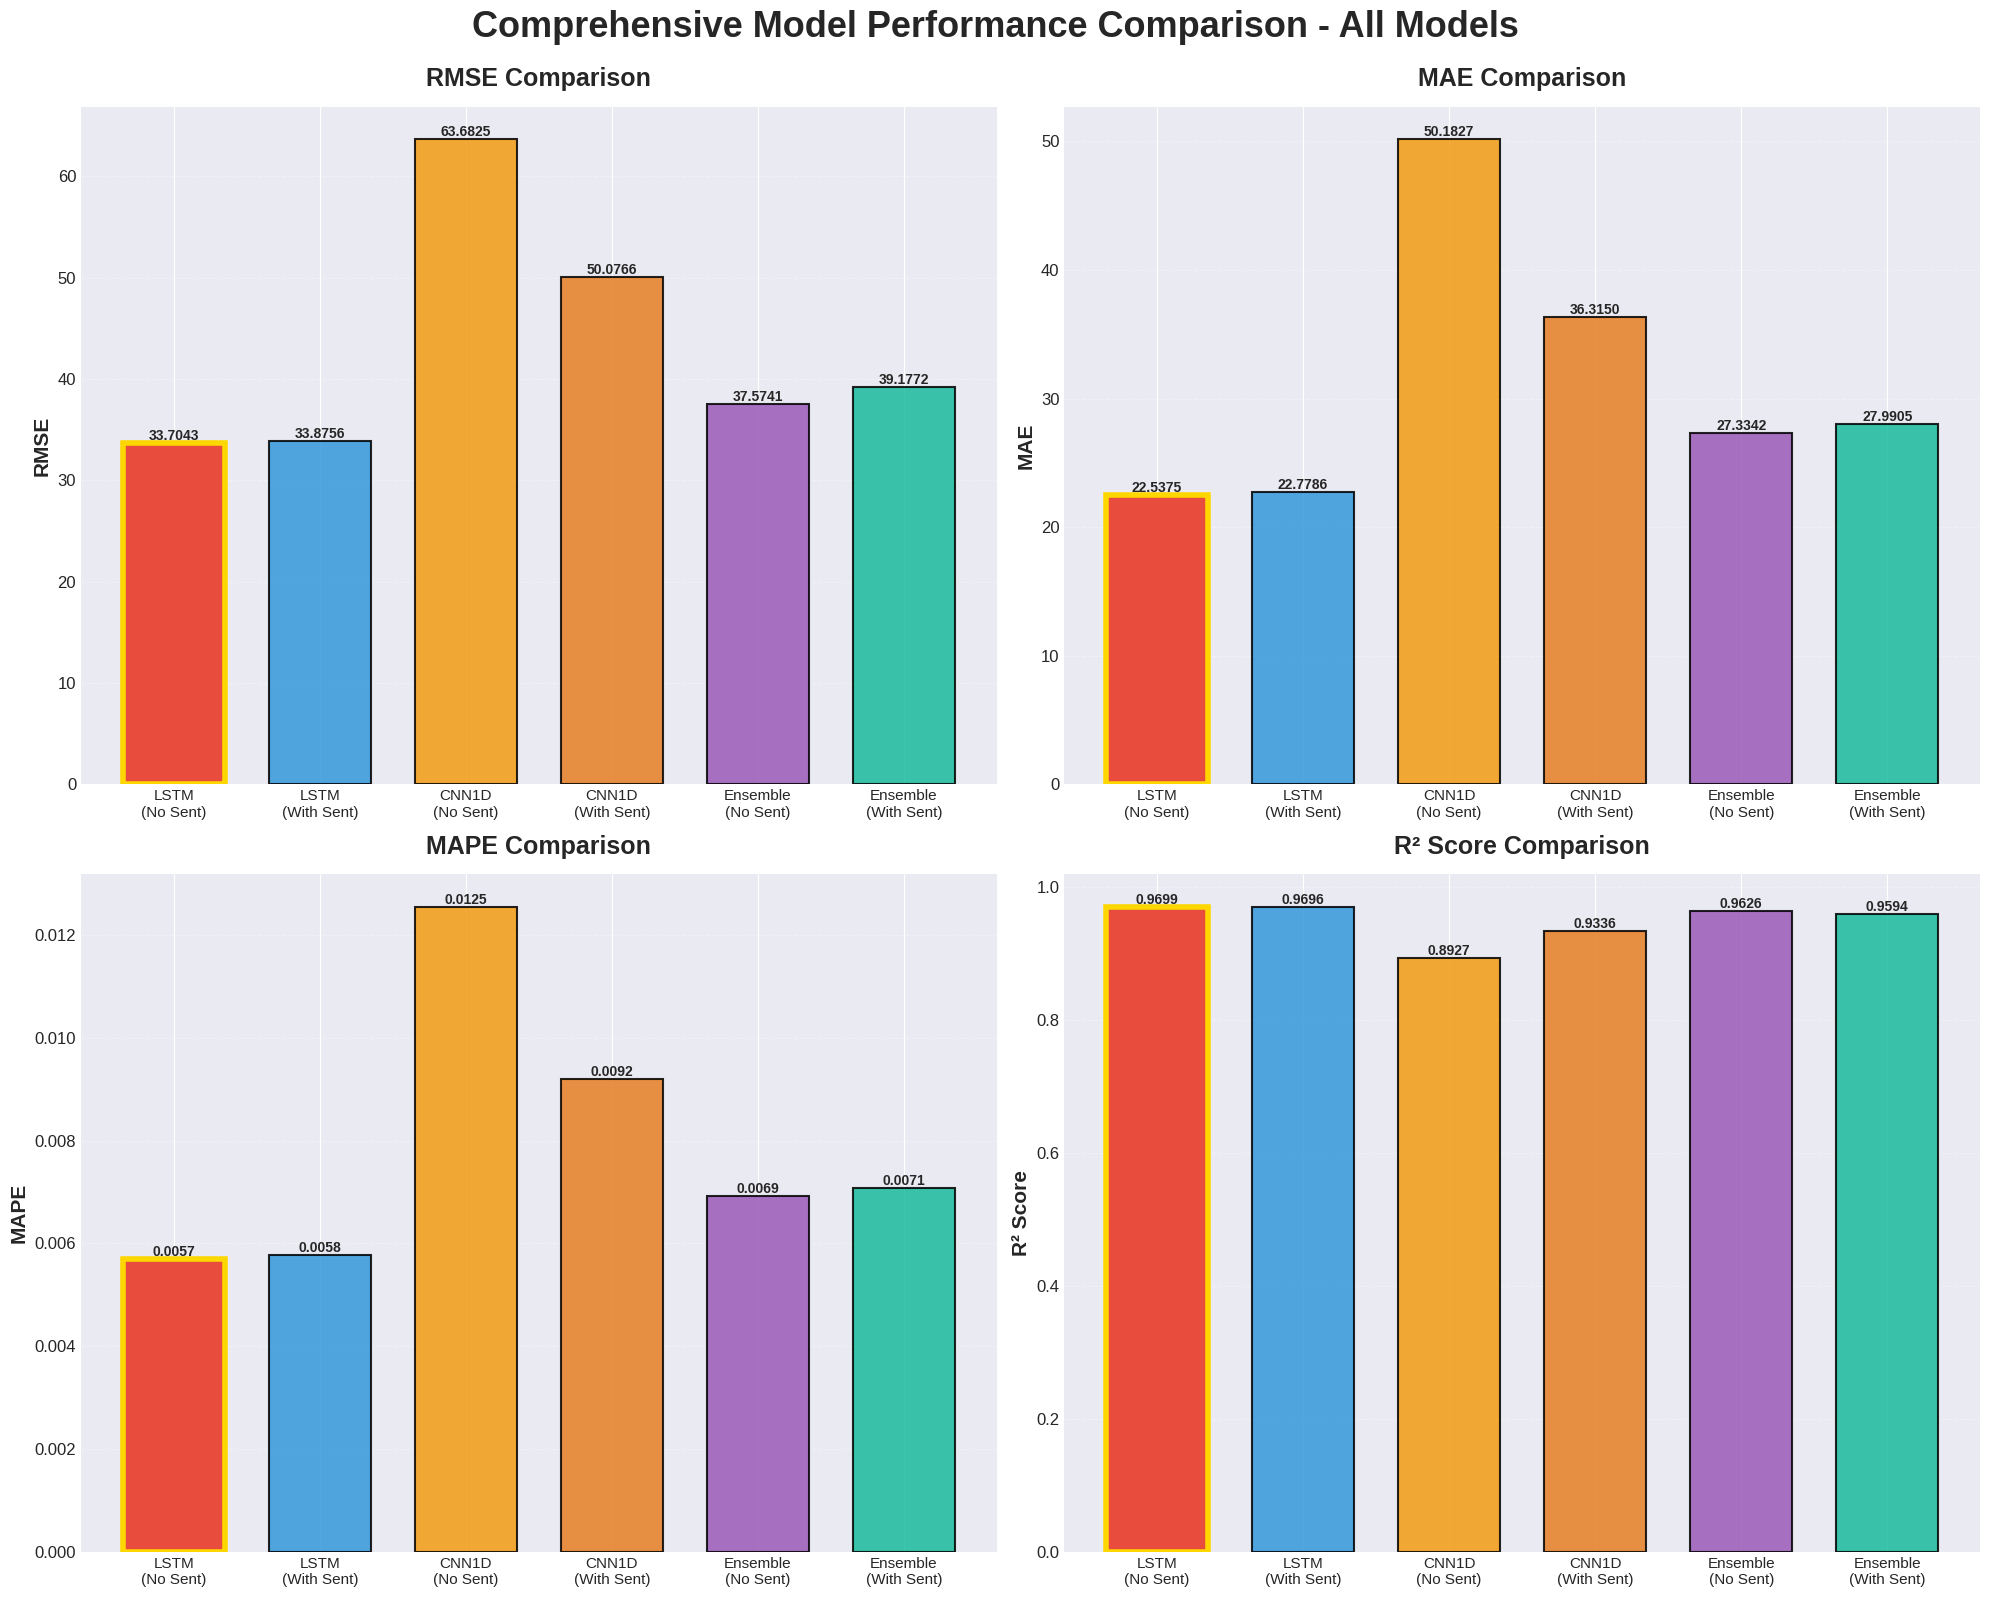

In [51]:
print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON VISUALIZATION")
print("="*100)

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Comprehensive Model Performance Comparison - All Models', fontsize=26, fontweight='bold', y=0.995)

metrics = ['RMSE', 'MAE', 'MAPE', 'R² Score']
colors_all = ['#E74C3C', '#3498DB', '#F39C12', '#E67E22', '#9B59B6', '#1ABC9C']
model_labels_all = ['LSTM\n(No Sent)', 'LSTM\n(With Sent)',
                    'CNN1D\n(No Sent)', 'CNN1D\n(With Sent)',
                    'Ensemble\n(No Sent)', 'Ensemble\n(With Sent)']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
    bars = ax.bar(model_labels_all, comprehensive_summary_all[metric], color=colors_all,
                   edgecolor='black', linewidth=1.5, alpha=0.85, width=0.7)
    ax.set_title(f'{metric} Comparison', fontsize=18, fontweight='bold', pad=15)
    ax.set_ylabel(metric, fontsize=15, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=12)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Highlight best performer
    best_idx = comprehensive_summary_all[metric].index(max(comprehensive_summary_all[metric])) if metric == 'R² Score' else comprehensive_summary_all[metric].index(min(comprehensive_summary_all[metric]))
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(4)
    bars[best_idx].set_alpha(1.0)

plt.tight_layout()
plt.show()


FORECASTING RESULTS COMPARISON - ALL MODELS

Forecast Statistics - All Models:
             Hour  LSTM_NoSent  LSTM_WithSent  CNN1D_NoSent  CNN1D_WithSent  \
count  100.000000   100.000000     100.000000    100.000000      100.000000   
mean    50.500000  3701.020358    3698.003296   3698.129702     3715.931176   
std     29.011492     2.650516       3.198304      8.748431       14.678185   
min      1.000000  3696.679765    3694.183172   3673.576937     3705.456187   
25%     25.750000  3700.846574    3697.551486   3698.941967     3705.699309   
50%     50.500000  3700.847050    3697.552302   3701.917149     3706.985533   
75%     75.250000  3700.851942    3697.559029   3702.324545     3721.758338   
max    100.000000  3714.311905    3714.132134   3716.345809     3753.057997   

       Ensemble_NoSent  Ensemble_WithSent  
count       100.000000         100.000000  
mean       3721.185352        3696.006108  
std           5.387475          14.781783  
min        3717.094474        36

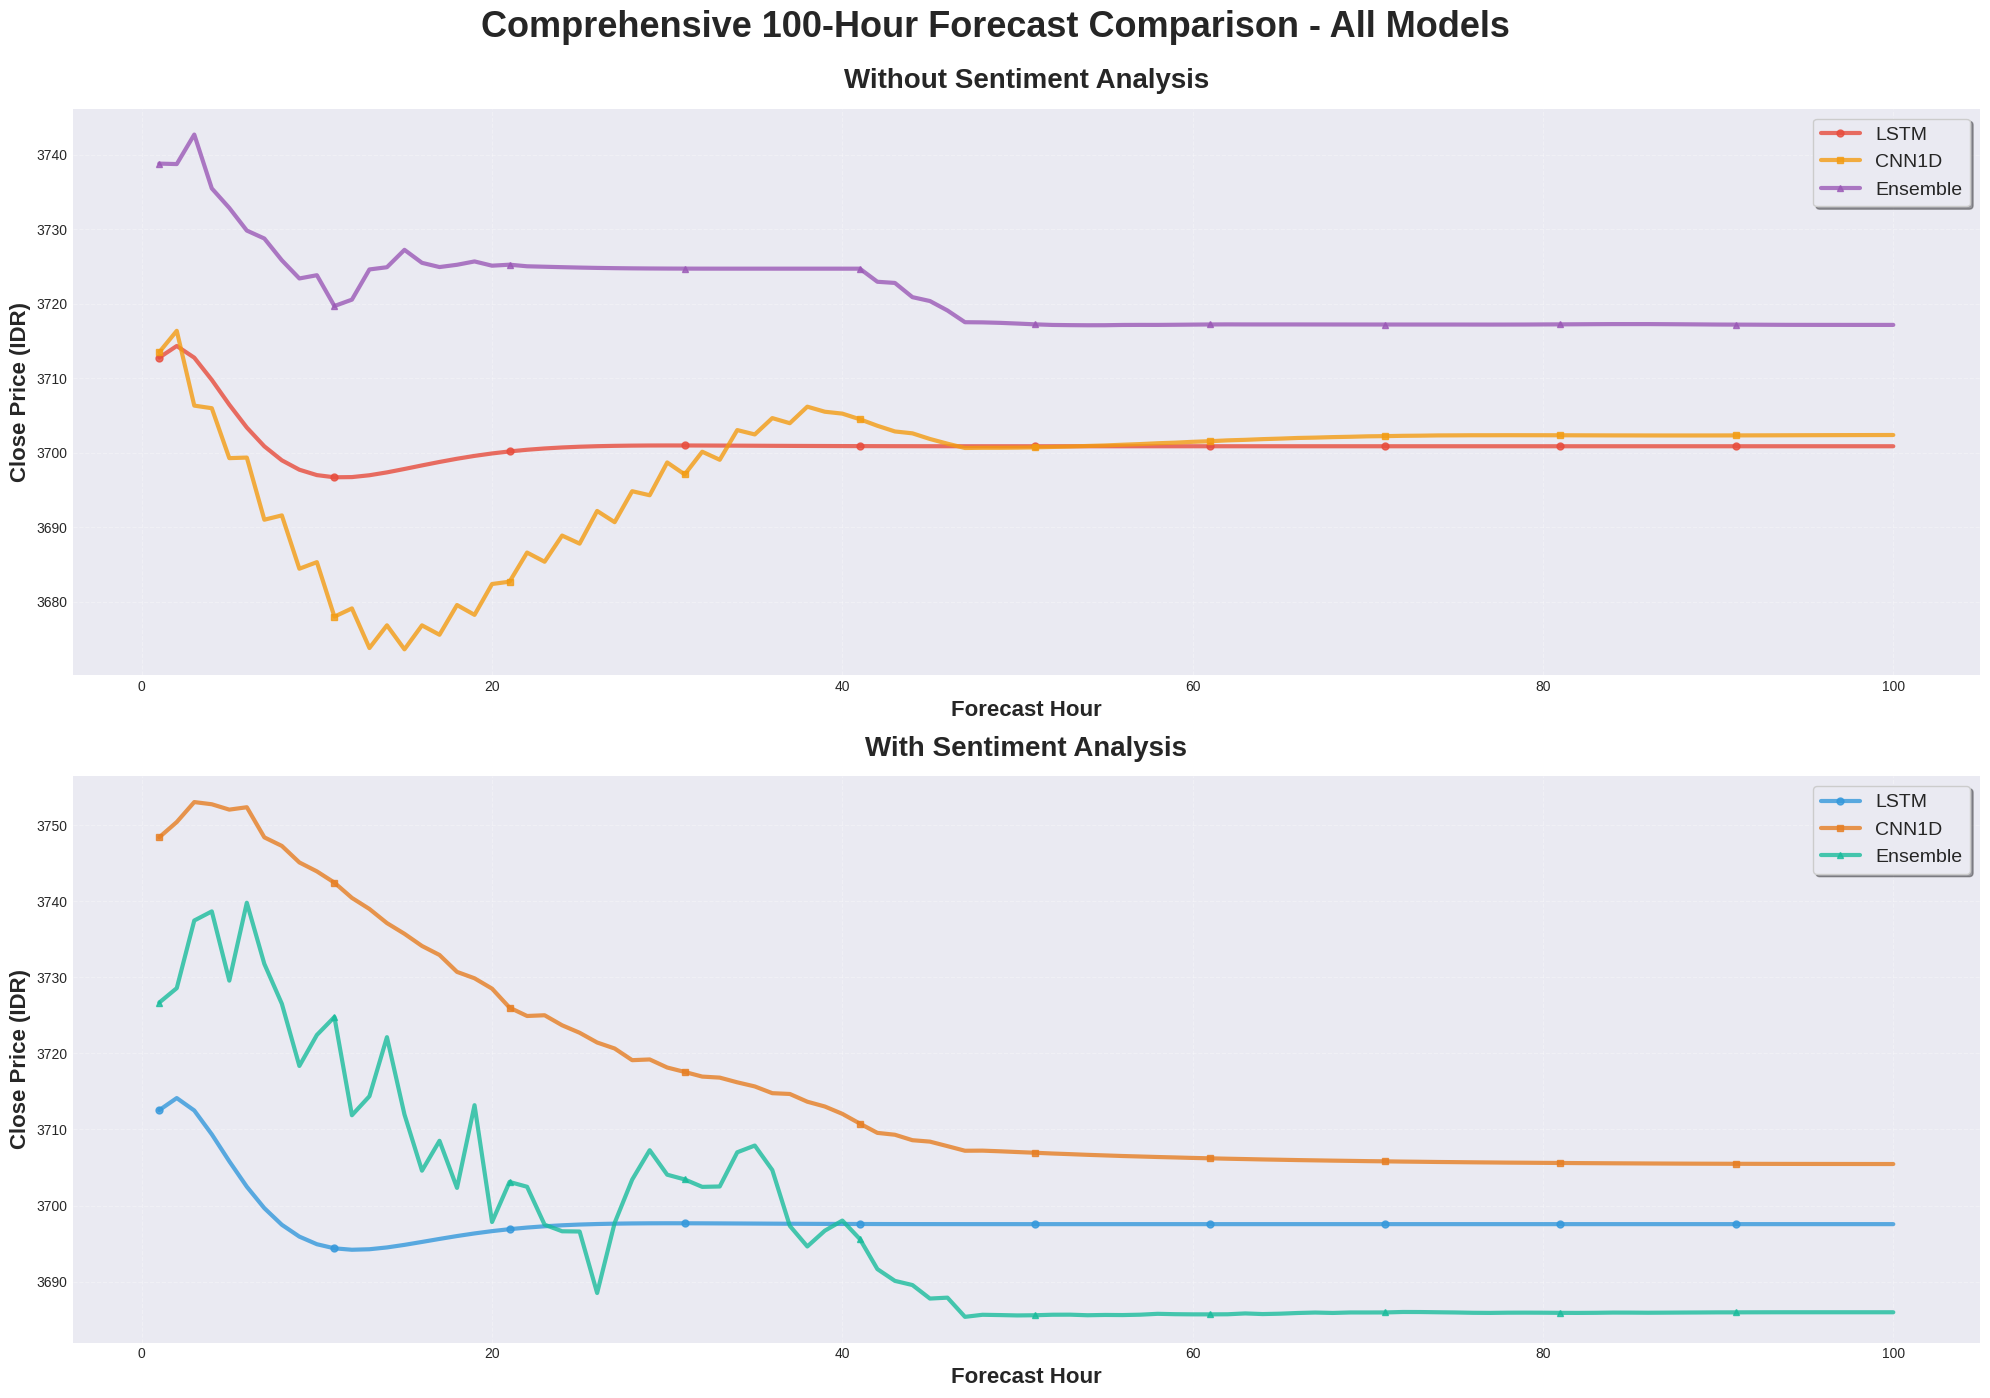

In [52]:
print("\n" + "="*100)
print("FORECASTING RESULTS COMPARISON - ALL MODELS")
print("="*100)

forecast_comparison_all = pd.DataFrame({
    'Hour': range(1, 101),
    'LSTM_NoSent': forecasts_BBRI,
    'LSTM_WithSent': forecasts_BBRI_Full,
    'CNN1D_NoSent': forecasts_cnn_BBRI,
    'CNN1D_WithSent': forecasts_cnn_BBRI_Full,
    'Ensemble_NoSent': forecasts_ensemble_BBRI,
    'Ensemble_WithSent': forecasts_ensemble_BBRI_Full
})

print("\nForecast Statistics - All Models:")
print("="*100)
print(forecast_comparison_all.describe())

# Save forecast comparison
forecast_comparison_all.to_csv('forecast_comparison_all_models_complete.csv', index=False)
print("\n✓ Complete forecast comparison saved successfully")

# Comprehensive forecast visualization - Split by Sentiment
fig, axes = plt.subplots(2, 1, figsize=(20, 14))
fig.suptitle('Comprehensive 100-Hour Forecast Comparison - All Models', fontsize=26, fontweight='bold', y=0.995)

# Without Sentiment
axes[0].set_title('Without Sentiment Analysis', fontsize=20, fontweight='bold', pad=15)
axes[0].plot(range(1, 101), forecasts_BBRI,
             label='LSTM', color='#E74C3C', linewidth=3, marker='o',
             markersize=5, alpha=0.8, markevery=10)
axes[0].plot(range(1, 101), forecasts_cnn_BBRI,
             label='CNN1D', color='#F39C12', linewidth=3, marker='s',
             markersize=5, alpha=0.8, markevery=10)
axes[0].plot(range(1, 101), forecasts_ensemble_BBRI,
             label='Ensemble', color='#9B59B6', linewidth=3, marker='^',
             markersize=5, alpha=0.8, markevery=10)
axes[0].set_xlabel('Forecast Hour', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Close Price (IDR)', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True)
axes[0].grid(True, alpha=0.3, linestyle='--')

# With Sentiment
axes[1].set_title('With Sentiment Analysis', fontsize=20, fontweight='bold', pad=15)
axes[1].plot(range(1, 101), forecasts_BBRI_Full,
             label='LSTM', color='#3498DB', linewidth=3, marker='o',
             markersize=5, alpha=0.8, markevery=10)
axes[1].plot(range(1, 101), forecasts_cnn_BBRI_Full,
             label='CNN1D', color='#E67E22', linewidth=3, marker='s',
             markersize=5, alpha=0.8, markevery=10)
axes[1].plot(range(1, 101), forecasts_ensemble_BBRI_Full,
             label='Ensemble', color='#1ABC9C', linewidth=3, marker='^',
             markersize=5, alpha=0.8, markevery=10)
axes[1].set_xlabel('Forecast Hour', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Close Price (IDR)', fontsize=16, fontweight='bold')
axes[1].legend(fontsize=14, loc='best', frameon=True, shadow=True, fancybox=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


FORECAST VARIANCE AND STABILITY ANALYSIS - ALL MODELS

                    Model        Mean   Std Dev         Min         Max     Range
      LSTM (No Sentiment) 3701.020358  2.637231 3696.679765 3714.311905 17.632140
    LSTM (With Sentiment) 3698.003296  3.182272 3694.183172 3714.132134 19.948962
     CNN1D (No Sentiment) 3698.129702  8.704579 3673.576937 3716.345809 42.768872
   CNN1D (With Sentiment) 3715.931176 14.604610 3705.456187 3753.057997 47.601811
  Ensemble (No Sentiment) 3721.185352  5.360470 3717.094474 3742.699037 25.604563
Ensemble (With Sentiment) 3696.006108 14.707689 3685.359797 3739.821610 54.461813

HEATMAP VISUALIZATION - MODEL PERFORMANCE


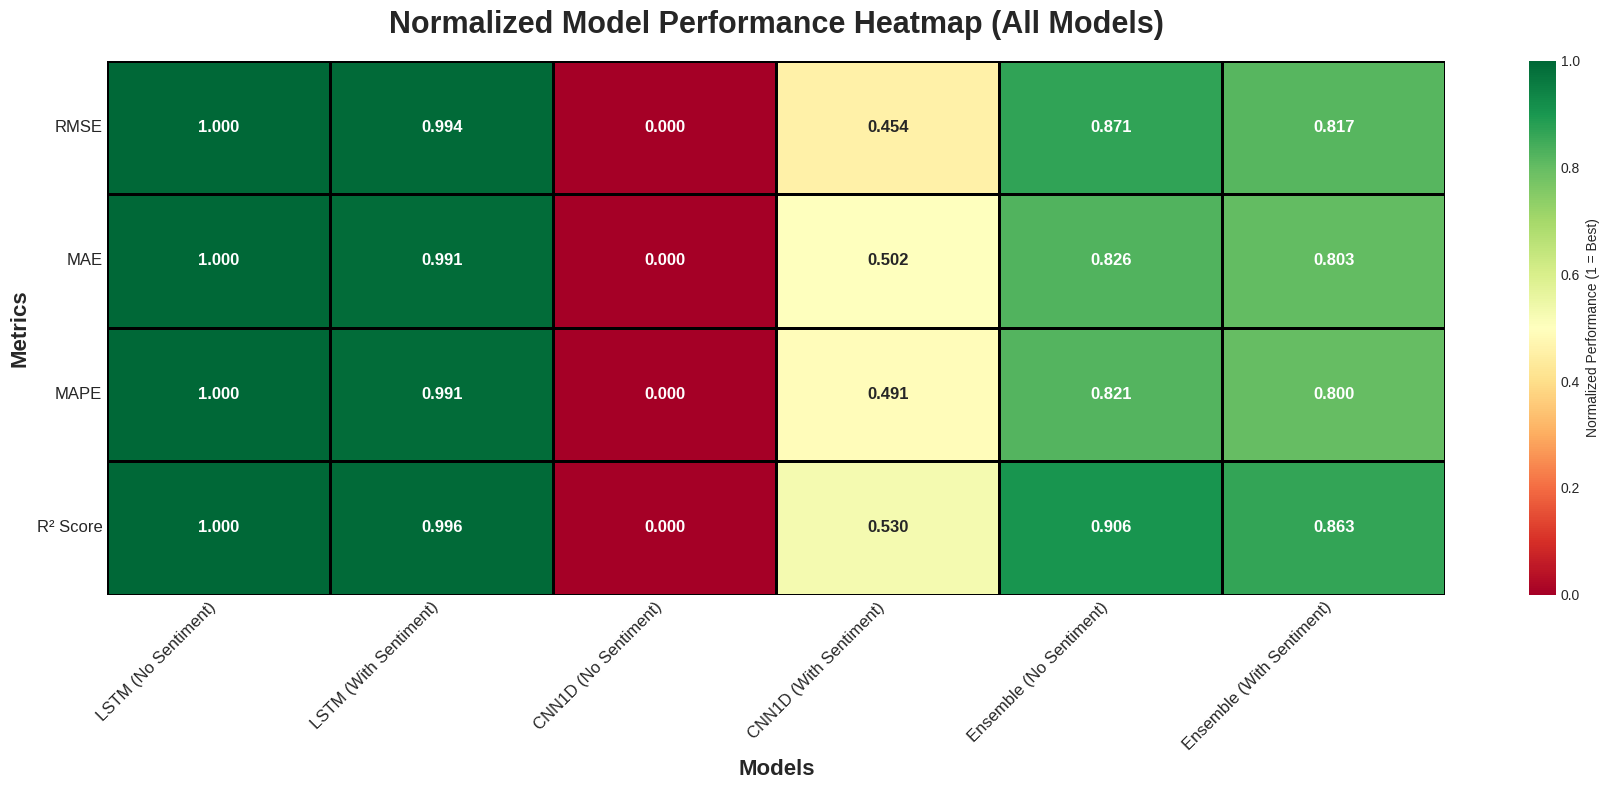

In [53]:
print("\n" + "="*100)
print("FORECAST VARIANCE AND STABILITY ANALYSIS - ALL MODELS")
print("="*100)

forecast_stats_all = {
    'Model': ['LSTM (No Sentiment)', 'LSTM (With Sentiment)',
              'CNN1D (No Sentiment)', 'CNN1D (With Sentiment)',
              'Ensemble (No Sentiment)', 'Ensemble (With Sentiment)'],
    'Mean': [forecasts_BBRI.mean(), forecasts_BBRI_Full.mean(),
             forecasts_cnn_BBRI.mean(), forecasts_cnn_BBRI_Full.mean(),
             forecasts_ensemble_BBRI.mean(), forecasts_ensemble_BBRI_Full.mean()],
    'Std Dev': [forecasts_BBRI.std(), forecasts_BBRI_Full.std(),
                forecasts_cnn_BBRI.std(), forecasts_cnn_BBRI_Full.std(),
                forecasts_ensemble_BBRI.std(), forecasts_ensemble_BBRI_Full.std()],
    'Min': [forecasts_BBRI.min(), forecasts_BBRI_Full.min(),
            forecasts_cnn_BBRI.min(), forecasts_cnn_BBRI_Full.min(),
            forecasts_ensemble_BBRI.min(), forecasts_ensemble_BBRI_Full.min()],
    'Max': [forecasts_BBRI.max(), forecasts_BBRI_Full.max(),
            forecasts_cnn_BBRI.max(), forecasts_cnn_BBRI_Full.max(),
            forecasts_ensemble_BBRI.max(), forecasts_ensemble_BBRI_Full.max()],
    'Range': [forecasts_BBRI.max() - forecasts_BBRI.min(),
              forecasts_BBRI_Full.max() - forecasts_BBRI_Full.min(),
              forecasts_cnn_BBRI.max() - forecasts_cnn_BBRI.min(),
              forecasts_cnn_BBRI_Full.max() - forecasts_cnn_BBRI_Full.min(),
              forecasts_ensemble_BBRI.max() - forecasts_ensemble_BBRI.min(),
              forecasts_ensemble_BBRI_Full.max() - forecasts_ensemble_BBRI_Full.min()]
}

forecast_stats_all_df = pd.DataFrame(forecast_stats_all)
print("\n" + forecast_stats_all_df.to_string(index=False))

# Heatmap comparison
print("\n" + "="*100)
print("HEATMAP VISUALIZATION - MODEL PERFORMANCE")
print("="*100)

# Create performance matrix for heatmap
performance_matrix = comprehensive_df_all.set_index('Model')[['RMSE', 'MAE', 'MAPE', 'R² Score']].T

# Normalize each metric (0-1 scale, where 1 is best)
normalized_matrix = performance_matrix.copy()
for metric in normalized_matrix.index:
    if metric == 'R² Score':
        # For R², higher is better
        normalized_matrix.loc[metric] = (normalized_matrix.loc[metric] - normalized_matrix.loc[metric].min()) / (normalized_matrix.loc[metric].max() - normalized_matrix.loc[metric].min())
    else:
        # For RMSE, MAE, MAPE, lower is better
        normalized_matrix.loc[metric] = 1 - (normalized_matrix.loc[metric] - normalized_matrix.loc[metric].min()) / (normalized_matrix.loc[metric].max() - normalized_matrix.loc[metric].min())

plt.figure(figsize=(18, 8))
sns.heatmap(normalized_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            cbar_kws={'label': 'Normalized Performance (1 = Best)'},
            linewidths=2, linecolor='black', vmin=0, vmax=1,
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Normalized Model Performance Heatmap (All Models)', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Models', fontsize=16, fontweight='bold')
plt.ylabel('Metrics', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

In [54]:
# Final ranking
print("\n" + "="*100)
print("MODEL RANKING BY PERFORMANCE")
print("="*100)

# Rank by each metric
rankings = {}
for metric in ['RMSE', 'MAE', 'MAPE', 'R² Score']:
    if metric == 'R² Score':
        rankings[metric] = comprehensive_df_all.sort_values(by=metric, ascending=False)['Model'].tolist()
    else:
        rankings[metric] = comprehensive_df_all.sort_values(by=metric, ascending=True)['Model'].tolist()

print("\nRanking by RMSE (Lower is Better):")
for i, model in enumerate(rankings['RMSE'], 1):
    print(f"  {i}. {model}")

print("\nRanking by MAE (Lower is Better):")
for i, model in enumerate(rankings['MAE'], 1):
    print(f"  {i}. {model}")

print("\nRanking by MAPE (Lower is Better):")
for i, model in enumerate(rankings['MAPE'], 1):
    print(f"  {i}. {model}")

print("\nRanking by R² Score (Higher is Better):")
for i, model in enumerate(rankings['R² Score'], 1):
    print(f"  {i}. {model}")

# Overall ranking based on average rank
print("\n" + "="*100)
print("OVERALL RANKING (Based on Average Rank Across All Metrics)")
print("="*100)

rank_scores = {}
for model in comprehensive_df_all['Model']:
    ranks = []
    for metric in ['RMSE', 'MAE', 'MAPE', 'R² Score']:
        ranks.append(rankings[metric].index(model) + 1)
    rank_scores[model] = np.mean(ranks)

overall_ranking = sorted(rank_scores.items(), key=lambda x: x[1])
print("\nOverall Model Ranking:")
for i, (model, avg_rank) in enumerate(overall_ranking, 1):
    print(f"  {i}. {model} (Average Rank: {avg_rank:.2f})")

print("\n" + "="*100)
print("🎉 COMPLETE ANALYSIS FINISHED!")
print("="*100)
print("\nKey Findings:")
best_rmse_model = comprehensive_df_all.loc[comprehensive_df_all['RMSE'].idxmin(), 'Model']
best_rmse_value = comprehensive_df_all['RMSE'].min()
best_r2_model = comprehensive_df_all.loc[comprehensive_df_all['R² Score'].idxmax(), 'Model']
best_r2_value = comprehensive_df_all['R² Score'].max()
most_stable_model = forecast_stats_all_df.loc[forecast_stats_all_df['Std Dev'].idxmin(), 'Model']
most_stable_value = forecast_stats_all_df['Std Dev'].min()
overall_best_model = overall_ranking[0][0]

print(f"1. Best Model by RMSE: {best_rmse_model}")
print(f"   RMSE: {best_rmse_value:.6f}")
print(f"\n2. Best Model by R² Score: {best_r2_model}")
print(f"   R² Score: {best_r2_value:.6f}")
print(f"\n3. Most Stable Forecast: {most_stable_model}")
print(f"   Std Dev: {most_stable_value:.6f}")
print(f"\n4. Overall Best Model: {overall_best_model}")
print(f"   Average Rank: {overall_ranking[0][1]:.2f}")

print("\n" + "="*100)
print("📊 All results have been saved to Google Drive!")
print("="*100)


MODEL RANKING BY PERFORMANCE

Ranking by RMSE (Lower is Better):
  1. LSTM (No Sentiment)
  2. LSTM (With Sentiment)
  3. Ensemble (No Sentiment)
  4. Ensemble (With Sentiment)
  5. CNN1D (With Sentiment)
  6. CNN1D (No Sentiment)

Ranking by MAE (Lower is Better):
  1. LSTM (No Sentiment)
  2. LSTM (With Sentiment)
  3. Ensemble (No Sentiment)
  4. Ensemble (With Sentiment)
  5. CNN1D (With Sentiment)
  6. CNN1D (No Sentiment)

Ranking by MAPE (Lower is Better):
  1. LSTM (No Sentiment)
  2. LSTM (With Sentiment)
  3. Ensemble (No Sentiment)
  4. Ensemble (With Sentiment)
  5. CNN1D (With Sentiment)
  6. CNN1D (No Sentiment)

Ranking by R² Score (Higher is Better):
  1. LSTM (No Sentiment)
  2. LSTM (With Sentiment)
  3. Ensemble (No Sentiment)
  4. Ensemble (With Sentiment)
  5. CNN1D (With Sentiment)
  6. CNN1D (No Sentiment)

OVERALL RANKING (Based on Average Rank Across All Metrics)

Overall Model Ranking:
  1. LSTM (No Sentiment) (Average Rank: 1.00)
  2. LSTM (With Sentiment) (